## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [ ]:
!pip install gym-minigrid &>/dev/null
!pip install --upgrade gym[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade git+https://github.com/openai/gym
!pip install autorom

  Cloning https://github.com/openai/gym to /tmp/pip-req-build-ys0hf8jq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/gym /tmp/pip-req-build-ys0hf8jq
  Resolved https://github.com/openai/gym to commit dcd185843a62953e27c2d54dc8c2d647d604b635
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/kehemo/uaas

Cloning into 'uaas'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 58 (delta 26), reused 24 (delta 7), pack-reused 0
Receiving objects: 100% (58/58), 824.59 KiB | 7.56 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
!pip install gym[accept-rom-license]
!pip install ale-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=a99d5e6e0397cbc1e9c889d8437994e7a59edd56d71d842ddca36226731b601b
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.6.1
    Uninstalling AutoROM-0.6.1:
      Successfully uninstalled AutoROM-0.6.1


In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from tqdm import tqdm
from dataclasses import dataclass


# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)


def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: a tuple of three floats
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """

    return torch.tensor(obss, device=device, dtype=torch.float)


@dataclass
class Config:
    """
    Stores algorithmic hyperparameters.
    """

    score_threshold = 0.93
    discount = 0.995
    lr = 1e-4
    max_grad_norm = 0.5
    log_interval = 10
    max_episodes = 2000
    gae_lambda = 0.95
    use_critic = False
    clip_ratio = 0.2
    target_kl = 0.01
    train_ac_iters = 5
    use_discounted_reward = False
    entropy_coef = 0.01
    use_gae = False

class BoxingACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        super(BoxingACModel, self).__init__()
        self.use_critic = use_critic

        # Convolutional layers to process image input
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # output: [210, 160, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [105, 80, 32]
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # output: [105, 80, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [52, 40, 64]
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # output: [52, 40, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: [26, 20, 128]
        )

        # Flatten the convolutional output
        self.flatten = nn.Flatten()

        # Common layers for both actor and critic
        self.common = nn.Sequential(
            nn.Linear(26*20*128, 64),
            nn.ReLU()
        )

        # Actor layers
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions),
            nn.LogSoftmax(dim=-1)
        )

        # Critic layers
        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)

        x = x.permute(0, 3, 1, 2)

        x = self.conv(x)
        x = self.flatten(x)
        x = self.common(x)
        action_probs = self.actor(x).squeeze()

        if self.use_critic:
            value = self.critic(x)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)


        return Categorical(logits=action_probs), value


def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """

    advantages = torch.zeros_like(values)
    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    td = (rewards + discount * torch.roll(values, -1) - values)[:T]
    coeffs = torch.triu(
        (discount * gae_lambda)
        ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(td.device)
    advantages = coeffs @ td
    ############################################################################
    return advantages[:T]


def compute_discounted_return(rewards, discount, device=None):
    """
                rewards: reward obtained at timestep.  Shape: (T,)
                discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
    """
    returns = torch.zeros(*rewards.shape, device=device)
    #### TODO: populate discounted reward trajectory (10 pts) ############
    T = rewards.shape[0]
    coeffs = torch.triu(
        discount ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(rewards.device)
    returns = coeffs @ rewards
    ######################################################################

    return returns


def collect_experiences(env, acmodel, args, device=None):
    """
    Collects rollouts and computes advantages.

    -------
    env     : DoorKeyEnv

              The environement used to execute policies in.


    acmodel : ACModel

              The model used to evaluate observations to collect experiences

    args    : Config

              config arguments


    device  : torch.cuda.device

              the device torch tensors are evaluated on.

    -------

    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """

    MAX_FRAMES_PER_EP = 60
    shape = (MAX_FRAMES_PER_EP,)

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None] * MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action_probs = torch.softmax(dist.logits, dim=-1)
        action = torch.argmax(action_probs)

        obss[T] = obs
        # update environment from taken action. We use the resulting observation,
        # reward, and whether or not environment is in the done/goal state.
        obs, reward, done, _, _ = env.step(action)

        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.logits[action]

        total_return += reward
        T += 1

        if done or T >= MAX_FRAMES_PER_EP - 1:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)

    # dict containing information on the experience
    exps = dict(
        obs=preprocess_obss([obss[i] for i in range(T)], device=device),
        action=actions[:T],
        value=values[:T],
        reward=rewards[:T],
        advantage=discounted_reward - values[:T],
        log_prob=log_probs[:T],
        discounted_reward=discounted_reward,
        advantage_gae=compute_advantage_gae(
            values, rewards, T, args.gae_lambda, args.discount
        ),
    )

    logs = {"return_per_episode": total_return, "num_frames": T}

    return exps, logs


def compute_policy_loss_reinforce(logps, returns):
    """
    Function for computing the policy loss for the REINFORCE algorithm. See
    4.2 of lecture notes.

                logps: log probabilities for each time step. Shape: (T,)
                returns: total return for each time step. Shape: (T,)

    ----
    return : tensor.float Shape: [T,]

             policy loss for each timestep
    """
    policy_loss = torch.tensor(0)

    #### TODO: complete policy loss (10 pts) ###
    # HINT:  Recall, that we want to perform gradient ASCENT to maximize returns
    policy_loss = -torch.mean(logps * returns)
    ############################################

    return policy_loss


def update_parameters_reinforce(optimizer, acmodel, sb, args):
    """
    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments. Config

    return output logs : dict
    """

    # logps is the log probability for taking an action for each time step. Shape (T,)
    logps, reward = None, None

    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, val = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])

    reward = sb["discounted_reward"] if args.use_discounted_reward else sb["reward"]
    ##############################################################################################

    # computes policy loss
    policy_loss = compute_policy_loss_reinforce(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()

    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print(
                "Make sure you're not instantiating any critic variables when the critic is not used"
            )
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {"policy_loss": update_policy_loss, "grad_norm": update_grad_norm}

    return logs


def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """

    # Initialize random seeds for reproducible results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('Boxing-v4')

    acmodel = BoxingACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    # Smooth reward taken from last SMOOTH_REWARD_WINDOW timesteps
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0] * SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))  # show progess bar ()
    for update in pbar:
        # First collect experiences
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        # update parameters from experiences
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])
        print(smooth_reward)

        data = {
            "episode": update,
            "num_frames": num_frames,
            "smooth_reward": smooth_reward,
            "reward": logs["return_per_episode"],
            "policy_loss": logs["policy_loss"],
        }

        if args.use_critic:
            data["value_loss"] = logs["value_loss"]

        pd_logs.append(data)

        #         pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print("Solved!")

    return pd.DataFrame(pd_logs).set_index("episode")


def compute_policy_loss_with_baseline(logps, advantages):
    """
    Computes policy loss with added baseline term. Refer to 4.3 in Lecture Notes.
    logps:  computed log probabilities. shape (T,)
    advantages: computed advantages. shape: (T,)

    ---

    return policy loss computed with baseline term: tensor.float. Shape (,1)

           refer to 4.3- Baseline in lecture notes

    """
    policy_loss = 0

    ### TODO: implement the policy loss (5 pts) ##############
    policy_loss = compute_policy_loss_reinforce(logps, advantages)
    ##################################################

    return policy_loss


def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    """
    Updates model parameters using value and policy functions

    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments
    """

    def _compute_value_loss(values, returns):
        """
        Computes the value loss of critic model. See 4.3 of Lecture Notes

        values: computed values from critic model shape: (T,)
        returns: discounted rewards. shape: (T,)


        ---
        computes loss of value function. See 4.3, eq. 11 in lecture notes : tensor.float. Shape (,1)
        """

        value_loss = 0

        ### TODO: implement the value loss (5 pts) ###############
        value_loss = torch.norm(returns - values, p=2)
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None

    dist, values = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])
    advantage = sb["advantage_gae"] if args.use_gae else sb["advantage"]
    reward = sb["discounted_reward"]

    policy_loss = compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, reward)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm,
    }

    return logs

In [ ]:
import gym
import ale_py

env = gym.make('Boxing-v4')
acmodel = BoxingACModel(env.action_space.n, use_critic=True)
collect_experiences(env, acmodel, Config(), 'cpu')
collect_experiences(env, acmodel, Config(), 'cpu')
collect_experiences(env, acmodel, Config(), 'cpu')

({'obs': tensor([[[[  0.,   0.,   0.],
            [  0.,   0.,   0.],
            [  0.,   0.,   0.],
            ...,
            [110., 156.,  66.],
            [110., 156.,  66.],
            [110., 156.,  66.]],
  
           [[  0.,   0.,   0.],
            [  0.,   0.,   0.],
            [  0.,   0.,   0.],
            ...,
            [110., 156.,  66.],
            [110., 156.,  66.],
            [110., 156.,  66.]],
  
           [[  0.,   0.,   0.],
            [  0.,   0.,   0.],
            [  0.,   0.,   0.],
            ...,
            [110., 156.,  66.],
            [110., 156.,  66.],
            [110., 156.,  66.]],
  
           ...,
  
           [[  0.,   0.,   0.],
            [  0.,   0.,   0.],
            [  0.,   0.,   0.],
            ...,
            [110., 156.,  66.],
            [110., 156.,  66.],
            [110., 156.,  66.]],
  
           [[  0.,   0.,   0.],
            [  0.,   0.,   0.],
            [  0.,   0.,   0.],
            ...,
         

## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

In [ ]:
import torch
class UAASParameterUpdate:
    def __init__(self, alpha, epsilon):
        self.q_j = 0
        self.j = 1
        self.alpha = alpha
        self.epsilon = epsilon

    def step_size(self):
        return self.j ** (-0.5 + self.epsilon)

    def __call__(self, optimizer, acmodel, sb, args):
        """
        optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
        acmodel: Network used to compute policy. torch.nn.Module
        sb: stores experience data. Refer to "collect_experiences". dict
        args: Config arguments. Config

        return output logs : dict
        """
        dist, vals = acmodel(sb["obs"])
        logps = dist.log_prob(sb["action"])
        val_nograd = sb['value']
        reward = sb["discounted_reward"]
        val_t1 = torch.roll(val_nograd, shifts=-1, dims=0)
        val_t1[-1] = 0
        reduced_reward = sb["reward"] + args.discount * val_t1
        score = (val_nograd - reward) * (val_nograd - reward)
        indices = []
        for x in score[1:]:
            s = x.item()
            self.q_j += self.step_size() * ((1 if self.q_j <= s else 0) - self.alpha)
            indices.append(1 if self.q_j <= s else 0)
        indices.append(0)
        reward_prime = torch.stack([reward, reduced_reward])[indices]
        advantage = reward_prime - val_nograd
        # computes policy loss
        policy_loss = compute_policy_loss_with_baseline(logps, advantage)
        update_policy_loss = policy_loss.item()

        value_loss = torch.norm(reward - vals, p=2)
        update_value_loss = value_loss.item()

        loss = value_loss + policy_loss

        # Update actor-critic
        optimizer.zero_grad()
        loss.backward()

        # Perform gradient clipping for stability
        update_grad_norm = (
            sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
        )
        torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
        optimizer.step()

        # Log some values
        logs = {
            "policy_loss": update_policy_loss,
            "grad_norm": update_grad_norm,
            "value_loss": update_value_loss,
        }

        return logs

In [ ]:
args = Config()
args.use_critic=True
df = run_experiment(args, UAASParameterUpdate(0.05, 0.1))

df.plot(x='num_frames', y=['smooth_reward'])

  0%|          | 1/2000 [00:03<2:02:21,  3.67s/it]

-0.06


  0%|          | 2/2000 [00:07<2:14:51,  4.05s/it]

-0.06


  0%|          | 3/2000 [00:12<2:14:36,  4.04s/it]

-0.1


  0%|          | 4/2000 [00:15<2:08:59,  3.88s/it]

-0.1


  0%|          | 5/2000 [00:19<2:09:39,  3.90s/it]

-0.1


  0%|          | 6/2000 [00:24<2:15:30,  4.08s/it]

-0.1


  0%|          | 7/2000 [00:27<2:12:57,  4.00s/it]

-0.1


  0%|          | 8/2000 [00:31<2:13:10,  4.01s/it]

-0.1


  0%|          | 9/2000 [00:36<2:18:49,  4.18s/it]

-0.1


  0%|          | 10/2000 [00:40<2:13:03,  4.01s/it]

-0.1


  1%|          | 11/2000 [00:43<2:08:52,  3.89s/it]

-0.1


  1%|          | 12/2000 [00:48<2:19:22,  4.21s/it]

-0.1


  1%|          | 13/2000 [00:52<2:15:19,  4.09s/it]

-0.1


  1%|          | 14/2000 [00:56<2:12:16,  4.00s/it]

-0.1


  1%|          | 15/2000 [01:01<2:28:42,  4.49s/it]

-0.1


  1%|          | 16/2000 [01:05<2:20:45,  4.26s/it]

-0.1


  1%|          | 17/2000 [01:09<2:17:07,  4.15s/it]

-0.1


  1%|          | 18/2000 [01:13<2:20:42,  4.26s/it]

-0.1


  1%|          | 19/2000 [01:17<2:15:06,  4.09s/it]

-0.1


  1%|          | 20/2000 [01:21<2:11:09,  3.97s/it]

-0.08


  1%|          | 21/2000 [01:26<2:20:35,  4.26s/it]

-0.08


  1%|          | 22/2000 [01:30<2:16:07,  4.13s/it]

-0.08


  1%|          | 23/2000 [01:33<2:12:38,  4.03s/it]

-0.08


  1%|          | 24/2000 [01:38<2:22:27,  4.33s/it]

-0.06


  1%|▏         | 25/2000 [01:42<2:17:28,  4.18s/it]

-0.06


  1%|▏         | 26/2000 [01:46<2:14:22,  4.08s/it]

-0.06


  1%|▏         | 27/2000 [01:51<2:23:12,  4.36s/it]

-0.06


  1%|▏         | 28/2000 [01:55<2:17:23,  4.18s/it]

-0.06


  1%|▏         | 29/2000 [01:59<2:13:25,  4.06s/it]

-0.06


  2%|▏         | 30/2000 [02:04<2:21:44,  4.32s/it]

-0.06


  2%|▏         | 31/2000 [02:07<2:16:13,  4.15s/it]

-0.06


  2%|▏         | 32/2000 [02:11<2:12:23,  4.04s/it]

-0.06


  2%|▏         | 33/2000 [02:16<2:21:26,  4.31s/it]

-0.06


  2%|▏         | 34/2000 [02:20<2:16:00,  4.15s/it]

-0.06


  2%|▏         | 35/2000 [02:24<2:12:04,  4.03s/it]

-0.06


  2%|▏         | 36/2000 [02:29<2:21:01,  4.31s/it]

-0.06


  2%|▏         | 37/2000 [02:32<2:15:36,  4.14s/it]

-0.06


  2%|▏         | 38/2000 [02:36<2:11:39,  4.03s/it]

-0.06


  2%|▏         | 39/2000 [02:41<2:21:43,  4.34s/it]

-0.06


  2%|▏         | 40/2000 [02:45<2:17:19,  4.20s/it]

-0.06


  2%|▏         | 41/2000 [02:49<2:12:59,  4.07s/it]

-0.06


  2%|▏         | 42/2000 [02:54<2:21:50,  4.35s/it]

-0.06


  2%|▏         | 43/2000 [02:58<2:16:08,  4.17s/it]

-0.06


  2%|▏         | 44/2000 [03:01<2:13:09,  4.08s/it]

-0.06


  2%|▏         | 45/2000 [03:07<2:22:48,  4.38s/it]

-0.06


  2%|▏         | 46/2000 [03:10<2:17:02,  4.21s/it]

-0.06


  2%|▏         | 47/2000 [03:14<2:12:41,  4.08s/it]

-0.06


  2%|▏         | 48/2000 [03:19<2:21:24,  4.35s/it]

-0.06


  2%|▏         | 49/2000 [03:23<2:15:55,  4.18s/it]

-0.06


  2%|▎         | 50/2000 [03:27<2:11:54,  4.06s/it]

-0.06


  3%|▎         | 51/2000 [03:32<2:21:17,  4.35s/it]

0.0


  3%|▎         | 52/2000 [03:35<2:15:17,  4.17s/it]

0.0


  3%|▎         | 53/2000 [03:39<2:11:52,  4.06s/it]

0.04


  3%|▎         | 54/2000 [03:44<2:21:57,  4.38s/it]

0.04


  3%|▎         | 55/2000 [03:48<2:15:57,  4.19s/it]

0.04


  3%|▎         | 56/2000 [03:52<2:11:50,  4.07s/it]

0.04


  3%|▎         | 57/2000 [03:57<2:20:15,  4.33s/it]

0.04


  3%|▎         | 58/2000 [04:01<2:14:08,  4.14s/it]

0.04


  3%|▎         | 59/2000 [04:04<2:10:18,  4.03s/it]

0.04


  3%|▎         | 60/2000 [04:09<2:19:27,  4.31s/it]

0.04


  3%|▎         | 61/2000 [04:13<2:14:19,  4.16s/it]

0.04


  3%|▎         | 62/2000 [04:17<2:11:06,  4.06s/it]

0.04


  3%|▎         | 63/2000 [04:22<2:20:27,  4.35s/it]

0.04


  3%|▎         | 64/2000 [04:26<2:14:10,  4.16s/it]

0.04


  3%|▎         | 65/2000 [04:29<2:09:53,  4.03s/it]

0.04


  3%|▎         | 66/2000 [04:34<2:18:46,  4.31s/it]

0.04


  3%|▎         | 67/2000 [04:38<2:13:36,  4.15s/it]

0.04


  3%|▎         | 68/2000 [04:42<2:09:49,  4.03s/it]

0.04


  3%|▎         | 69/2000 [04:47<2:18:12,  4.29s/it]

0.04


  4%|▎         | 70/2000 [04:51<2:13:08,  4.14s/it]

0.02


  4%|▎         | 71/2000 [04:54<2:09:36,  4.03s/it]

0.02


  4%|▎         | 72/2000 [04:59<2:17:20,  4.27s/it]

0.02


  4%|▎         | 73/2000 [05:03<2:11:49,  4.10s/it]

0.02


  4%|▎         | 74/2000 [05:07<2:08:00,  3.99s/it]

0.0


  4%|▍         | 75/2000 [05:11<2:16:43,  4.26s/it]

0.0


  4%|▍         | 76/2000 [05:15<2:11:46,  4.11s/it]

0.0


  4%|▍         | 77/2000 [05:19<2:08:17,  4.00s/it]

0.0


  4%|▍         | 78/2000 [05:24<2:18:27,  4.32s/it]

0.0


  4%|▍         | 79/2000 [05:28<2:13:58,  4.18s/it]

0.0


  4%|▍         | 80/2000 [05:32<2:09:56,  4.06s/it]

0.0


  4%|▍         | 81/2000 [05:37<2:19:33,  4.36s/it]

0.0


  4%|▍         | 82/2000 [05:41<2:13:58,  4.19s/it]

0.0


  4%|▍         | 83/2000 [05:44<2:10:09,  4.07s/it]

0.0


  4%|▍         | 84/2000 [05:49<2:18:41,  4.34s/it]

0.0


  4%|▍         | 85/2000 [05:53<2:13:05,  4.17s/it]

0.0


  4%|▍         | 86/2000 [05:57<2:08:52,  4.04s/it]

0.0


  4%|▍         | 87/2000 [06:02<2:18:53,  4.36s/it]

0.0


  4%|▍         | 88/2000 [06:06<2:13:34,  4.19s/it]

0.0


  4%|▍         | 89/2000 [06:10<2:10:09,  4.09s/it]

0.0


  4%|▍         | 90/2000 [06:15<2:18:47,  4.36s/it]

0.0


  5%|▍         | 91/2000 [06:18<2:12:46,  4.17s/it]

0.0


  5%|▍         | 92/2000 [06:22<2:09:19,  4.07s/it]

0.0


  5%|▍         | 93/2000 [06:27<2:18:53,  4.37s/it]

0.0


  5%|▍         | 94/2000 [06:31<2:13:11,  4.19s/it]

0.0


  5%|▍         | 95/2000 [06:35<2:09:23,  4.08s/it]

0.0


  5%|▍         | 96/2000 [06:40<2:17:47,  4.34s/it]

0.0


  5%|▍         | 97/2000 [06:43<2:11:41,  4.15s/it]

0.0


  5%|▍         | 98/2000 [06:47<2:07:50,  4.03s/it]

0.0


  5%|▍         | 99/2000 [06:52<2:16:47,  4.32s/it]

0.0


  5%|▌         | 100/2000 [06:56<2:11:07,  4.14s/it]

0.0


  5%|▌         | 101/2000 [07:00<2:07:13,  4.02s/it]

0.0


  5%|▌         | 102/2000 [07:05<2:16:28,  4.31s/it]

0.0


  5%|▌         | 103/2000 [07:08<2:10:37,  4.13s/it]

0.0


  5%|▌         | 104/2000 [07:12<2:06:38,  4.01s/it]

0.0


  5%|▌         | 105/2000 [07:17<2:16:34,  4.32s/it]

0.0


  5%|▌         | 106/2000 [07:21<2:11:53,  4.18s/it]

0.0


  5%|▌         | 107/2000 [07:25<2:08:03,  4.06s/it]

0.0


  5%|▌         | 108/2000 [07:30<2:16:52,  4.34s/it]

0.0


  5%|▌         | 109/2000 [07:34<2:11:12,  4.16s/it]

0.0


  6%|▌         | 110/2000 [07:37<2:07:26,  4.05s/it]

0.0


  6%|▌         | 111/2000 [07:42<2:15:35,  4.31s/it]

0.0


  6%|▌         | 112/2000 [07:46<2:10:13,  4.14s/it]

0.0


  6%|▌         | 113/2000 [07:50<2:06:23,  4.02s/it]

0.0


  6%|▌         | 114/2000 [07:55<2:15:17,  4.30s/it]

0.0


  6%|▌         | 115/2000 [07:58<2:10:30,  4.15s/it]

0.0


  6%|▌         | 116/2000 [08:02<2:06:57,  4.04s/it]

0.0


  6%|▌         | 117/2000 [08:07<2:16:58,  4.36s/it]

0.0


  6%|▌         | 118/2000 [08:11<2:11:23,  4.19s/it]

0.0


  6%|▌         | 119/2000 [08:15<2:07:02,  4.05s/it]

0.0


  6%|▌         | 120/2000 [08:20<2:15:19,  4.32s/it]

0.0


  6%|▌         | 121/2000 [08:24<2:09:32,  4.14s/it]

0.0


  6%|▌         | 122/2000 [08:27<2:05:59,  4.03s/it]

0.0


  6%|▌         | 123/2000 [08:32<2:14:29,  4.30s/it]

0.0


  6%|▌         | 124/2000 [08:36<2:08:49,  4.12s/it]

0.0


  6%|▋         | 125/2000 [08:40<2:05:37,  4.02s/it]

0.0


  6%|▋         | 126/2000 [08:45<2:14:32,  4.31s/it]

0.0


  6%|▋         | 127/2000 [08:49<2:10:16,  4.17s/it]

0.0


  6%|▋         | 128/2000 [08:52<2:07:00,  4.07s/it]

0.0


  6%|▋         | 129/2000 [08:57<2:15:17,  4.34s/it]

0.0


  6%|▋         | 130/2000 [09:01<2:09:27,  4.15s/it]

0.0


  7%|▋         | 131/2000 [09:05<2:05:19,  4.02s/it]

0.0


  7%|▋         | 132/2000 [09:10<2:13:48,  4.30s/it]

0.0


  7%|▋         | 133/2000 [09:13<2:07:31,  4.10s/it]

0.0


  7%|▋         | 134/2000 [09:17<2:03:28,  3.97s/it]

0.0


  7%|▋         | 135/2000 [09:22<2:12:52,  4.27s/it]

0.0


  7%|▋         | 136/2000 [09:26<2:08:00,  4.12s/it]

0.0


  7%|▋         | 137/2000 [09:30<2:05:27,  4.04s/it]

0.0


  7%|▋         | 138/2000 [09:35<2:14:06,  4.32s/it]

0.0


  7%|▋         | 139/2000 [09:38<2:09:46,  4.18s/it]

0.0


  7%|▋         | 140/2000 [09:42<2:05:49,  4.06s/it]

0.0


  7%|▋         | 141/2000 [09:47<2:14:16,  4.33s/it]

0.0


  7%|▋         | 142/2000 [09:51<2:08:48,  4.16s/it]

0.0


  7%|▋         | 143/2000 [09:55<2:04:34,  4.03s/it]

0.0


  7%|▋         | 144/2000 [10:00<2:12:53,  4.30s/it]

0.0


  7%|▋         | 145/2000 [10:03<2:07:22,  4.12s/it]

0.0


  7%|▋         | 146/2000 [10:07<2:03:23,  3.99s/it]

0.0


  7%|▋         | 147/2000 [10:12<2:10:38,  4.23s/it]

0.0


  7%|▋         | 148/2000 [10:16<2:05:58,  4.08s/it]

0.0


  7%|▋         | 149/2000 [10:19<2:02:51,  3.98s/it]

0.0


  8%|▊         | 150/2000 [10:24<2:06:49,  4.11s/it]

0.0


  8%|▊         | 151/2000 [10:28<2:06:20,  4.10s/it]

0.0


  8%|▊         | 152/2000 [10:31<2:02:43,  3.98s/it]

0.0


  8%|▊         | 153/2000 [10:36<2:04:02,  4.03s/it]

0.0


  8%|▊         | 154/2000 [10:40<2:06:47,  4.12s/it]

0.0


  8%|▊         | 155/2000 [10:44<2:02:37,  3.99s/it]

0.0


  8%|▊         | 156/2000 [10:47<2:01:02,  3.94s/it]

0.0


  8%|▊         | 157/2000 [10:52<2:07:58,  4.17s/it]

0.0


  8%|▊         | 158/2000 [10:56<2:04:46,  4.06s/it]

0.0


  8%|▊         | 159/2000 [11:00<2:03:08,  4.01s/it]

0.0


  8%|▊         | 160/2000 [11:05<2:10:45,  4.26s/it]

0.0


  8%|▊         | 161/2000 [11:08<2:05:45,  4.10s/it]

0.0


  8%|▊         | 162/2000 [11:12<2:01:47,  3.98s/it]

0.0


  8%|▊         | 163/2000 [11:17<2:10:17,  4.26s/it]

0.0


  8%|▊         | 164/2000 [11:21<2:06:01,  4.12s/it]

0.0


  8%|▊         | 165/2000 [11:25<2:03:08,  4.03s/it]

0.0


  8%|▊         | 166/2000 [11:30<2:12:17,  4.33s/it]

0.0


  8%|▊         | 167/2000 [11:33<2:06:45,  4.15s/it]

0.0


  8%|▊         | 168/2000 [11:37<2:02:49,  4.02s/it]

0.0


  8%|▊         | 169/2000 [11:42<2:11:25,  4.31s/it]

0.0


  8%|▊         | 170/2000 [11:46<2:07:04,  4.17s/it]

0.0


  9%|▊         | 171/2000 [11:50<2:04:14,  4.08s/it]

0.0


  9%|▊         | 172/2000 [11:55<2:12:26,  4.35s/it]

0.0


  9%|▊         | 173/2000 [11:58<2:06:29,  4.15s/it]

0.0


  9%|▊         | 174/2000 [12:02<2:02:21,  4.02s/it]

0.0


  9%|▉         | 175/2000 [12:07<2:10:07,  4.28s/it]

0.0


  9%|▉         | 176/2000 [12:11<2:04:55,  4.11s/it]

0.0


  9%|▉         | 177/2000 [12:15<2:01:20,  3.99s/it]

0.0


  9%|▉         | 178/2000 [12:19<2:09:46,  4.27s/it]

0.0


  9%|▉         | 179/2000 [12:23<2:05:23,  4.13s/it]

0.0


  9%|▉         | 180/2000 [12:27<2:02:31,  4.04s/it]

0.0


  9%|▉         | 181/2000 [12:32<2:11:55,  4.35s/it]

0.0


  9%|▉         | 182/2000 [12:36<2:06:31,  4.18s/it]

0.0


  9%|▉         | 183/2000 [12:40<2:02:27,  4.04s/it]

0.0


  9%|▉         | 184/2000 [12:45<2:10:47,  4.32s/it]

0.0


  9%|▉         | 185/2000 [12:48<2:05:04,  4.13s/it]

0.0


  9%|▉         | 186/2000 [12:52<2:01:40,  4.02s/it]

0.0


  9%|▉         | 187/2000 [12:57<2:09:29,  4.29s/it]

0.0


  9%|▉         | 188/2000 [13:01<2:03:59,  4.11s/it]

0.0


  9%|▉         | 189/2000 [13:04<2:00:06,  3.98s/it]

0.0


 10%|▉         | 190/2000 [13:09<2:09:29,  4.29s/it]

0.0


 10%|▉         | 191/2000 [13:13<2:05:06,  4.15s/it]

0.0


 10%|▉         | 192/2000 [13:17<2:01:43,  4.04s/it]

0.0


 10%|▉         | 193/2000 [13:22<2:10:21,  4.33s/it]

0.0


 10%|▉         | 194/2000 [13:26<2:04:45,  4.14s/it]

0.0


 10%|▉         | 195/2000 [13:29<2:00:05,  3.99s/it]

0.0


 10%|▉         | 196/2000 [13:34<2:07:15,  4.23s/it]

0.0


 10%|▉         | 197/2000 [13:38<2:02:11,  4.07s/it]

0.0


 10%|▉         | 198/2000 [13:42<1:59:14,  3.97s/it]

0.0


 10%|▉         | 199/2000 [13:47<2:08:04,  4.27s/it]

0.0


 10%|█         | 200/2000 [13:50<2:03:55,  4.13s/it]

0.0


 10%|█         | 201/2000 [13:54<2:00:23,  4.02s/it]

0.0


 10%|█         | 202/2000 [13:59<2:08:55,  4.30s/it]

0.0


 10%|█         | 203/2000 [14:03<2:02:46,  4.10s/it]

0.0


 10%|█         | 204/2000 [14:06<1:59:04,  3.98s/it]

0.0


 10%|█         | 205/2000 [14:11<2:07:47,  4.27s/it]

0.0


 10%|█         | 206/2000 [14:15<2:02:19,  4.09s/it]

0.0


 10%|█         | 207/2000 [14:19<1:58:38,  3.97s/it]

0.0


 10%|█         | 208/2000 [14:24<2:06:40,  4.24s/it]

0.0


 10%|█         | 209/2000 [14:27<2:01:50,  4.08s/it]

0.0


 10%|█         | 210/2000 [14:31<1:58:41,  3.98s/it]

0.0


 11%|█         | 211/2000 [14:36<2:06:43,  4.25s/it]

0.0


 11%|█         | 212/2000 [14:40<2:02:10,  4.10s/it]

0.0


 11%|█         | 213/2000 [14:43<1:58:26,  3.98s/it]

0.0


 11%|█         | 214/2000 [14:48<2:05:49,  4.23s/it]

0.0


 11%|█         | 215/2000 [14:52<2:01:17,  4.08s/it]

0.0


 11%|█         | 216/2000 [14:56<1:57:52,  3.96s/it]

0.0


 11%|█         | 217/2000 [15:00<2:04:41,  4.20s/it]

0.0


 11%|█         | 218/2000 [15:04<2:01:07,  4.08s/it]

0.0


 11%|█         | 219/2000 [15:08<1:58:04,  3.98s/it]

0.0


 11%|█         | 220/2000 [15:12<2:01:53,  4.11s/it]

0.0


 11%|█         | 221/2000 [15:16<2:01:30,  4.10s/it]

0.0


 11%|█         | 222/2000 [15:20<1:58:07,  3.99s/it]

0.0


 11%|█         | 223/2000 [15:24<1:59:09,  4.02s/it]

0.0


 11%|█         | 224/2000 [15:28<2:01:46,  4.11s/it]

0.0


 11%|█▏        | 225/2000 [15:32<1:57:52,  3.98s/it]

0.0


 11%|█▏        | 226/2000 [15:36<1:55:25,  3.90s/it]

0.0


 11%|█▏        | 226/2000 [15:41<2:03:07,  4.16s/it]


KeyboardInterrupt: 

In [ ]:
df.plot(x='num_frames', y=['0.05', '0.1'])

NameError: name 'df' is not defined

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

Oh, the reward is binary and difficult to see the improvement since it depends on the density of the blue bar in the plot. So, we smooth reward by averaging certain amount of rewards from previous episode (`smooth_reward`).

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). **(10 pts)**



  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 1/2000 [00:03<2:02:34,  3.68s/it]

-0.04


  0%|          | 2/2000 [00:08<2:25:52,  4.38s/it]

-0.04


  0%|          | 3/2000 [00:12<2:15:31,  4.07s/it]

-0.04


  0%|          | 4/2000 [00:15<2:10:35,  3.93s/it]

-0.04


  0%|          | 5/2000 [00:20<2:20:19,  4.22s/it]

-0.04


  0%|          | 6/2000 [00:24<2:16:25,  4.10s/it]

-0.04


  0%|          | 7/2000 [00:28<2:11:35,  3.96s/it]

-0.04


  0%|          | 8/2000 [00:32<2:19:28,  4.20s/it]

-0.04


  0%|          | 9/2000 [00:36<2:16:20,  4.11s/it]

-0.04


  0%|          | 10/2000 [00:40<2:11:35,  3.97s/it]

-0.04


  1%|          | 11/2000 [00:45<2:17:15,  4.14s/it]

-0.04


  1%|          | 12/2000 [00:49<2:17:50,  4.16s/it]

-0.04


  1%|          | 13/2000 [00:52<2:13:20,  4.03s/it]

-0.04


  1%|          | 14/2000 [00:57<2:15:37,  4.10s/it]

-0.04


  1%|          | 15/2000 [01:01<2:17:19,  4.15s/it]

-0.04


  1%|          | 16/2000 [01:05<2:12:50,  4.02s/it]

-0.04


  1%|          | 17/2000 [01:09<2:13:03,  4.03s/it]

-0.04


  1%|          | 18/2000 [01:13<2:18:05,  4.18s/it]

-0.04


  1%|          | 19/2000 [01:17<2:14:31,  4.07s/it]

-0.04


  1%|          | 20/2000 [01:21<2:13:46,  4.05s/it]

-0.04


  1%|          | 21/2000 [01:26<2:19:59,  4.24s/it]

-0.04


  1%|          | 22/2000 [01:30<2:15:10,  4.10s/it]

-0.04


  1%|          | 23/2000 [01:33<2:12:27,  4.02s/it]

-0.04


  1%|          | 24/2000 [01:38<2:21:04,  4.28s/it]

-0.04


  1%|▏         | 25/2000 [01:42<2:16:46,  4.16s/it]

-0.04


  1%|▏         | 26/2000 [01:46<2:12:42,  4.03s/it]

-0.04


  1%|▏         | 27/2000 [01:51<2:19:57,  4.26s/it]

-0.04


  1%|▏         | 28/2000 [01:54<2:14:07,  4.08s/it]

-0.04


  1%|▏         | 29/2000 [01:58<2:10:16,  3.97s/it]

-0.04


  2%|▏         | 30/2000 [02:03<2:18:50,  4.23s/it]

-0.04


  2%|▏         | 31/2000 [02:07<2:13:41,  4.07s/it]

-0.04


  2%|▏         | 32/2000 [02:10<2:09:58,  3.96s/it]

-0.04


  2%|▏         | 33/2000 [02:15<2:18:55,  4.24s/it]

-0.04


  2%|▏         | 34/2000 [02:19<2:13:35,  4.08s/it]

-0.04


  2%|▏         | 35/2000 [02:23<2:09:58,  3.97s/it]

-0.04


  2%|▏         | 36/2000 [02:28<2:20:12,  4.28s/it]

-0.04


  2%|▏         | 37/2000 [02:31<2:15:35,  4.14s/it]

-0.04


  2%|▏         | 38/2000 [02:35<2:11:40,  4.03s/it]

-0.04


  2%|▏         | 39/2000 [02:40<2:20:41,  4.30s/it]

-0.04


  2%|▏         | 40/2000 [02:44<2:15:19,  4.14s/it]

-0.04


  2%|▏         | 41/2000 [02:48<2:10:37,  4.00s/it]

-0.04


  2%|▏         | 42/2000 [02:53<2:19:30,  4.28s/it]

-0.04


  2%|▏         | 43/2000 [02:56<2:13:27,  4.09s/it]

-0.04


  2%|▏         | 44/2000 [03:00<2:08:57,  3.96s/it]

-0.04


  2%|▏         | 45/2000 [03:05<2:17:40,  4.23s/it]

-0.04


  2%|▏         | 46/2000 [03:08<2:12:14,  4.06s/it]

-0.04


  2%|▏         | 47/2000 [03:12<2:09:11,  3.97s/it]

-0.04


  2%|▏         | 48/2000 [03:17<2:19:51,  4.30s/it]

-0.04


  2%|▏         | 49/2000 [03:21<2:14:35,  4.14s/it]

-0.04


  2%|▎         | 50/2000 [03:25<2:11:09,  4.04s/it]

-0.04


  3%|▎         | 51/2000 [03:30<2:19:29,  4.29s/it]

0.0


  3%|▎         | 52/2000 [03:33<2:13:07,  4.10s/it]

0.0


  3%|▎         | 53/2000 [03:37<2:09:14,  3.98s/it]

0.0


  3%|▎         | 54/2000 [03:42<2:19:48,  4.31s/it]

0.0


  3%|▎         | 55/2000 [03:46<2:14:19,  4.14s/it]

0.0


  3%|▎         | 56/2000 [03:50<2:10:15,  4.02s/it]

0.0


  3%|▎         | 57/2000 [03:54<2:18:03,  4.26s/it]

0.0


  3%|▎         | 58/2000 [03:58<2:12:23,  4.09s/it]

0.0


  3%|▎         | 59/2000 [04:02<2:08:08,  3.96s/it]

0.0


  3%|▎         | 60/2000 [04:07<2:16:23,  4.22s/it]

0.0


  3%|▎         | 61/2000 [04:10<2:11:37,  4.07s/it]

0.0


  3%|▎         | 62/2000 [04:14<2:09:09,  4.00s/it]

0.0


  3%|▎         | 63/2000 [04:19<2:18:42,  4.30s/it]

0.0


  3%|▎         | 64/2000 [04:23<2:13:08,  4.13s/it]

0.0


  3%|▎         | 65/2000 [04:26<2:08:37,  3.99s/it]

0.0


  3%|▎         | 66/2000 [04:31<2:17:03,  4.25s/it]

0.0


  3%|▎         | 67/2000 [04:35<2:11:18,  4.08s/it]

0.0


  3%|▎         | 68/2000 [04:39<2:07:58,  3.97s/it]

0.0


  3%|▎         | 69/2000 [04:44<2:16:19,  4.24s/it]

0.0


  4%|▎         | 70/2000 [04:47<2:11:56,  4.10s/it]

0.0


  4%|▎         | 71/2000 [04:51<2:08:52,  4.01s/it]

0.0


  4%|▎         | 72/2000 [04:56<2:16:07,  4.24s/it]

0.0


  4%|▎         | 73/2000 [05:00<2:12:37,  4.13s/it]

0.0


  4%|▎         | 74/2000 [05:04<2:08:28,  4.00s/it]

0.0


  4%|▍         | 75/2000 [05:08<2:11:40,  4.10s/it]

0.0


  4%|▍         | 76/2000 [05:12<2:11:32,  4.10s/it]

0.0


  4%|▍         | 77/2000 [05:16<2:07:56,  3.99s/it]

0.0


  4%|▍         | 78/2000 [05:20<2:09:06,  4.03s/it]

0.0


  4%|▍         | 79/2000 [05:24<2:12:24,  4.14s/it]

0.0


  4%|▍         | 80/2000 [05:28<2:08:44,  4.02s/it]

0.0


  4%|▍         | 81/2000 [05:32<2:07:59,  4.00s/it]

0.0


  4%|▍         | 82/2000 [05:36<2:13:17,  4.17s/it]

0.0


  4%|▍         | 83/2000 [05:40<2:08:57,  4.04s/it]

0.0


  4%|▍         | 84/2000 [05:44<2:06:00,  3.95s/it]

0.0


  4%|▍         | 85/2000 [05:49<2:14:11,  4.20s/it]

0.0


  4%|▍         | 86/2000 [05:52<2:09:07,  4.05s/it]

0.0


  4%|▍         | 87/2000 [05:56<2:05:35,  3.94s/it]

0.0


  4%|▍         | 88/2000 [06:01<2:14:32,  4.22s/it]

0.0


  4%|▍         | 89/2000 [06:05<2:09:11,  4.06s/it]

0.0


  4%|▍         | 90/2000 [06:08<2:05:53,  3.95s/it]

0.0


  5%|▍         | 91/2000 [06:13<2:14:39,  4.23s/it]

0.0


  5%|▍         | 92/2000 [06:17<2:09:03,  4.06s/it]

0.0


  5%|▍         | 93/2000 [06:21<2:05:17,  3.94s/it]

0.0


  5%|▍         | 94/2000 [06:26<2:15:23,  4.26s/it]

0.0


  5%|▍         | 95/2000 [06:29<2:11:22,  4.14s/it]

0.0


  5%|▍         | 96/2000 [06:33<2:08:15,  4.04s/it]

0.0


  5%|▍         | 97/2000 [06:38<2:16:05,  4.29s/it]

0.0


  5%|▍         | 98/2000 [06:42<2:10:18,  4.11s/it]

0.0


  5%|▍         | 99/2000 [06:46<2:06:44,  4.00s/it]

0.0


  5%|▌         | 100/2000 [06:51<2:15:52,  4.29s/it]

0.0


  5%|▌         | 101/2000 [06:54<2:11:58,  4.17s/it]

0.0


  5%|▌         | 102/2000 [06:58<2:07:28,  4.03s/it]

0.0


  5%|▌         | 103/2000 [07:03<2:16:35,  4.32s/it]

0.0


  5%|▌         | 104/2000 [07:07<2:10:14,  4.12s/it]

0.0


  5%|▌         | 105/2000 [07:10<2:05:52,  3.99s/it]

0.0


  5%|▌         | 106/2000 [07:15<2:14:33,  4.26s/it]

0.0


  5%|▌         | 107/2000 [07:19<2:08:51,  4.08s/it]

0.0


  5%|▌         | 108/2000 [07:23<2:05:12,  3.97s/it]

0.0


  5%|▌         | 109/2000 [07:28<2:13:53,  4.25s/it]

0.0


  6%|▌         | 110/2000 [07:31<2:08:43,  4.09s/it]

0.0


  6%|▌         | 111/2000 [07:35<2:04:53,  3.97s/it]

0.0


  6%|▌         | 112/2000 [07:40<2:13:27,  4.24s/it]

0.0


  6%|▌         | 113/2000 [07:44<2:08:55,  4.10s/it]

0.0


  6%|▌         | 114/2000 [07:48<2:06:44,  4.03s/it]

0.0


  6%|▌         | 115/2000 [07:53<2:16:01,  4.33s/it]

0.0


  6%|▌         | 116/2000 [07:56<2:10:04,  4.14s/it]

0.0


  6%|▌         | 117/2000 [08:00<2:05:53,  4.01s/it]

0.0


  6%|▌         | 118/2000 [08:05<2:14:13,  4.28s/it]

0.0


  6%|▌         | 119/2000 [08:09<2:08:42,  4.11s/it]

0.0


  6%|▌         | 120/2000 [08:12<2:05:02,  3.99s/it]

0.0


  6%|▌         | 121/2000 [08:17<2:13:46,  4.27s/it]

0.0


  6%|▌         | 122/2000 [08:21<2:07:58,  4.09s/it]

0.0


  6%|▌         | 123/2000 [08:25<2:04:31,  3.98s/it]

0.0


  6%|▌         | 124/2000 [08:30<2:13:41,  4.28s/it]

0.0


  6%|▋         | 125/2000 [08:33<2:09:25,  4.14s/it]

0.0


  6%|▋         | 126/2000 [08:37<2:06:18,  4.04s/it]

0.0


  6%|▋         | 127/2000 [08:42<2:14:48,  4.32s/it]

0.0


  6%|▋         | 128/2000 [08:46<2:09:29,  4.15s/it]

0.0


  6%|▋         | 129/2000 [08:50<2:04:53,  4.01s/it]

0.0


  6%|▋         | 130/2000 [08:55<2:14:45,  4.32s/it]

0.0


  7%|▋         | 131/2000 [08:59<2:09:48,  4.17s/it]

0.0


  7%|▋         | 132/2000 [09:02<2:05:55,  4.04s/it]

0.0


  7%|▋         | 133/2000 [09:07<2:14:30,  4.32s/it]

0.0


  7%|▋         | 134/2000 [09:11<2:09:18,  4.16s/it]

0.0


  7%|▋         | 135/2000 [09:15<2:06:03,  4.06s/it]

0.0


  7%|▋         | 136/2000 [09:20<2:14:54,  4.34s/it]

0.0


  7%|▋         | 137/2000 [09:24<2:09:18,  4.16s/it]

0.0


  7%|▋         | 138/2000 [09:27<2:05:34,  4.05s/it]

0.0


  7%|▋         | 139/2000 [09:32<2:13:04,  4.29s/it]

0.0


  7%|▋         | 140/2000 [09:36<2:07:45,  4.12s/it]

0.0


  7%|▋         | 141/2000 [09:40<2:03:49,  4.00s/it]

0.0


  7%|▋         | 142/2000 [09:44<2:10:32,  4.22s/it]

0.0


  7%|▋         | 143/2000 [09:48<2:06:18,  4.08s/it]

0.0


  7%|▋         | 144/2000 [09:52<2:03:30,  3.99s/it]

0.0


  7%|▋         | 145/2000 [09:57<2:10:21,  4.22s/it]

0.0


  7%|▋         | 146/2000 [10:01<2:08:04,  4.14s/it]

0.0


  7%|▋         | 147/2000 [10:04<2:03:48,  4.01s/it]

0.0


  7%|▋         | 148/2000 [10:09<2:07:40,  4.14s/it]

0.0


  7%|▋         | 149/2000 [10:13<2:08:14,  4.16s/it]

0.0


  8%|▊         | 150/2000 [10:17<2:04:48,  4.05s/it]

0.0


  8%|▊         | 151/2000 [10:21<2:06:46,  4.11s/it]

0.0


  8%|▊         | 152/2000 [10:25<2:08:16,  4.16s/it]

0.0


  8%|▊         | 153/2000 [10:29<2:04:14,  4.04s/it]

0.0


  8%|▊         | 154/2000 [10:33<2:04:50,  4.06s/it]

0.0


  8%|▊         | 155/2000 [10:38<2:08:34,  4.18s/it]

0.0


  8%|▊         | 156/2000 [10:41<2:04:09,  4.04s/it]

0.0


  8%|▊         | 157/2000 [10:45<2:02:53,  4.00s/it]

0.0


  8%|▊         | 158/2000 [10:50<2:09:07,  4.21s/it]

0.0


  8%|▊         | 159/2000 [10:54<2:04:48,  4.07s/it]

0.0


  8%|▊         | 160/2000 [10:58<2:02:53,  4.01s/it]

0.0


  8%|▊         | 161/2000 [11:02<2:10:52,  4.27s/it]

0.0


  8%|▊         | 162/2000 [11:06<2:06:04,  4.12s/it]

0.0


  8%|▊         | 163/2000 [11:10<2:02:41,  4.01s/it]

0.0


  8%|▊         | 164/2000 [11:15<2:10:42,  4.27s/it]

0.0


  8%|▊         | 165/2000 [11:19<2:05:59,  4.12s/it]

0.0


  8%|▊         | 166/2000 [11:22<2:02:07,  4.00s/it]

0.0


  8%|▊         | 167/2000 [11:27<2:10:31,  4.27s/it]

0.0


  8%|▊         | 168/2000 [11:31<2:05:16,  4.10s/it]

0.0


  8%|▊         | 169/2000 [11:35<2:01:58,  4.00s/it]

0.0


  8%|▊         | 170/2000 [11:40<2:11:03,  4.30s/it]

0.0


  9%|▊         | 171/2000 [11:43<2:05:59,  4.13s/it]

0.0


  9%|▊         | 172/2000 [11:47<2:03:20,  4.05s/it]

0.0


  9%|▊         | 173/2000 [11:52<2:12:04,  4.34s/it]

0.0


  9%|▊         | 174/2000 [11:56<2:06:47,  4.17s/it]

0.0


  9%|▉         | 175/2000 [12:00<2:03:05,  4.05s/it]

0.0


  9%|▉         | 176/2000 [12:05<2:10:54,  4.31s/it]

0.0


  9%|▉         | 177/2000 [12:08<2:05:30,  4.13s/it]

0.0


  9%|▉         | 178/2000 [12:12<2:01:49,  4.01s/it]

0.0


  9%|▉         | 179/2000 [12:17<2:10:12,  4.29s/it]

0.0


  9%|▉         | 180/2000 [12:21<2:05:08,  4.13s/it]

0.0


  9%|▉         | 181/2000 [12:25<2:02:13,  4.03s/it]

0.0


  9%|▉         | 182/2000 [12:30<2:11:27,  4.34s/it]

0.0


  9%|▉         | 183/2000 [12:34<2:06:34,  4.18s/it]

0.0


  9%|▉         | 184/2000 [12:37<2:02:48,  4.06s/it]

0.0


  9%|▉         | 185/2000 [12:42<2:10:58,  4.33s/it]

0.0


  9%|▉         | 186/2000 [12:46<2:05:16,  4.14s/it]

0.0


  9%|▉         | 187/2000 [12:50<2:01:53,  4.03s/it]

0.0


  9%|▉         | 188/2000 [12:55<2:10:02,  4.31s/it]

0.0


  9%|▉         | 189/2000 [12:58<2:04:51,  4.14s/it]

0.0


 10%|▉         | 190/2000 [13:02<2:01:21,  4.02s/it]

0.0


 10%|▉         | 191/2000 [13:07<2:09:27,  4.29s/it]

0.0


 10%|▉         | 192/2000 [13:11<2:04:55,  4.15s/it]

0.0


 10%|▉         | 193/2000 [13:15<2:02:22,  4.06s/it]

0.0


 10%|▉         | 194/2000 [13:20<2:11:01,  4.35s/it]

0.0


 10%|▉         | 195/2000 [13:24<2:05:32,  4.17s/it]

0.0


 10%|▉         | 196/2000 [13:27<2:01:04,  4.03s/it]

0.0


 10%|▉         | 197/2000 [13:32<2:09:22,  4.31s/it]

0.0


 10%|▉         | 198/2000 [13:36<2:04:59,  4.16s/it]

0.0


 10%|▉         | 199/2000 [13:40<2:01:48,  4.06s/it]

0.0


 10%|█         | 200/2000 [13:45<2:10:26,  4.35s/it]

0.0


 10%|█         | 201/2000 [13:49<2:04:41,  4.16s/it]

0.0


 10%|█         | 202/2000 [13:52<2:00:48,  4.03s/it]

0.0


 10%|█         | 203/2000 [13:57<2:08:26,  4.29s/it]

0.0


 10%|█         | 204/2000 [14:01<2:03:11,  4.12s/it]

0.0


 10%|█         | 205/2000 [14:05<1:59:35,  4.00s/it]

0.0


 10%|█         | 206/2000 [14:10<2:07:44,  4.27s/it]

0.0


 10%|█         | 207/2000 [14:13<2:02:33,  4.10s/it]

0.0


 10%|█         | 208/2000 [14:17<1:59:13,  3.99s/it]

0.0


 10%|█         | 209/2000 [14:22<2:07:37,  4.28s/it]

0.0


 10%|█         | 210/2000 [14:26<2:02:26,  4.10s/it]

0.0


 11%|█         | 211/2000 [14:29<1:59:02,  3.99s/it]

0.0


 11%|█         | 212/2000 [14:34<2:08:36,  4.32s/it]

0.0


 11%|█         | 213/2000 [14:38<2:03:51,  4.16s/it]

0.0


 11%|█         | 214/2000 [14:42<2:00:22,  4.04s/it]

0.0


 11%|█         | 215/2000 [14:47<2:07:59,  4.30s/it]

0.0


 11%|█         | 216/2000 [14:51<2:02:39,  4.13s/it]

0.0


 11%|█         | 217/2000 [14:54<1:59:47,  4.03s/it]

0.0


 11%|█         | 218/2000 [15:00<2:08:46,  4.34s/it]

0.0


 11%|█         | 219/2000 [15:03<2:03:43,  4.17s/it]

0.0


 11%|█         | 220/2000 [15:07<2:00:13,  4.05s/it]

0.0


 11%|█         | 221/2000 [15:12<2:08:50,  4.35s/it]

0.0


 11%|█         | 222/2000 [15:16<2:03:47,  4.18s/it]

0.0


 11%|█         | 223/2000 [15:20<1:59:46,  4.04s/it]

0.0


 11%|█         | 224/2000 [15:25<2:07:42,  4.31s/it]

0.0


 11%|█▏        | 225/2000 [15:28<2:02:49,  4.15s/it]

0.0


 11%|█▏        | 226/2000 [15:32<2:00:15,  4.07s/it]

0.0


 11%|█▏        | 227/2000 [15:37<2:08:06,  4.34s/it]

0.0


 11%|█▏        | 228/2000 [15:41<2:02:27,  4.15s/it]

0.0


 11%|█▏        | 229/2000 [15:45<1:58:32,  4.02s/it]

0.0


 12%|█▏        | 230/2000 [15:49<2:06:24,  4.29s/it]

0.0


 12%|█▏        | 231/2000 [15:53<2:01:55,  4.14s/it]

0.0


 12%|█▏        | 232/2000 [15:57<1:58:05,  4.01s/it]

0.0


 12%|█▏        | 233/2000 [16:02<2:06:02,  4.28s/it]

0.0


 12%|█▏        | 234/2000 [16:06<2:01:23,  4.12s/it]

0.0


 12%|█▏        | 235/2000 [16:09<1:57:38,  4.00s/it]

0.0


 12%|█▏        | 236/2000 [16:14<2:05:53,  4.28s/it]

0.0


 12%|█▏        | 237/2000 [16:18<2:01:16,  4.13s/it]

0.0


 12%|█▏        | 238/2000 [16:22<1:57:36,  4.00s/it]

0.0


 12%|█▏        | 239/2000 [16:27<2:05:46,  4.29s/it]

0.0


 12%|█▏        | 240/2000 [16:30<2:00:31,  4.11s/it]

0.0


 12%|█▏        | 241/2000 [16:34<1:57:47,  4.02s/it]

0.0


 12%|█▏        | 242/2000 [16:39<2:06:58,  4.33s/it]

0.0


 12%|█▏        | 243/2000 [16:43<2:01:44,  4.16s/it]

0.0


 12%|█▏        | 244/2000 [16:47<1:58:01,  4.03s/it]

0.0


 12%|█▏        | 245/2000 [16:52<2:05:26,  4.29s/it]

0.0


 12%|█▏        | 246/2000 [16:55<2:00:16,  4.11s/it]

0.0


 12%|█▏        | 247/2000 [16:59<1:56:14,  3.98s/it]

0.0


 12%|█▏        | 248/2000 [17:04<2:02:48,  4.21s/it]

0.0


 12%|█▏        | 249/2000 [17:08<1:59:13,  4.09s/it]

0.0


 12%|█▎        | 250/2000 [17:11<1:56:13,  3.98s/it]

0.0


 13%|█▎        | 251/2000 [17:16<2:02:10,  4.19s/it]

0.0


 13%|█▎        | 252/2000 [17:20<2:01:03,  4.16s/it]

0.0


 13%|█▎        | 253/2000 [17:24<1:57:44,  4.04s/it]

0.0


 13%|█▎        | 254/2000 [17:28<2:02:00,  4.19s/it]

0.0


 13%|█▎        | 255/2000 [17:32<2:00:49,  4.15s/it]

0.0


 13%|█▎        | 256/2000 [17:36<1:57:21,  4.04s/it]

0.0


 13%|█▎        | 257/2000 [17:41<2:00:42,  4.16s/it]

0.0


 13%|█▎        | 258/2000 [17:45<2:01:40,  4.19s/it]

0.0


 13%|█▎        | 259/2000 [17:49<1:57:04,  4.03s/it]

0.0


 13%|█▎        | 260/2000 [17:53<1:56:57,  4.03s/it]

0.0


 13%|█▎        | 261/2000 [17:57<2:00:45,  4.17s/it]

0.0


 13%|█▎        | 262/2000 [18:01<1:56:35,  4.03s/it]

0.0


 13%|█▎        | 263/2000 [18:05<1:55:32,  3.99s/it]

0.0


 13%|█▎        | 264/2000 [18:10<2:02:20,  4.23s/it]

0.0


 13%|█▎        | 265/2000 [18:13<1:58:37,  4.10s/it]

0.0


 13%|█▎        | 266/2000 [18:17<1:57:07,  4.05s/it]

0.0


 13%|█▎        | 267/2000 [18:22<2:02:20,  4.24s/it]

0.0


 13%|█▎        | 268/2000 [18:26<1:58:02,  4.09s/it]

0.0


 13%|█▎        | 269/2000 [18:29<1:54:24,  3.97s/it]

0.0


 14%|█▎        | 270/2000 [18:34<2:01:35,  4.22s/it]

0.0


 14%|█▎        | 271/2000 [18:38<1:57:14,  4.07s/it]

0.0


 14%|█▎        | 272/2000 [18:42<1:53:54,  3.95s/it]

0.0


 14%|█▎        | 273/2000 [18:46<2:02:15,  4.25s/it]

0.0


 14%|█▎        | 274/2000 [18:50<1:57:43,  4.09s/it]

0.0


 14%|█▍        | 275/2000 [18:54<1:54:42,  3.99s/it]

0.0


 14%|█▍        | 276/2000 [18:59<2:03:19,  4.29s/it]

0.0


 14%|█▍        | 277/2000 [19:03<1:59:18,  4.15s/it]

0.0


 14%|█▍        | 278/2000 [19:07<1:56:24,  4.06s/it]

0.0


 14%|█▍        | 279/2000 [19:12<2:03:52,  4.32s/it]

0.0


 14%|█▍        | 280/2000 [19:15<1:58:23,  4.13s/it]

0.0


 14%|█▍        | 281/2000 [19:19<1:54:32,  4.00s/it]

0.0


 14%|█▍        | 282/2000 [19:24<2:02:27,  4.28s/it]

0.0


 14%|█▍        | 283/2000 [19:28<1:57:54,  4.12s/it]

0.0


 14%|█▍        | 284/2000 [19:31<1:55:16,  4.03s/it]

0.0


 14%|█▍        | 285/2000 [19:37<2:03:59,  4.34s/it]

0.0


 14%|█▍        | 286/2000 [19:40<1:59:04,  4.17s/it]

0.0


 14%|█▍        | 287/2000 [19:44<1:55:10,  4.03s/it]

0.0


 14%|█▍        | 288/2000 [19:49<2:02:46,  4.30s/it]

0.0


 14%|█▍        | 289/2000 [19:53<1:57:36,  4.12s/it]

0.0


 14%|█▍        | 290/2000 [19:56<1:53:35,  3.99s/it]

0.0


 15%|█▍        | 291/2000 [20:01<2:02:13,  4.29s/it]

0.0


 15%|█▍        | 292/2000 [20:05<1:57:54,  4.14s/it]

0.0


 15%|█▍        | 293/2000 [20:09<1:55:13,  4.05s/it]

0.0


 15%|█▍        | 294/2000 [20:14<2:02:40,  4.31s/it]

0.0


 15%|█▍        | 295/2000 [20:18<1:58:22,  4.17s/it]

0.0


 15%|█▍        | 296/2000 [20:22<1:55:36,  4.07s/it]

0.0


 15%|█▍        | 297/2000 [20:27<2:03:17,  4.34s/it]

0.0


 15%|█▍        | 298/2000 [20:30<1:58:24,  4.17s/it]

0.0


 15%|█▍        | 299/2000 [20:34<1:54:08,  4.03s/it]

0.0


 15%|█▌        | 300/2000 [20:39<2:01:36,  4.29s/it]

0.0


 15%|█▌        | 301/2000 [20:43<1:56:46,  4.12s/it]

0.0


 15%|█▌        | 302/2000 [20:46<1:53:00,  3.99s/it]

0.0


 15%|█▌        | 303/2000 [20:51<2:02:10,  4.32s/it]

0.0


 15%|█▌        | 304/2000 [20:55<1:57:55,  4.17s/it]

0.0


 15%|█▌        | 305/2000 [20:59<1:54:51,  4.07s/it]

0.0


 15%|█▌        | 306/2000 [21:04<2:02:05,  4.32s/it]

0.0


 15%|█▌        | 307/2000 [21:08<1:57:14,  4.16s/it]

0.0


 15%|█▌        | 308/2000 [21:11<1:53:14,  4.02s/it]

0.0


 15%|█▌        | 309/2000 [21:16<2:00:42,  4.28s/it]

0.0


 16%|█▌        | 310/2000 [21:20<1:55:45,  4.11s/it]

0.0


 16%|█▌        | 311/2000 [21:24<1:53:16,  4.02s/it]

0.0


 16%|█▌        | 312/2000 [21:29<2:01:43,  4.33s/it]

0.0


 16%|█▌        | 313/2000 [21:33<1:57:07,  4.17s/it]

0.0


 16%|█▌        | 314/2000 [21:36<1:53:33,  4.04s/it]

0.0


 16%|█▌        | 315/2000 [21:41<2:00:59,  4.31s/it]

0.0


 16%|█▌        | 316/2000 [21:45<1:56:13,  4.14s/it]

0.0


 16%|█▌        | 317/2000 [21:49<1:53:14,  4.04s/it]

0.0


 16%|█▌        | 318/2000 [21:54<2:01:50,  4.35s/it]

0.0


 16%|█▌        | 319/2000 [21:58<1:57:09,  4.18s/it]

0.0


 16%|█▌        | 320/2000 [22:02<1:53:23,  4.05s/it]

0.0


 16%|█▌        | 321/2000 [22:06<2:01:08,  4.33s/it]

0.0


 16%|█▌        | 322/2000 [22:10<1:56:49,  4.18s/it]

0.0


 16%|█▌        | 323/2000 [22:14<1:53:40,  4.07s/it]

0.0


 16%|█▌        | 324/2000 [22:19<2:00:38,  4.32s/it]

0.0


 16%|█▋        | 325/2000 [22:23<1:56:01,  4.16s/it]

0.0


 16%|█▋        | 326/2000 [22:27<1:52:10,  4.02s/it]

0.0


 16%|█▋        | 327/2000 [22:31<2:00:00,  4.30s/it]

0.0


 16%|█▋        | 328/2000 [22:35<1:55:05,  4.13s/it]

0.0


 16%|█▋        | 329/2000 [22:39<1:51:24,  4.00s/it]

0.0


 16%|█▋        | 330/2000 [22:44<1:59:02,  4.28s/it]

0.0


 17%|█▋        | 331/2000 [22:48<1:54:24,  4.11s/it]

0.0


 17%|█▋        | 332/2000 [22:51<1:50:55,  3.99s/it]

0.0


 17%|█▋        | 333/2000 [22:56<1:58:19,  4.26s/it]

0.0


 17%|█▋        | 334/2000 [23:00<1:53:25,  4.09s/it]

0.0


 17%|█▋        | 335/2000 [23:04<1:50:44,  3.99s/it]

0.0


 17%|█▋        | 336/2000 [23:09<1:58:22,  4.27s/it]

0.0


 17%|█▋        | 337/2000 [23:12<1:54:39,  4.14s/it]

0.0


 17%|█▋        | 338/2000 [23:16<1:52:16,  4.05s/it]

0.0


 17%|█▋        | 339/2000 [23:21<1:59:49,  4.33s/it]

0.0


 17%|█▋        | 340/2000 [23:25<1:54:45,  4.15s/it]

0.0


 17%|█▋        | 341/2000 [23:29<1:51:12,  4.02s/it]

0.0


 17%|█▋        | 342/2000 [23:34<1:58:34,  4.29s/it]

0.0


 17%|█▋        | 343/2000 [23:37<1:53:51,  4.12s/it]

0.0


 17%|█▋        | 344/2000 [23:41<1:50:08,  3.99s/it]

0.0


 17%|█▋        | 345/2000 [23:46<1:57:30,  4.26s/it]

0.0


 17%|█▋        | 346/2000 [23:50<1:53:04,  4.10s/it]

0.0


 17%|█▋        | 347/2000 [23:53<1:49:45,  3.98s/it]

0.0


 17%|█▋        | 348/2000 [23:58<1:57:12,  4.26s/it]

0.0


 17%|█▋        | 349/2000 [24:02<1:52:47,  4.10s/it]

0.0


 18%|█▊        | 350/2000 [24:06<1:49:47,  3.99s/it]

0.0


 18%|█▊        | 351/2000 [24:11<1:58:15,  4.30s/it]

0.0


 18%|█▊        | 352/2000 [24:14<1:53:54,  4.15s/it]

0.0


 18%|█▊        | 353/2000 [24:18<1:50:22,  4.02s/it]

0.0


 18%|█▊        | 354/2000 [24:23<1:57:02,  4.27s/it]

0.0


 18%|█▊        | 355/2000 [24:27<1:53:55,  4.16s/it]

0.0


 18%|█▊        | 356/2000 [24:31<1:50:36,  4.04s/it]

0.0


 18%|█▊        | 357/2000 [24:35<1:56:01,  4.24s/it]

0.0


 18%|█▊        | 358/2000 [24:39<1:53:22,  4.14s/it]

0.0


 18%|█▊        | 359/2000 [24:43<1:50:00,  4.02s/it]

0.0


 18%|█▊        | 360/2000 [24:47<1:53:04,  4.14s/it]

0.0


 18%|█▊        | 361/2000 [24:52<1:52:34,  4.12s/it]

0.0


 18%|█▊        | 362/2000 [24:55<1:48:57,  3.99s/it]

0.0


 18%|█▊        | 363/2000 [24:59<1:48:46,  3.99s/it]

0.0


 18%|█▊        | 364/2000 [25:04<1:52:35,  4.13s/it]

0.0


 18%|█▊        | 365/2000 [25:07<1:48:54,  4.00s/it]

0.0


 18%|█▊        | 366/2000 [25:11<1:46:25,  3.91s/it]

0.0


 18%|█▊        | 367/2000 [25:16<1:53:59,  4.19s/it]

0.0


 18%|█▊        | 368/2000 [25:20<1:51:03,  4.08s/it]

0.0


 18%|█▊        | 369/2000 [25:23<1:48:23,  3.99s/it]

0.0


 18%|█▊        | 370/2000 [25:28<1:54:39,  4.22s/it]

0.0


 19%|█▊        | 371/2000 [25:32<1:50:36,  4.07s/it]

0.0


 19%|█▊        | 372/2000 [25:36<1:47:24,  3.96s/it]

0.0


 19%|█▊        | 373/2000 [25:41<1:56:02,  4.28s/it]

0.0


 19%|█▊        | 374/2000 [25:44<1:51:41,  4.12s/it]

0.0


 19%|█▉        | 375/2000 [25:48<1:48:29,  4.01s/it]

0.0


 19%|█▉        | 376/2000 [25:53<1:56:22,  4.30s/it]

0.0


 19%|█▉        | 377/2000 [25:57<1:52:45,  4.17s/it]

0.0


 19%|█▉        | 378/2000 [26:01<1:49:43,  4.06s/it]

0.0


 19%|█▉        | 379/2000 [26:06<1:56:44,  4.32s/it]

0.0


 19%|█▉        | 380/2000 [26:09<1:51:40,  4.14s/it]

0.0


 19%|█▉        | 381/2000 [26:13<1:48:00,  4.00s/it]

0.0


 19%|█▉        | 382/2000 [26:18<1:55:44,  4.29s/it]

0.0


 19%|█▉        | 383/2000 [26:22<1:50:39,  4.11s/it]

0.0


 19%|█▉        | 384/2000 [26:25<1:47:03,  3.97s/it]

0.0


 19%|█▉        | 385/2000 [26:30<1:53:50,  4.23s/it]

0.0


 19%|█▉        | 386/2000 [26:34<1:49:38,  4.08s/it]

0.0


 19%|█▉        | 387/2000 [26:38<1:46:23,  3.96s/it]

0.0


 19%|█▉        | 388/2000 [26:43<1:54:25,  4.26s/it]

0.0


 19%|█▉        | 389/2000 [26:46<1:50:52,  4.13s/it]

0.0


 20%|█▉        | 390/2000 [26:50<1:47:52,  4.02s/it]

0.0


 20%|█▉        | 391/2000 [26:55<1:55:15,  4.30s/it]

0.0


 20%|█▉        | 392/2000 [26:59<1:50:46,  4.13s/it]

0.0


 20%|█▉        | 393/2000 [27:03<1:47:17,  4.01s/it]

0.0


 20%|█▉        | 394/2000 [27:08<1:54:35,  4.28s/it]

0.0


 20%|█▉        | 395/2000 [27:11<1:49:39,  4.10s/it]

0.0


 20%|█▉        | 396/2000 [27:15<1:46:00,  3.97s/it]

0.0


 20%|█▉        | 397/2000 [27:20<1:53:23,  4.24s/it]

0.0


 20%|█▉        | 398/2000 [27:24<1:49:06,  4.09s/it]

0.0


 20%|█▉        | 399/2000 [27:27<1:46:10,  3.98s/it]

0.0


 20%|██        | 400/2000 [27:32<1:52:46,  4.23s/it]

0.0


 20%|██        | 401/2000 [27:36<1:48:37,  4.08s/it]

0.0


 20%|██        | 402/2000 [27:40<1:46:49,  4.01s/it]

0.0


 20%|██        | 403/2000 [27:45<1:55:06,  4.32s/it]

0.0


 20%|██        | 404/2000 [27:48<1:50:05,  4.14s/it]

0.0


 20%|██        | 405/2000 [27:52<1:46:58,  4.02s/it]

0.0


 20%|██        | 406/2000 [27:57<1:54:12,  4.30s/it]

0.0


 20%|██        | 407/2000 [28:01<1:49:14,  4.11s/it]

0.0


 20%|██        | 408/2000 [28:05<1:46:03,  4.00s/it]

0.0


 20%|██        | 409/2000 [28:09<1:53:06,  4.27s/it]

0.0


 20%|██        | 410/2000 [28:13<1:48:37,  4.10s/it]

0.0


 21%|██        | 411/2000 [28:17<1:45:42,  3.99s/it]

0.0


 21%|██        | 412/2000 [28:22<1:54:14,  4.32s/it]

0.0


 21%|██        | 413/2000 [28:26<1:49:22,  4.14s/it]

0.0


 21%|██        | 414/2000 [28:29<1:46:08,  4.02s/it]

0.0


 21%|██        | 415/2000 [28:34<1:53:30,  4.30s/it]

0.0


 21%|██        | 416/2000 [28:38<1:48:54,  4.13s/it]

0.0


 21%|██        | 417/2000 [28:42<1:45:22,  3.99s/it]

0.0


 21%|██        | 418/2000 [28:47<1:52:54,  4.28s/it]

0.0


 21%|██        | 419/2000 [28:50<1:48:34,  4.12s/it]

0.0


 21%|██        | 420/2000 [28:54<1:45:19,  4.00s/it]

0.0


 21%|██        | 421/2000 [28:59<1:52:09,  4.26s/it]

0.0


 21%|██        | 422/2000 [29:03<1:47:44,  4.10s/it]

0.0


 21%|██        | 423/2000 [29:07<1:45:07,  4.00s/it]

0.0


 21%|██        | 424/2000 [29:11<1:52:15,  4.27s/it]

0.0


 21%|██▏       | 425/2000 [29:15<1:48:45,  4.14s/it]

0.0


 21%|██▏       | 426/2000 [29:19<1:46:08,  4.05s/it]

0.0


 21%|██▏       | 427/2000 [29:24<1:51:48,  4.26s/it]

0.0


 21%|██▏       | 428/2000 [29:28<1:48:21,  4.14s/it]

0.0


 21%|██▏       | 429/2000 [29:31<1:45:21,  4.02s/it]

0.0


 22%|██▏       | 430/2000 [29:36<1:48:28,  4.15s/it]

0.0


 22%|██▏       | 431/2000 [29:40<1:47:56,  4.13s/it]

0.0


 22%|██▏       | 432/2000 [29:44<1:44:39,  4.00s/it]

0.0


 22%|██▏       | 433/2000 [29:48<1:46:02,  4.06s/it]

0.0


 22%|██▏       | 434/2000 [29:52<1:48:13,  4.15s/it]

0.0


 22%|██▏       | 435/2000 [29:56<1:45:58,  4.06s/it]

0.0


 22%|██▏       | 436/2000 [30:00<1:47:19,  4.12s/it]

0.0


 22%|██▏       | 437/2000 [30:05<1:49:20,  4.20s/it]

0.0


 22%|██▏       | 438/2000 [30:08<1:45:34,  4.06s/it]

0.0


 22%|██▏       | 439/2000 [30:12<1:44:32,  4.02s/it]

0.0


 22%|██▏       | 440/2000 [30:17<1:48:49,  4.19s/it]

0.0


 22%|██▏       | 441/2000 [30:21<1:45:35,  4.06s/it]

0.0


 22%|██▏       | 442/2000 [30:25<1:43:39,  3.99s/it]

0.0


 22%|██▏       | 443/2000 [30:29<1:50:44,  4.27s/it]

0.0


 22%|██▏       | 444/2000 [30:33<1:46:50,  4.12s/it]

0.0


 22%|██▏       | 445/2000 [30:37<1:43:49,  4.01s/it]

0.0


 22%|██▏       | 446/2000 [30:42<1:51:48,  4.32s/it]

0.0


 22%|██▏       | 447/2000 [30:46<1:48:06,  4.18s/it]

0.0


 22%|██▏       | 448/2000 [30:50<1:44:49,  4.05s/it]

0.0


 22%|██▏       | 449/2000 [30:55<1:51:19,  4.31s/it]

0.0


 22%|██▎       | 450/2000 [30:58<1:46:37,  4.13s/it]

0.0


 23%|██▎       | 451/2000 [31:02<1:43:24,  4.01s/it]

0.0


 23%|██▎       | 452/2000 [31:07<1:49:50,  4.26s/it]

0.0


 23%|██▎       | 453/2000 [31:11<1:45:26,  4.09s/it]

0.0


 23%|██▎       | 454/2000 [31:14<1:42:30,  3.98s/it]

0.0


 23%|██▎       | 455/2000 [31:19<1:50:02,  4.27s/it]

0.0


 23%|██▎       | 456/2000 [31:23<1:45:55,  4.12s/it]

0.0


 23%|██▎       | 457/2000 [31:27<1:43:03,  4.01s/it]

0.0


 23%|██▎       | 458/2000 [31:32<1:50:21,  4.29s/it]

0.0


 23%|██▎       | 459/2000 [31:35<1:45:42,  4.12s/it]

0.0


 23%|██▎       | 460/2000 [31:39<1:42:27,  3.99s/it]

0.0


 23%|██▎       | 461/2000 [31:44<1:49:30,  4.27s/it]

0.0


 23%|██▎       | 462/2000 [31:48<1:45:16,  4.11s/it]

0.0


 23%|██▎       | 463/2000 [31:51<1:42:13,  3.99s/it]

0.0


 23%|██▎       | 464/2000 [31:56<1:49:39,  4.28s/it]

0.0


 23%|██▎       | 465/2000 [32:00<1:45:25,  4.12s/it]

0.0


 23%|██▎       | 466/2000 [32:04<1:42:06,  3.99s/it]

0.0


 23%|██▎       | 467/2000 [32:09<1:48:50,  4.26s/it]

0.0


 23%|██▎       | 468/2000 [32:12<1:44:55,  4.11s/it]

0.0


 23%|██▎       | 469/2000 [32:16<1:41:29,  3.98s/it]

0.0


 24%|██▎       | 470/2000 [32:21<1:48:54,  4.27s/it]

0.0


 24%|██▎       | 471/2000 [32:25<1:44:43,  4.11s/it]

0.0


 24%|██▎       | 472/2000 [32:29<1:41:20,  3.98s/it]

0.0


 24%|██▎       | 473/2000 [32:33<1:48:52,  4.28s/it]

0.0


 24%|██▎       | 474/2000 [32:37<1:45:22,  4.14s/it]

0.0


 24%|██▍       | 475/2000 [32:41<1:42:44,  4.04s/it]

0.0


 24%|██▍       | 476/2000 [32:46<1:49:30,  4.31s/it]

0.0


 24%|██▍       | 477/2000 [32:50<1:44:55,  4.13s/it]

0.0


 24%|██▍       | 478/2000 [32:53<1:41:23,  4.00s/it]

0.0


 24%|██▍       | 479/2000 [32:59<1:49:40,  4.33s/it]

0.0


 24%|██▍       | 480/2000 [33:02<1:45:30,  4.16s/it]

0.0


 24%|██▍       | 481/2000 [33:06<1:42:38,  4.05s/it]

0.0


 24%|██▍       | 482/2000 [33:11<1:49:12,  4.32s/it]

0.0


 24%|██▍       | 483/2000 [33:15<1:45:09,  4.16s/it]

0.0


 24%|██▍       | 484/2000 [33:19<1:42:57,  4.07s/it]

0.0


 24%|██▍       | 485/2000 [33:24<1:49:41,  4.34s/it]

0.0


 24%|██▍       | 486/2000 [33:27<1:44:51,  4.16s/it]

0.0


 24%|██▍       | 487/2000 [33:31<1:41:06,  4.01s/it]

0.0


 24%|██▍       | 488/2000 [33:36<1:47:42,  4.27s/it]

0.0


 24%|██▍       | 489/2000 [33:40<1:43:47,  4.12s/it]

0.0


 24%|██▍       | 490/2000 [33:44<1:41:18,  4.03s/it]

0.0


 25%|██▍       | 491/2000 [33:49<1:49:06,  4.34s/it]

0.0


 25%|██▍       | 492/2000 [33:52<1:44:53,  4.17s/it]

0.0


 25%|██▍       | 493/2000 [33:56<1:41:43,  4.05s/it]

0.0


 25%|██▍       | 494/2000 [34:01<1:48:17,  4.31s/it]

0.0


 25%|██▍       | 495/2000 [34:05<1:44:08,  4.15s/it]

0.0


 25%|██▍       | 496/2000 [34:09<1:41:21,  4.04s/it]

0.0


 25%|██▍       | 497/2000 [34:14<1:48:05,  4.31s/it]

0.0


 25%|██▍       | 498/2000 [34:17<1:43:39,  4.14s/it]

0.0


 25%|██▍       | 499/2000 [34:21<1:40:10,  4.00s/it]

0.0


 25%|██▌       | 500/2000 [34:26<1:46:59,  4.28s/it]

0.0


 25%|██▌       | 501/2000 [34:30<1:43:10,  4.13s/it]

0.0


 25%|██▌       | 502/2000 [34:34<1:40:59,  4.05s/it]

0.0


 25%|██▌       | 503/2000 [34:39<1:47:57,  4.33s/it]

0.0


 25%|██▌       | 504/2000 [34:42<1:43:19,  4.14s/it]

0.0


 25%|██▌       | 505/2000 [34:46<1:40:16,  4.02s/it]

0.0


 25%|██▌       | 506/2000 [34:51<1:47:20,  4.31s/it]

0.0


 25%|██▌       | 507/2000 [34:55<1:43:08,  4.15s/it]

0.0


 25%|██▌       | 508/2000 [34:58<1:39:58,  4.02s/it]

0.0


 25%|██▌       | 509/2000 [35:03<1:46:45,  4.30s/it]

0.0


 26%|██▌       | 510/2000 [35:07<1:42:37,  4.13s/it]

0.0


 26%|██▌       | 511/2000 [35:11<1:39:18,  4.00s/it]

0.0


 26%|██▌       | 512/2000 [35:16<1:45:45,  4.26s/it]

0.0


 26%|██▌       | 513/2000 [35:20<1:41:53,  4.11s/it]

0.0


 26%|██▌       | 514/2000 [35:23<1:38:53,  3.99s/it]

0.0


 26%|██▌       | 515/2000 [35:28<1:44:05,  4.21s/it]

0.0


 26%|██▌       | 516/2000 [35:32<1:41:40,  4.11s/it]

0.0


 26%|██▌       | 517/2000 [35:36<1:39:48,  4.04s/it]

0.0


 26%|██▌       | 518/2000 [35:40<1:44:13,  4.22s/it]

0.0


 26%|██▌       | 519/2000 [35:44<1:42:26,  4.15s/it]

0.0


 26%|██▌       | 520/2000 [35:48<1:39:09,  4.02s/it]

0.0


 26%|██▌       | 521/2000 [35:52<1:42:19,  4.15s/it]

0.0


 26%|██▌       | 522/2000 [35:57<1:41:45,  4.13s/it]

0.0


 26%|██▌       | 523/2000 [36:00<1:38:33,  4.00s/it]

0.0


 26%|██▌       | 524/2000 [36:04<1:39:02,  4.03s/it]

0.0


 26%|██▋       | 525/2000 [36:09<1:41:44,  4.14s/it]

0.0


 26%|██▋       | 526/2000 [36:12<1:38:34,  4.01s/it]

0.0


 26%|██▋       | 527/2000 [36:16<1:36:16,  3.92s/it]

0.0


 26%|██▋       | 528/2000 [36:21<1:42:22,  4.17s/it]

0.0


 26%|██▋       | 529/2000 [36:25<1:38:56,  4.04s/it]

0.0


 26%|██▋       | 530/2000 [36:28<1:37:16,  3.97s/it]

0.0


 27%|██▋       | 531/2000 [36:34<1:45:07,  4.29s/it]

0.0


 27%|██▋       | 532/2000 [36:37<1:41:02,  4.13s/it]

0.0


 27%|██▋       | 533/2000 [36:41<1:37:35,  3.99s/it]

0.0


 27%|██▋       | 534/2000 [36:46<1:44:47,  4.29s/it]

0.0


 27%|██▋       | 535/2000 [36:50<1:41:41,  4.16s/it]

0.0


 27%|██▋       | 536/2000 [36:54<1:38:49,  4.05s/it]

0.0


 27%|██▋       | 537/2000 [36:59<1:45:12,  4.31s/it]

0.0


 27%|██▋       | 538/2000 [37:02<1:40:25,  4.12s/it]

0.0


 27%|██▋       | 539/2000 [37:06<1:36:53,  3.98s/it]

0.0


 27%|██▋       | 540/2000 [37:11<1:43:17,  4.24s/it]

0.0


 27%|██▋       | 541/2000 [37:14<1:38:59,  4.07s/it]

0.0


 27%|██▋       | 542/2000 [37:18<1:37:08,  4.00s/it]

0.0


 27%|██▋       | 543/2000 [37:23<1:44:45,  4.31s/it]

0.0


 27%|██▋       | 544/2000 [37:27<1:40:16,  4.13s/it]

0.0


 27%|██▋       | 545/2000 [37:31<1:36:52,  3.99s/it]

0.0


 27%|██▋       | 546/2000 [37:36<1:43:10,  4.26s/it]

0.0


 27%|██▋       | 547/2000 [37:39<1:39:00,  4.09s/it]

0.0


 27%|██▋       | 548/2000 [37:43<1:35:59,  3.97s/it]

0.0


 27%|██▋       | 549/2000 [37:48<1:42:33,  4.24s/it]

0.0


 28%|██▊       | 550/2000 [37:52<1:38:54,  4.09s/it]

0.0


 28%|██▊       | 551/2000 [37:55<1:36:02,  3.98s/it]

0.0


 28%|██▊       | 552/2000 [38:00<1:43:12,  4.28s/it]

0.0


 28%|██▊       | 553/2000 [38:04<1:40:04,  4.15s/it]

0.0


 28%|██▊       | 554/2000 [38:08<1:36:53,  4.02s/it]

0.0


 28%|██▊       | 555/2000 [38:13<1:43:34,  4.30s/it]

0.0


 28%|██▊       | 556/2000 [38:16<1:39:16,  4.12s/it]

0.0


 28%|██▊       | 557/2000 [38:20<1:36:17,  4.00s/it]

0.0


 28%|██▊       | 558/2000 [38:25<1:42:26,  4.26s/it]

0.0


 28%|██▊       | 559/2000 [38:29<1:38:16,  4.09s/it]

0.0


 28%|██▊       | 560/2000 [38:32<1:35:36,  3.98s/it]

0.0


 28%|██▊       | 561/2000 [38:37<1:43:12,  4.30s/it]

0.0


 28%|██▊       | 562/2000 [38:41<1:38:56,  4.13s/it]

0.0


 28%|██▊       | 563/2000 [38:45<1:35:48,  4.00s/it]

0.0


 28%|██▊       | 564/2000 [38:50<1:42:49,  4.30s/it]

0.0


 28%|██▊       | 565/2000 [38:54<1:39:28,  4.16s/it]

0.0


 28%|██▊       | 566/2000 [38:58<1:36:54,  4.05s/it]

0.0


 28%|██▊       | 567/2000 [39:02<1:42:53,  4.31s/it]

0.0


 28%|██▊       | 568/2000 [39:06<1:38:31,  4.13s/it]

0.0


 28%|██▊       | 569/2000 [39:10<1:35:07,  3.99s/it]

0.0


 28%|██▊       | 570/2000 [39:15<1:42:47,  4.31s/it]

0.0


 29%|██▊       | 571/2000 [39:19<1:38:58,  4.16s/it]

0.0


 29%|██▊       | 572/2000 [39:22<1:36:09,  4.04s/it]

0.0


 29%|██▊       | 573/2000 [39:27<1:42:04,  4.29s/it]

0.0


 29%|██▊       | 574/2000 [39:31<1:37:51,  4.12s/it]

0.0


 29%|██▉       | 575/2000 [39:35<1:34:47,  3.99s/it]

0.0


 29%|██▉       | 576/2000 [39:40<1:42:19,  4.31s/it]

0.0


 29%|██▉       | 577/2000 [39:44<1:38:27,  4.15s/it]

0.0


 29%|██▉       | 578/2000 [39:47<1:35:18,  4.02s/it]

0.0


 29%|██▉       | 579/2000 [39:52<1:42:48,  4.34s/it]

0.0


 29%|██▉       | 580/2000 [39:56<1:38:39,  4.17s/it]

0.0


 29%|██▉       | 581/2000 [40:00<1:36:03,  4.06s/it]

0.0


 29%|██▉       | 582/2000 [40:05<1:42:50,  4.35s/it]

0.0


 29%|██▉       | 583/2000 [40:09<1:38:36,  4.18s/it]

0.0


 29%|██▉       | 584/2000 [40:12<1:35:08,  4.03s/it]

0.0


 29%|██▉       | 585/2000 [40:17<1:41:16,  4.29s/it]

0.0


 29%|██▉       | 586/2000 [40:21<1:37:09,  4.12s/it]

0.0


 29%|██▉       | 587/2000 [40:25<1:34:17,  4.00s/it]

0.0


 29%|██▉       | 588/2000 [40:30<1:40:23,  4.27s/it]

0.0


 29%|██▉       | 589/2000 [40:33<1:36:56,  4.12s/it]

0.0


 30%|██▉       | 590/2000 [40:37<1:34:41,  4.03s/it]

0.0


 30%|██▉       | 591/2000 [40:42<1:41:05,  4.30s/it]

0.0


 30%|██▉       | 592/2000 [40:46<1:37:36,  4.16s/it]

0.0


 30%|██▉       | 593/2000 [40:50<1:35:10,  4.06s/it]

0.0


 30%|██▉       | 594/2000 [40:55<1:41:24,  4.33s/it]

0.0


 30%|██▉       | 595/2000 [40:59<1:37:04,  4.15s/it]

0.0


 30%|██▉       | 596/2000 [41:02<1:33:41,  4.00s/it]

0.0


 30%|██▉       | 597/2000 [41:07<1:39:24,  4.25s/it]

0.0


 30%|██▉       | 598/2000 [41:11<1:35:24,  4.08s/it]

0.0


 30%|██▉       | 599/2000 [41:14<1:32:19,  3.95s/it]

0.0


 30%|███       | 600/2000 [41:19<1:36:14,  4.12s/it]

0.0


 30%|███       | 601/2000 [41:23<1:34:56,  4.07s/it]

0.0


 30%|███       | 602/2000 [41:27<1:32:07,  3.95s/it]

0.0


 30%|███       | 603/2000 [41:31<1:35:07,  4.09s/it]

0.0


 30%|███       | 604/2000 [41:35<1:36:31,  4.15s/it]

0.0


 30%|███       | 605/2000 [41:39<1:33:30,  4.02s/it]

0.0


 30%|███       | 606/2000 [41:43<1:34:37,  4.07s/it]

0.0


 30%|███       | 607/2000 [41:47<1:36:04,  4.14s/it]

0.0


 30%|███       | 608/2000 [41:51<1:33:18,  4.02s/it]

0.0


 30%|███       | 609/2000 [41:55<1:34:11,  4.06s/it]

0.0


 30%|███       | 610/2000 [42:00<1:37:39,  4.22s/it]

0.0


 31%|███       | 611/2000 [42:04<1:34:20,  4.08s/it]

0.0


 31%|███       | 612/2000 [42:08<1:32:35,  4.00s/it]

0.0


 31%|███       | 613/2000 [42:12<1:36:38,  4.18s/it]

0.0


 31%|███       | 614/2000 [42:16<1:33:20,  4.04s/it]

0.0


 31%|███       | 615/2000 [42:19<1:30:49,  3.93s/it]

0.0


 31%|███       | 616/2000 [42:24<1:37:29,  4.23s/it]

0.0


 31%|███       | 617/2000 [42:28<1:33:32,  4.06s/it]

0.0


 31%|███       | 618/2000 [42:32<1:30:49,  3.94s/it]

0.0


 31%|███       | 619/2000 [42:37<1:37:03,  4.22s/it]

0.0


 31%|███       | 620/2000 [42:40<1:33:19,  4.06s/it]

0.0


 31%|███       | 621/2000 [42:44<1:31:20,  3.97s/it]

0.0


 31%|███       | 622/2000 [42:49<1:38:36,  4.29s/it]

0.0


 31%|███       | 623/2000 [42:53<1:35:13,  4.15s/it]

0.0


 31%|███       | 624/2000 [42:57<1:32:00,  4.01s/it]

0.0


 31%|███▏      | 625/2000 [43:01<1:37:56,  4.27s/it]

0.0


 31%|███▏      | 626/2000 [43:05<1:34:08,  4.11s/it]

0.0


 31%|███▏      | 627/2000 [43:09<1:31:04,  3.98s/it]

0.0


 31%|███▏      | 628/2000 [43:14<1:37:13,  4.25s/it]

0.0


 31%|███▏      | 629/2000 [43:17<1:33:14,  4.08s/it]

0.0


 32%|███▏      | 630/2000 [43:21<1:30:53,  3.98s/it]

0.0


 32%|███▏      | 631/2000 [43:26<1:36:56,  4.25s/it]

0.0


 32%|███▏      | 632/2000 [43:30<1:32:55,  4.08s/it]

0.0


 32%|███▏      | 633/2000 [43:33<1:30:17,  3.96s/it]

0.0


 32%|███▏      | 634/2000 [43:38<1:36:25,  4.24s/it]

0.0


 32%|███▏      | 635/2000 [43:42<1:32:36,  4.07s/it]

0.0


 32%|███▏      | 636/2000 [43:46<1:29:51,  3.95s/it]

0.0


 32%|███▏      | 637/2000 [43:51<1:36:16,  4.24s/it]

0.0


 32%|███▏      | 638/2000 [43:54<1:32:48,  4.09s/it]

0.0


 32%|███▏      | 639/2000 [43:58<1:30:05,  3.97s/it]

0.0


 32%|███▏      | 640/2000 [44:03<1:36:07,  4.24s/it]

0.0


 32%|███▏      | 641/2000 [44:07<1:32:09,  4.07s/it]

0.0


 32%|███▏      | 642/2000 [44:10<1:29:26,  3.95s/it]

0.0


 32%|███▏      | 643/2000 [44:15<1:35:38,  4.23s/it]

0.0


 32%|███▏      | 644/2000 [44:19<1:32:09,  4.08s/it]

0.0


 32%|███▏      | 645/2000 [44:23<1:30:02,  3.99s/it]

0.0


 32%|███▏      | 646/2000 [44:28<1:36:04,  4.26s/it]

0.0


 32%|███▏      | 647/2000 [44:31<1:32:00,  4.08s/it]

0.0


 32%|███▏      | 648/2000 [44:35<1:29:10,  3.96s/it]

0.0


 32%|███▏      | 649/2000 [44:40<1:35:31,  4.24s/it]

0.0


 32%|███▎      | 650/2000 [44:43<1:31:34,  4.07s/it]

0.0


 33%|███▎      | 651/2000 [44:47<1:29:13,  3.97s/it]

0.0


 33%|███▎      | 652/2000 [44:52<1:36:13,  4.28s/it]

0.0


 33%|███▎      | 653/2000 [44:56<1:32:17,  4.11s/it]

0.0


 33%|███▎      | 654/2000 [45:00<1:29:45,  4.00s/it]

0.0


 33%|███▎      | 655/2000 [45:04<1:34:39,  4.22s/it]

0.0


 33%|███▎      | 656/2000 [45:08<1:31:51,  4.10s/it]

0.0


 33%|███▎      | 657/2000 [45:12<1:29:06,  3.98s/it]

0.0


 33%|███▎      | 658/2000 [45:16<1:31:43,  4.10s/it]

0.0


 33%|███▎      | 659/2000 [45:20<1:31:10,  4.08s/it]

0.0


 33%|███▎      | 660/2000 [45:24<1:28:49,  3.98s/it]

0.0


 33%|███▎      | 661/2000 [45:28<1:29:58,  4.03s/it]

0.0


 33%|███▎      | 662/2000 [45:33<1:31:58,  4.12s/it]

0.0


 33%|███▎      | 663/2000 [45:36<1:30:10,  4.05s/it]

0.0


 33%|███▎      | 664/2000 [45:40<1:30:02,  4.04s/it]

0.0


 33%|███▎      | 665/2000 [45:45<1:32:36,  4.16s/it]

0.0


 33%|███▎      | 666/2000 [45:49<1:29:23,  4.02s/it]

0.0


 33%|███▎      | 667/2000 [45:52<1:28:31,  3.98s/it]

0.0


 33%|███▎      | 668/2000 [45:57<1:33:59,  4.23s/it]

0.0


 33%|███▎      | 669/2000 [46:01<1:30:58,  4.10s/it]

0.0


 34%|███▎      | 670/2000 [46:05<1:28:30,  3.99s/it]

0.0


 34%|███▎      | 671/2000 [46:10<1:33:11,  4.21s/it]

0.0


 34%|███▎      | 672/2000 [46:13<1:29:40,  4.05s/it]

0.0


 34%|███▎      | 673/2000 [46:17<1:27:22,  3.95s/it]

0.0


 34%|███▎      | 674/2000 [46:22<1:33:44,  4.24s/it]

0.0


 34%|███▍      | 675/2000 [46:26<1:30:20,  4.09s/it]

0.0


 34%|███▍      | 676/2000 [46:29<1:27:37,  3.97s/it]

0.0


 34%|███▍      | 677/2000 [46:34<1:33:28,  4.24s/it]

0.0


 34%|███▍      | 678/2000 [46:38<1:30:09,  4.09s/it]

0.0


 34%|███▍      | 679/2000 [46:42<1:27:30,  3.97s/it]

0.0


 34%|███▍      | 680/2000 [46:46<1:33:35,  4.25s/it]

0.0


 34%|███▍      | 681/2000 [46:50<1:30:05,  4.10s/it]

0.0


 34%|███▍      | 682/2000 [46:54<1:27:58,  4.01s/it]

0.0


 34%|███▍      | 683/2000 [46:59<1:33:53,  4.28s/it]

0.0


 34%|███▍      | 684/2000 [47:03<1:29:53,  4.10s/it]

0.0


 34%|███▍      | 685/2000 [47:06<1:27:18,  3.98s/it]

0.0


 34%|███▍      | 686/2000 [47:11<1:33:11,  4.26s/it]

0.0


 34%|███▍      | 687/2000 [47:15<1:28:56,  4.06s/it]

0.0


 34%|███▍      | 688/2000 [47:19<1:26:35,  3.96s/it]

0.0


 34%|███▍      | 689/2000 [47:23<1:32:44,  4.24s/it]

0.0


 34%|███▍      | 690/2000 [47:27<1:29:19,  4.09s/it]

0.0


 35%|███▍      | 691/2000 [47:31<1:26:50,  3.98s/it]

0.0


 35%|███▍      | 692/2000 [47:36<1:32:56,  4.26s/it]

0.0


 35%|███▍      | 693/2000 [47:40<1:29:36,  4.11s/it]

0.0


 35%|███▍      | 694/2000 [47:43<1:27:40,  4.03s/it]

0.0


 35%|███▍      | 695/2000 [47:48<1:34:07,  4.33s/it]

0.0


 35%|███▍      | 696/2000 [47:52<1:30:38,  4.17s/it]

0.0


 35%|███▍      | 697/2000 [47:56<1:27:31,  4.03s/it]

0.0


 35%|███▍      | 698/2000 [48:01<1:33:20,  4.30s/it]

0.0


 35%|███▍      | 699/2000 [48:05<1:29:21,  4.12s/it]

0.0


 35%|███▌      | 700/2000 [48:08<1:26:47,  4.01s/it]

0.0


 35%|███▌      | 701/2000 [48:13<1:32:20,  4.27s/it]

0.0


 35%|███▌      | 702/2000 [48:17<1:28:48,  4.10s/it]

0.0


 35%|███▌      | 703/2000 [48:21<1:26:22,  4.00s/it]

0.0


 35%|███▌      | 704/2000 [48:26<1:32:48,  4.30s/it]

0.0


 35%|███▌      | 705/2000 [48:29<1:29:24,  4.14s/it]

0.0


 35%|███▌      | 706/2000 [48:33<1:27:07,  4.04s/it]

0.0


 35%|███▌      | 707/2000 [48:38<1:32:56,  4.31s/it]

0.0


 35%|███▌      | 708/2000 [48:42<1:29:03,  4.14s/it]

0.0


 35%|███▌      | 709/2000 [48:46<1:26:08,  4.00s/it]

0.0


 36%|███▌      | 710/2000 [48:51<1:31:58,  4.28s/it]

0.0


 36%|███▌      | 711/2000 [48:54<1:28:31,  4.12s/it]

0.0


 36%|███▌      | 712/2000 [48:58<1:25:48,  4.00s/it]

0.0


 36%|███▌      | 713/2000 [49:03<1:31:20,  4.26s/it]

0.0


 36%|███▌      | 714/2000 [49:07<1:27:54,  4.10s/it]

0.0


 36%|███▌      | 715/2000 [49:10<1:26:03,  4.02s/it]

0.0


 36%|███▌      | 716/2000 [49:15<1:32:27,  4.32s/it]

0.0


 36%|███▌      | 717/2000 [49:19<1:28:41,  4.15s/it]

0.0


 36%|███▌      | 718/2000 [49:23<1:26:04,  4.03s/it]

0.0


 36%|███▌      | 719/2000 [49:28<1:31:22,  4.28s/it]

0.0


 36%|███▌      | 720/2000 [49:31<1:27:22,  4.10s/it]

0.0


 36%|███▌      | 721/2000 [49:35<1:24:40,  3.97s/it]

0.0


 36%|███▌      | 722/2000 [49:40<1:30:22,  4.24s/it]

0.0


 36%|███▌      | 723/2000 [49:44<1:26:50,  4.08s/it]

0.0


 36%|███▌      | 724/2000 [49:47<1:24:29,  3.97s/it]

0.0


 36%|███▋      | 725/2000 [49:53<1:31:20,  4.30s/it]

0.0


 36%|███▋      | 726/2000 [49:56<1:28:02,  4.15s/it]

0.0


 36%|███▋      | 727/2000 [50:00<1:25:16,  4.02s/it]

0.0


 36%|███▋      | 728/2000 [50:05<1:30:39,  4.28s/it]

0.0


 36%|███▋      | 729/2000 [50:09<1:27:03,  4.11s/it]

0.0


 36%|███▋      | 730/2000 [50:12<1:24:42,  4.00s/it]

0.0


 37%|███▋      | 731/2000 [50:17<1:30:10,  4.26s/it]

0.0


 37%|███▋      | 732/2000 [50:21<1:26:34,  4.10s/it]

0.0


 37%|███▋      | 733/2000 [50:25<1:24:41,  4.01s/it]

0.0


 37%|███▋      | 734/2000 [50:30<1:30:15,  4.28s/it]

0.0


 37%|███▋      | 735/2000 [50:34<1:27:26,  4.15s/it]

0.0


 37%|███▋      | 736/2000 [50:37<1:24:58,  4.03s/it]

0.0


 37%|███▋      | 737/2000 [50:42<1:28:48,  4.22s/it]

0.0


 37%|███▋      | 738/2000 [50:46<1:26:08,  4.10s/it]

0.0


 37%|███▋      | 739/2000 [50:49<1:23:36,  3.98s/it]

0.0


 37%|███▋      | 740/2000 [50:54<1:26:13,  4.11s/it]

0.0


 37%|███▋      | 741/2000 [50:58<1:25:45,  4.09s/it]

0.0


 37%|███▋      | 742/2000 [51:02<1:23:12,  3.97s/it]

0.0


 37%|███▋      | 743/2000 [51:06<1:24:06,  4.01s/it]

0.0


 37%|███▋      | 744/2000 [51:10<1:26:12,  4.12s/it]

0.0


 37%|███▋      | 745/2000 [51:14<1:23:35,  4.00s/it]

0.0


 37%|███▋      | 746/2000 [51:18<1:22:08,  3.93s/it]

0.0


 37%|███▋      | 747/2000 [51:22<1:27:24,  4.19s/it]

0.0


 37%|███▋      | 748/2000 [51:26<1:25:01,  4.08s/it]

0.0


 37%|███▋      | 749/2000 [51:30<1:23:13,  3.99s/it]

0.0


 38%|███▊      | 750/2000 [51:35<1:28:30,  4.25s/it]

0.0


 38%|███▊      | 751/2000 [51:39<1:25:03,  4.09s/it]

0.0


 38%|███▊      | 752/2000 [51:42<1:22:41,  3.98s/it]

0.0


 38%|███▊      | 753/2000 [51:47<1:28:09,  4.24s/it]

0.0


 38%|███▊      | 754/2000 [51:51<1:24:44,  4.08s/it]

0.0


 38%|███▊      | 755/2000 [51:55<1:22:34,  3.98s/it]

0.0


 38%|███▊      | 756/2000 [51:59<1:28:07,  4.25s/it]

0.0


 38%|███▊      | 757/2000 [52:03<1:24:39,  4.09s/it]

0.0


 38%|███▊      | 758/2000 [52:07<1:22:08,  3.97s/it]

0.0


 38%|███▊      | 759/2000 [52:12<1:27:47,  4.24s/it]

0.0


 38%|███▊      | 760/2000 [52:15<1:24:19,  4.08s/it]

0.0


 38%|███▊      | 761/2000 [52:19<1:21:34,  3.95s/it]

0.0


 38%|███▊      | 762/2000 [52:24<1:28:06,  4.27s/it]

0.0


 38%|███▊      | 763/2000 [52:28<1:25:15,  4.14s/it]

0.0


 38%|███▊      | 764/2000 [52:32<1:22:40,  4.01s/it]

0.0


 38%|███▊      | 765/2000 [52:37<1:28:30,  4.30s/it]

0.0


 38%|███▊      | 766/2000 [52:40<1:24:25,  4.10s/it]

0.0


 38%|███▊      | 767/2000 [52:44<1:21:55,  3.99s/it]

0.0


 38%|███▊      | 768/2000 [52:49<1:27:08,  4.24s/it]

0.0


 38%|███▊      | 769/2000 [52:52<1:23:39,  4.08s/it]

0.0


 38%|███▊      | 770/2000 [52:56<1:20:51,  3.94s/it]

0.0


 39%|███▊      | 771/2000 [53:01<1:26:48,  4.24s/it]

0.0


 39%|███▊      | 772/2000 [53:05<1:24:17,  4.12s/it]

0.0


 39%|███▊      | 773/2000 [53:09<1:22:17,  4.02s/it]

0.0


 39%|███▊      | 774/2000 [53:14<1:27:41,  4.29s/it]

0.0


 39%|███▉      | 775/2000 [53:17<1:23:40,  4.10s/it]

0.0


 39%|███▉      | 776/2000 [53:21<1:20:58,  3.97s/it]

0.0


 39%|███▉      | 777/2000 [53:26<1:26:27,  4.24s/it]

0.0


 39%|███▉      | 778/2000 [53:29<1:22:55,  4.07s/it]

0.0


 39%|███▉      | 779/2000 [53:33<1:20:29,  3.96s/it]

0.0


 39%|███▉      | 780/2000 [53:38<1:26:33,  4.26s/it]

0.0


 39%|███▉      | 781/2000 [53:42<1:23:58,  4.13s/it]

0.0


 39%|███▉      | 782/2000 [53:46<1:21:47,  4.03s/it]

0.0


 39%|███▉      | 783/2000 [53:51<1:26:29,  4.26s/it]

0.0


 39%|███▉      | 784/2000 [53:54<1:23:02,  4.10s/it]

0.0


 39%|███▉      | 785/2000 [53:58<1:20:34,  3.98s/it]

0.0


 39%|███▉      | 786/2000 [54:03<1:25:34,  4.23s/it]

0.0


 39%|███▉      | 787/2000 [54:06<1:21:58,  4.05s/it]

0.0


 39%|███▉      | 788/2000 [54:10<1:19:35,  3.94s/it]

0.0


 39%|███▉      | 789/2000 [54:15<1:24:41,  4.20s/it]

0.0


 40%|███▉      | 790/2000 [54:19<1:21:32,  4.04s/it]

0.0


 40%|███▉      | 791/2000 [54:22<1:19:13,  3.93s/it]

0.0


 40%|███▉      | 792/2000 [54:27<1:23:44,  4.16s/it]

0.0


 40%|███▉      | 793/2000 [54:31<1:21:09,  4.03s/it]

0.0


 40%|███▉      | 794/2000 [54:34<1:18:42,  3.92s/it]

0.0


 40%|███▉      | 795/2000 [54:39<1:20:40,  4.02s/it]

0.0


 40%|███▉      | 796/2000 [54:43<1:21:06,  4.04s/it]

0.0


 40%|███▉      | 797/2000 [54:46<1:18:49,  3.93s/it]

0.0


 40%|███▉      | 798/2000 [54:50<1:18:53,  3.94s/it]

0.0


 40%|███▉      | 799/2000 [54:55<1:22:19,  4.11s/it]

0.0


 40%|████      | 800/2000 [54:59<1:19:35,  3.98s/it]

0.0


 40%|████      | 801/2000 [55:02<1:17:39,  3.89s/it]

0.0


 40%|████      | 802/2000 [55:07<1:23:05,  4.16s/it]

0.0


 40%|████      | 803/2000 [55:11<1:20:13,  4.02s/it]

0.0


 40%|████      | 804/2000 [55:14<1:18:09,  3.92s/it]

0.0


 40%|████      | 805/2000 [55:19<1:23:09,  4.18s/it]

0.0


 40%|████      | 806/2000 [55:23<1:20:15,  4.03s/it]

0.0


 40%|████      | 807/2000 [55:26<1:17:47,  3.91s/it]

0.0


 40%|████      | 808/2000 [55:31<1:24:25,  4.25s/it]

0.0


 40%|████      | 809/2000 [55:35<1:21:34,  4.11s/it]

0.0


 40%|████      | 810/2000 [55:39<1:19:17,  4.00s/it]

0.0


 41%|████      | 811/2000 [55:44<1:24:38,  4.27s/it]

0.0


 41%|████      | 812/2000 [55:48<1:21:48,  4.13s/it]

0.0


 41%|████      | 813/2000 [55:52<1:19:37,  4.03s/it]

0.0


 41%|████      | 814/2000 [55:56<1:25:08,  4.31s/it]

0.0


 41%|████      | 815/2000 [56:00<1:21:28,  4.13s/it]

0.0


 41%|████      | 816/2000 [56:04<1:19:20,  4.02s/it]

0.0


 41%|████      | 817/2000 [56:09<1:25:23,  4.33s/it]

0.0


 41%|████      | 818/2000 [56:13<1:21:37,  4.14s/it]

0.0


 41%|████      | 819/2000 [56:16<1:18:31,  3.99s/it]

0.0


 41%|████      | 820/2000 [56:21<1:24:27,  4.29s/it]

0.0


 41%|████      | 821/2000 [56:25<1:21:31,  4.15s/it]

0.0


 41%|████      | 822/2000 [56:29<1:18:46,  4.01s/it]

0.0


 41%|████      | 823/2000 [56:34<1:23:57,  4.28s/it]

0.0


 41%|████      | 824/2000 [56:37<1:20:08,  4.09s/it]

0.0


 41%|████▏     | 825/2000 [56:41<1:17:29,  3.96s/it]

0.0


 41%|████▏     | 826/2000 [56:46<1:23:08,  4.25s/it]

0.0


 41%|████▏     | 827/2000 [56:50<1:20:19,  4.11s/it]

0.0


 41%|████▏     | 828/2000 [56:54<1:18:49,  4.04s/it]

0.0


 41%|████▏     | 829/2000 [56:58<1:23:40,  4.29s/it]

0.0


 42%|████▏     | 830/2000 [57:02<1:20:03,  4.11s/it]

0.0


 42%|████▏     | 831/2000 [57:06<1:18:13,  4.02s/it]

0.0


 42%|████▏     | 832/2000 [57:11<1:24:04,  4.32s/it]

0.0


 42%|████▏     | 833/2000 [57:15<1:20:37,  4.15s/it]

0.0


 42%|████▏     | 834/2000 [57:18<1:18:08,  4.02s/it]

0.0


 42%|████▏     | 835/2000 [57:24<1:24:10,  4.34s/it]

0.0


 42%|████▏     | 836/2000 [57:27<1:21:02,  4.18s/it]

0.0


 42%|████▏     | 837/2000 [57:31<1:18:05,  4.03s/it]

0.0


 42%|████▏     | 838/2000 [57:36<1:23:02,  4.29s/it]

0.0


 42%|████▏     | 839/2000 [57:40<1:19:29,  4.11s/it]

0.0


 42%|████▏     | 840/2000 [57:43<1:17:08,  3.99s/it]

0.0


 42%|████▏     | 841/2000 [57:48<1:22:20,  4.26s/it]

0.0


 42%|████▏     | 842/2000 [57:52<1:18:53,  4.09s/it]

0.0


 42%|████▏     | 843/2000 [57:56<1:17:02,  3.99s/it]

0.0


 42%|████▏     | 844/2000 [58:01<1:23:00,  4.31s/it]

0.0


 42%|████▏     | 845/2000 [58:04<1:19:36,  4.14s/it]

0.0


 42%|████▏     | 846/2000 [58:08<1:16:49,  3.99s/it]

0.0


 42%|████▏     | 847/2000 [58:13<1:21:18,  4.23s/it]

0.0


 42%|████▏     | 848/2000 [58:16<1:17:33,  4.04s/it]

0.0


 42%|████▏     | 849/2000 [58:20<1:15:35,  3.94s/it]

0.0


 42%|████▎     | 850/2000 [58:25<1:21:27,  4.25s/it]

0.0


 43%|████▎     | 851/2000 [58:29<1:18:33,  4.10s/it]

0.0


 43%|████▎     | 852/2000 [58:33<1:16:06,  3.98s/it]

0.0


 43%|████▎     | 853/2000 [58:37<1:19:59,  4.18s/it]

0.0


 43%|████▎     | 854/2000 [58:41<1:18:54,  4.13s/it]

0.0


 43%|████▎     | 855/2000 [58:45<1:16:30,  4.01s/it]

0.0


 43%|████▎     | 856/2000 [58:49<1:18:01,  4.09s/it]

0.0


 43%|████▎     | 857/2000 [58:53<1:17:58,  4.09s/it]

0.0


 43%|████▎     | 858/2000 [58:57<1:15:19,  3.96s/it]

0.0


 43%|████▎     | 859/2000 [59:01<1:14:36,  3.92s/it]

0.0


 43%|████▎     | 860/2000 [59:05<1:17:31,  4.08s/it]

0.0


 43%|████▎     | 861/2000 [59:09<1:15:03,  3.95s/it]

0.0


 43%|████▎     | 862/2000 [59:13<1:13:00,  3.85s/it]

0.0


 43%|████▎     | 863/2000 [59:17<1:18:27,  4.14s/it]

0.0


 43%|████▎     | 864/2000 [59:21<1:15:42,  4.00s/it]

0.0


 43%|████▎     | 865/2000 [59:25<1:13:35,  3.89s/it]

0.0


 43%|████▎     | 866/2000 [59:30<1:18:40,  4.16s/it]

0.0


 43%|████▎     | 867/2000 [59:33<1:15:41,  4.01s/it]

0.0


 43%|████▎     | 868/2000 [59:37<1:14:14,  3.94s/it]

0.0


 43%|████▎     | 869/2000 [59:42<1:20:12,  4.26s/it]

0.0


 44%|████▎     | 870/2000 [59:46<1:17:40,  4.12s/it]

0.0


 44%|████▎     | 871/2000 [59:50<1:15:54,  4.03s/it]

0.0


 44%|████▎     | 872/2000 [59:55<1:21:00,  4.31s/it]

0.0


 44%|████▎     | 873/2000 [59:58<1:17:08,  4.11s/it]

0.0


 44%|████▎     | 874/2000 [1:00:02<1:14:09,  3.95s/it]

0.0


 44%|████▍     | 875/2000 [1:00:07<1:19:03,  4.22s/it]

0.0


 44%|████▍     | 876/2000 [1:00:10<1:15:56,  4.05s/it]

0.0


 44%|████▍     | 877/2000 [1:00:14<1:13:45,  3.94s/it]

0.0


 44%|████▍     | 878/2000 [1:00:19<1:18:48,  4.21s/it]

0.0


 44%|████▍     | 879/2000 [1:00:22<1:15:32,  4.04s/it]

0.0


 44%|████▍     | 880/2000 [1:00:26<1:13:41,  3.95s/it]

0.0


 44%|████▍     | 881/2000 [1:00:31<1:18:44,  4.22s/it]

0.0


 44%|████▍     | 882/2000 [1:00:35<1:16:10,  4.09s/it]

0.0


 44%|████▍     | 883/2000 [1:00:39<1:14:32,  4.00s/it]

0.0


 44%|████▍     | 884/2000 [1:00:44<1:19:29,  4.27s/it]

0.0


 44%|████▍     | 885/2000 [1:00:47<1:15:56,  4.09s/it]

0.0


 44%|████▍     | 886/2000 [1:00:51<1:14:25,  4.01s/it]

0.0


 44%|████▍     | 887/2000 [1:00:56<1:20:17,  4.33s/it]

0.0


 44%|████▍     | 888/2000 [1:01:00<1:16:38,  4.14s/it]

0.0


 44%|████▍     | 889/2000 [1:01:04<1:14:38,  4.03s/it]

0.0


 44%|████▍     | 890/2000 [1:01:09<1:20:07,  4.33s/it]

0.0


 45%|████▍     | 891/2000 [1:01:12<1:16:57,  4.16s/it]

0.0


 45%|████▍     | 892/2000 [1:01:16<1:13:43,  3.99s/it]

0.0


 45%|████▍     | 893/2000 [1:01:21<1:18:47,  4.27s/it]

0.0


 45%|████▍     | 894/2000 [1:01:25<1:15:17,  4.08s/it]

0.0


 45%|████▍     | 895/2000 [1:01:28<1:13:17,  3.98s/it]

0.0


 45%|████▍     | 896/2000 [1:01:33<1:19:06,  4.30s/it]

0.0


 45%|████▍     | 897/2000 [1:01:37<1:15:43,  4.12s/it]

0.0


 45%|████▍     | 898/2000 [1:01:41<1:13:14,  3.99s/it]

0.0


 45%|████▍     | 899/2000 [1:01:45<1:16:47,  4.18s/it]

0.0


 45%|████▌     | 900/2000 [1:01:49<1:14:22,  4.06s/it]

0.0


 45%|████▌     | 901/2000 [1:01:53<1:12:21,  3.95s/it]

0.0


 45%|████▌     | 902/2000 [1:01:57<1:14:07,  4.05s/it]

0.0


 45%|████▌     | 903/2000 [1:02:01<1:15:11,  4.11s/it]

0.0


 45%|████▌     | 904/2000 [1:02:05<1:13:16,  4.01s/it]

0.0


 45%|████▌     | 905/2000 [1:02:09<1:14:33,  4.09s/it]

0.0


 45%|████▌     | 906/2000 [1:02:14<1:15:27,  4.14s/it]

0.0


 45%|████▌     | 907/2000 [1:02:17<1:12:43,  3.99s/it]

0.0


 45%|████▌     | 908/2000 [1:02:21<1:11:57,  3.95s/it]

0.0


 45%|████▌     | 909/2000 [1:02:26<1:15:17,  4.14s/it]

0.0


 46%|████▌     | 910/2000 [1:02:29<1:12:51,  4.01s/it]

0.0


 46%|████▌     | 911/2000 [1:02:33<1:11:31,  3.94s/it]

0.0


 46%|████▌     | 912/2000 [1:02:38<1:17:05,  4.25s/it]

0.0


 46%|████▌     | 913/2000 [1:02:42<1:14:04,  4.09s/it]

0.0


 46%|████▌     | 914/2000 [1:02:46<1:12:07,  3.98s/it]

0.0


 46%|████▌     | 915/2000 [1:02:50<1:16:39,  4.24s/it]

0.0


 46%|████▌     | 916/2000 [1:02:54<1:13:38,  4.08s/it]

0.0


 46%|████▌     | 917/2000 [1:02:58<1:11:11,  3.94s/it]

0.0


 46%|████▌     | 918/2000 [1:03:03<1:15:53,  4.21s/it]

0.0


 46%|████▌     | 919/2000 [1:03:06<1:13:01,  4.05s/it]

0.0


 46%|████▌     | 920/2000 [1:03:10<1:11:41,  3.98s/it]

0.0


 46%|████▌     | 921/2000 [1:03:15<1:17:05,  4.29s/it]

0.0


 46%|████▌     | 922/2000 [1:03:19<1:14:18,  4.14s/it]

0.0


 46%|████▌     | 923/2000 [1:03:23<1:12:41,  4.05s/it]

0.0


 46%|████▌     | 924/2000 [1:03:28<1:17:45,  4.34s/it]

0.0


 46%|████▋     | 925/2000 [1:03:32<1:14:38,  4.17s/it]

0.0


 46%|████▋     | 926/2000 [1:03:35<1:12:05,  4.03s/it]

0.0


 46%|████▋     | 927/2000 [1:03:40<1:16:12,  4.26s/it]

0.0


 46%|████▋     | 928/2000 [1:03:44<1:12:50,  4.08s/it]

0.0


 46%|████▋     | 929/2000 [1:03:47<1:10:26,  3.95s/it]

0.0


 46%|████▋     | 930/2000 [1:03:52<1:14:44,  4.19s/it]

0.0


 47%|████▋     | 931/2000 [1:03:56<1:12:03,  4.04s/it]

0.0


 47%|████▋     | 932/2000 [1:03:59<1:09:49,  3.92s/it]

0.0


 47%|████▋     | 933/2000 [1:04:04<1:15:53,  4.27s/it]

0.0


 47%|████▋     | 934/2000 [1:04:08<1:13:28,  4.14s/it]

0.0


 47%|████▋     | 935/2000 [1:04:12<1:11:26,  4.02s/it]

0.0


 47%|████▋     | 936/2000 [1:04:17<1:16:06,  4.29s/it]

0.0


 47%|████▋     | 937/2000 [1:04:21<1:12:56,  4.12s/it]

0.0


 47%|████▋     | 938/2000 [1:04:24<1:10:58,  4.01s/it]

0.0


 47%|████▋     | 939/2000 [1:04:29<1:16:04,  4.30s/it]

0.0


 47%|████▋     | 940/2000 [1:04:33<1:13:27,  4.16s/it]

0.0


 47%|████▋     | 941/2000 [1:04:37<1:11:19,  4.04s/it]

0.0


 47%|████▋     | 942/2000 [1:04:42<1:15:50,  4.30s/it]

0.0


 47%|████▋     | 943/2000 [1:04:46<1:12:45,  4.13s/it]

0.0


 47%|████▋     | 944/2000 [1:04:49<1:10:17,  3.99s/it]

0.0


 47%|████▋     | 945/2000 [1:04:54<1:14:39,  4.25s/it]

0.0


 47%|████▋     | 946/2000 [1:04:58<1:11:38,  4.08s/it]

0.0


 47%|████▋     | 947/2000 [1:05:02<1:09:36,  3.97s/it]

0.0


 47%|████▋     | 948/2000 [1:05:07<1:14:37,  4.26s/it]

0.0


 47%|████▋     | 949/2000 [1:05:10<1:11:36,  4.09s/it]

0.0


 48%|████▊     | 950/2000 [1:05:14<1:09:47,  3.99s/it]

0.0


 48%|████▊     | 951/2000 [1:05:19<1:15:25,  4.31s/it]

0.0


 48%|████▊     | 952/2000 [1:05:23<1:12:34,  4.15s/it]

0.0


 48%|████▊     | 953/2000 [1:05:27<1:10:13,  4.02s/it]

0.0


 48%|████▊     | 954/2000 [1:05:31<1:14:30,  4.27s/it]

0.0


 48%|████▊     | 955/2000 [1:05:35<1:11:14,  4.09s/it]

0.0


 48%|████▊     | 956/2000 [1:05:39<1:09:10,  3.98s/it]

0.0


 48%|████▊     | 957/2000 [1:05:43<1:12:56,  4.20s/it]

0.0


 48%|████▊     | 958/2000 [1:05:47<1:10:50,  4.08s/it]

0.0


 48%|████▊     | 959/2000 [1:05:51<1:08:39,  3.96s/it]

0.0


 48%|████▊     | 960/2000 [1:05:55<1:11:09,  4.11s/it]

0.0


 48%|████▊     | 961/2000 [1:05:59<1:10:32,  4.07s/it]

0.0


 48%|████▊     | 962/2000 [1:06:03<1:08:16,  3.95s/it]

0.0


 48%|████▊     | 963/2000 [1:06:07<1:08:26,  3.96s/it]

0.0


 48%|████▊     | 964/2000 [1:06:11<1:10:33,  4.09s/it]

0.0


 48%|████▊     | 965/2000 [1:06:15<1:08:36,  3.98s/it]

0.0


 48%|████▊     | 966/2000 [1:06:19<1:07:09,  3.90s/it]

0.0


 48%|████▊     | 967/2000 [1:06:24<1:11:34,  4.16s/it]

0.0


 48%|████▊     | 968/2000 [1:06:27<1:09:23,  4.03s/it]

0.0


 48%|████▊     | 969/2000 [1:06:31<1:07:13,  3.91s/it]

0.0


 48%|████▊     | 970/2000 [1:06:36<1:12:07,  4.20s/it]

0.0


 49%|████▊     | 971/2000 [1:06:40<1:09:16,  4.04s/it]

0.0


 49%|████▊     | 972/2000 [1:06:43<1:07:27,  3.94s/it]

0.0


 49%|████▊     | 973/2000 [1:06:48<1:12:14,  4.22s/it]

0.0


 49%|████▊     | 974/2000 [1:06:52<1:09:12,  4.05s/it]

0.0


 49%|████▉     | 975/2000 [1:06:55<1:07:28,  3.95s/it]

0.0


 49%|████▉     | 976/2000 [1:07:00<1:12:14,  4.23s/it]

0.0


 49%|████▉     | 977/2000 [1:07:04<1:09:40,  4.09s/it]

0.0


 49%|████▉     | 978/2000 [1:07:08<1:08:18,  4.01s/it]

0.0


 49%|████▉     | 979/2000 [1:07:13<1:12:54,  4.28s/it]

0.0


 49%|████▉     | 980/2000 [1:07:17<1:09:33,  4.09s/it]

0.0


 49%|████▉     | 981/2000 [1:07:20<1:07:21,  3.97s/it]

0.0


 49%|████▉     | 982/2000 [1:07:25<1:12:00,  4.24s/it]

0.0


 49%|████▉     | 983/2000 [1:07:29<1:08:55,  4.07s/it]

0.0


 49%|████▉     | 984/2000 [1:07:32<1:06:48,  3.95s/it]

0.0


 49%|████▉     | 985/2000 [1:07:37<1:11:04,  4.20s/it]

0.0


 49%|████▉     | 986/2000 [1:07:41<1:08:55,  4.08s/it]

0.0


 49%|████▉     | 987/2000 [1:07:45<1:07:26,  3.99s/it]

0.0


 49%|████▉     | 988/2000 [1:07:50<1:12:40,  4.31s/it]

0.0


 49%|████▉     | 989/2000 [1:07:54<1:10:12,  4.17s/it]

0.0


 50%|████▉     | 990/2000 [1:07:58<1:08:29,  4.07s/it]

0.0


 50%|████▉     | 991/2000 [1:08:02<1:12:41,  4.32s/it]

0.0


 50%|████▉     | 992/2000 [1:08:06<1:09:10,  4.12s/it]

0.0


 50%|████▉     | 993/2000 [1:08:10<1:06:42,  3.97s/it]

0.0


 50%|████▉     | 994/2000 [1:08:15<1:10:52,  4.23s/it]

0.0


 50%|████▉     | 995/2000 [1:08:18<1:08:07,  4.07s/it]

0.0


 50%|████▉     | 996/2000 [1:08:22<1:06:04,  3.95s/it]

0.0


 50%|████▉     | 997/2000 [1:08:27<1:10:50,  4.24s/it]

0.0


 50%|████▉     | 998/2000 [1:08:31<1:08:24,  4.10s/it]

0.0


 50%|████▉     | 999/2000 [1:08:34<1:06:58,  4.01s/it]

0.0


 50%|█████     | 1000/2000 [1:08:39<1:11:46,  4.31s/it]

0.0


 50%|█████     | 1001/2000 [1:08:43<1:09:05,  4.15s/it]

0.0


 50%|█████     | 1002/2000 [1:08:47<1:06:31,  4.00s/it]

0.0


 50%|█████     | 1003/2000 [1:08:52<1:10:30,  4.24s/it]

0.0


 50%|█████     | 1004/2000 [1:08:55<1:07:45,  4.08s/it]

0.0


 50%|█████     | 1005/2000 [1:08:59<1:05:38,  3.96s/it]

0.0


 50%|█████     | 1006/2000 [1:09:04<1:09:40,  4.21s/it]

0.0


 50%|█████     | 1007/2000 [1:09:08<1:07:35,  4.08s/it]

0.0


 50%|█████     | 1008/2000 [1:09:11<1:05:56,  3.99s/it]

0.0


 50%|█████     | 1009/2000 [1:09:16<1:10:16,  4.25s/it]

0.0


 50%|█████     | 1010/2000 [1:09:20<1:07:11,  4.07s/it]

0.0


 51%|█████     | 1011/2000 [1:09:24<1:05:22,  3.97s/it]

0.0


 51%|█████     | 1012/2000 [1:09:28<1:08:57,  4.19s/it]

0.0


 51%|█████     | 1013/2000 [1:09:32<1:06:32,  4.05s/it]

0.0


 51%|█████     | 1014/2000 [1:09:36<1:04:40,  3.94s/it]

0.0


 51%|█████     | 1015/2000 [1:09:40<1:06:11,  4.03s/it]

0.0


 51%|█████     | 1016/2000 [1:09:44<1:06:26,  4.05s/it]

0.0


 51%|█████     | 1017/2000 [1:09:48<1:04:11,  3.92s/it]

0.0


 51%|█████     | 1018/2000 [1:09:52<1:03:54,  3.90s/it]

0.0


 51%|█████     | 1019/2000 [1:09:56<1:07:14,  4.11s/it]

0.0


 51%|█████     | 1020/2000 [1:10:00<1:05:12,  3.99s/it]

0.0


 51%|█████     | 1021/2000 [1:10:04<1:03:34,  3.90s/it]

0.0


 51%|█████     | 1022/2000 [1:10:08<1:07:26,  4.14s/it]

0.0


 51%|█████     | 1023/2000 [1:10:12<1:05:25,  4.02s/it]

0.0


 51%|█████     | 1024/2000 [1:10:16<1:04:30,  3.97s/it]

0.0


 51%|█████▏    | 1025/2000 [1:10:21<1:09:08,  4.26s/it]

0.0


 51%|█████▏    | 1026/2000 [1:10:24<1:06:27,  4.09s/it]

0.0


 51%|█████▏    | 1027/2000 [1:10:28<1:04:29,  3.98s/it]

0.0


 51%|█████▏    | 1028/2000 [1:10:33<1:08:23,  4.22s/it]

0.0


 51%|█████▏    | 1029/2000 [1:10:37<1:05:26,  4.04s/it]

0.0


 52%|█████▏    | 1030/2000 [1:10:40<1:03:39,  3.94s/it]

0.0


 52%|█████▏    | 1031/2000 [1:10:45<1:08:02,  4.21s/it]

0.0


 52%|█████▏    | 1032/2000 [1:10:49<1:05:11,  4.04s/it]

0.0


 52%|█████▏    | 1033/2000 [1:10:52<1:03:11,  3.92s/it]

0.0


 52%|█████▏    | 1034/2000 [1:10:57<1:07:37,  4.20s/it]

0.0


 52%|█████▏    | 1035/2000 [1:11:01<1:04:45,  4.03s/it]

0.0


 52%|█████▏    | 1036/2000 [1:11:05<1:03:29,  3.95s/it]

0.0


 52%|█████▏    | 1037/2000 [1:11:10<1:08:47,  4.29s/it]

0.0


 52%|█████▏    | 1038/2000 [1:11:13<1:06:21,  4.14s/it]

0.0


 52%|█████▏    | 1039/2000 [1:11:17<1:04:44,  4.04s/it]

0.0


 52%|█████▏    | 1040/2000 [1:11:22<1:08:51,  4.30s/it]

0.0


 52%|█████▏    | 1041/2000 [1:11:26<1:05:48,  4.12s/it]

0.0


 52%|█████▏    | 1042/2000 [1:11:30<1:03:23,  3.97s/it]

0.0


 52%|█████▏    | 1043/2000 [1:11:34<1:07:40,  4.24s/it]

0.0


 52%|█████▏    | 1044/2000 [1:11:38<1:05:44,  4.13s/it]

0.0


 52%|█████▏    | 1045/2000 [1:11:42<1:04:09,  4.03s/it]

0.0


 52%|█████▏    | 1046/2000 [1:11:47<1:08:24,  4.30s/it]

0.0


 52%|█████▏    | 1047/2000 [1:11:51<1:05:12,  4.11s/it]

0.0


 52%|█████▏    | 1048/2000 [1:11:54<1:03:06,  3.98s/it]

0.0


 52%|█████▏    | 1049/2000 [1:11:59<1:07:10,  4.24s/it]

0.0


 52%|█████▎    | 1050/2000 [1:12:03<1:04:36,  4.08s/it]

0.0


 53%|█████▎    | 1051/2000 [1:12:07<1:02:31,  3.95s/it]

0.0


 53%|█████▎    | 1052/2000 [1:12:11<1:06:55,  4.24s/it]

0.0


 53%|█████▎    | 1053/2000 [1:12:15<1:04:57,  4.12s/it]

0.0


 53%|█████▎    | 1054/2000 [1:12:19<1:03:22,  4.02s/it]

0.0


 53%|█████▎    | 1055/2000 [1:12:24<1:07:39,  4.30s/it]

0.0


 53%|█████▎    | 1056/2000 [1:12:28<1:04:44,  4.12s/it]

0.0


 53%|█████▎    | 1057/2000 [1:12:31<1:02:34,  3.98s/it]

0.0


 53%|█████▎    | 1058/2000 [1:12:36<1:06:28,  4.23s/it]

0.0


 53%|█████▎    | 1059/2000 [1:12:40<1:03:50,  4.07s/it]

0.0


 53%|█████▎    | 1060/2000 [1:12:44<1:02:00,  3.96s/it]

0.0


 53%|█████▎    | 1061/2000 [1:12:48<1:06:06,  4.22s/it]

0.0


 53%|█████▎    | 1062/2000 [1:12:52<1:03:33,  4.07s/it]

0.0


 53%|█████▎    | 1063/2000 [1:12:56<1:01:41,  3.95s/it]

0.0


 53%|█████▎    | 1064/2000 [1:13:00<1:04:56,  4.16s/it]

0.0


 53%|█████▎    | 1065/2000 [1:13:04<1:02:57,  4.04s/it]

0.0


 53%|█████▎    | 1066/2000 [1:13:08<1:01:12,  3.93s/it]

0.0


 53%|█████▎    | 1067/2000 [1:13:12<1:02:38,  4.03s/it]

0.0


 53%|█████▎    | 1068/2000 [1:13:16<1:02:58,  4.05s/it]

0.0


 53%|█████▎    | 1069/2000 [1:13:20<1:01:11,  3.94s/it]

0.0


 54%|█████▎    | 1070/2000 [1:13:24<1:00:45,  3.92s/it]

0.0


 54%|█████▎    | 1071/2000 [1:13:28<1:03:50,  4.12s/it]

0.0


 54%|█████▎    | 1072/2000 [1:13:32<1:01:39,  3.99s/it]

0.0


 54%|█████▎    | 1073/2000 [1:13:36<1:00:14,  3.90s/it]

0.0


 54%|█████▎    | 1074/2000 [1:13:41<1:04:15,  4.16s/it]

0.0


 54%|█████▍    | 1075/2000 [1:13:44<1:02:03,  4.03s/it]

0.0


 54%|█████▍    | 1076/2000 [1:13:48<1:00:25,  3.92s/it]

0.0


 54%|█████▍    | 1077/2000 [1:13:53<1:04:39,  4.20s/it]

0.0


 54%|█████▍    | 1078/2000 [1:13:57<1:02:21,  4.06s/it]

0.0


 54%|█████▍    | 1079/2000 [1:14:00<1:00:30,  3.94s/it]

0.0


 54%|█████▍    | 1080/2000 [1:14:05<1:04:54,  4.23s/it]

0.0


 54%|█████▍    | 1081/2000 [1:14:09<1:02:32,  4.08s/it]

0.0


 54%|█████▍    | 1082/2000 [1:14:13<1:01:08,  4.00s/it]

0.0


 54%|█████▍    | 1083/2000 [1:14:18<1:05:43,  4.30s/it]

0.0


 54%|█████▍    | 1084/2000 [1:14:21<1:02:57,  4.12s/it]

0.0


 54%|█████▍    | 1085/2000 [1:14:25<1:00:57,  4.00s/it]

0.0


 54%|█████▍    | 1086/2000 [1:14:30<1:05:30,  4.30s/it]

0.0


 54%|█████▍    | 1087/2000 [1:14:34<1:03:18,  4.16s/it]

0.0


 54%|█████▍    | 1088/2000 [1:14:38<1:01:39,  4.06s/it]

0.0


 54%|█████▍    | 1089/2000 [1:14:43<1:05:13,  4.30s/it]

0.0


 55%|█████▍    | 1090/2000 [1:14:46<1:03:03,  4.16s/it]

0.0


 55%|█████▍    | 1091/2000 [1:14:50<1:01:22,  4.05s/it]

0.0


 55%|█████▍    | 1092/2000 [1:14:55<1:05:26,  4.32s/it]

0.0


 55%|█████▍    | 1093/2000 [1:14:59<1:03:19,  4.19s/it]

0.0


 55%|█████▍    | 1094/2000 [1:15:03<1:01:33,  4.08s/it]

0.0


 55%|█████▍    | 1095/2000 [1:15:08<1:05:23,  4.34s/it]

0.0


 55%|█████▍    | 1096/2000 [1:15:12<1:02:28,  4.15s/it]

0.0


 55%|█████▍    | 1097/2000 [1:15:15<1:00:16,  4.00s/it]

0.0


 55%|█████▍    | 1098/2000 [1:15:20<1:04:04,  4.26s/it]

0.0


 55%|█████▍    | 1099/2000 [1:15:24<1:01:24,  4.09s/it]

0.0


 55%|█████▌    | 1100/2000 [1:15:27<59:36,  3.97s/it]  

0.0


 55%|█████▌    | 1101/2000 [1:15:33<1:08:36,  4.58s/it]

0.0


 55%|█████▌    | 1102/2000 [1:15:37<1:05:09,  4.35s/it]

0.0


 55%|█████▌    | 1103/2000 [1:15:41<1:02:36,  4.19s/it]

0.0


 55%|█████▌    | 1104/2000 [1:15:46<1:05:49,  4.41s/it]

0.0


 55%|█████▌    | 1105/2000 [1:15:50<1:02:43,  4.21s/it]

0.0


 55%|█████▌    | 1106/2000 [1:15:53<1:00:29,  4.06s/it]

0.0


 55%|█████▌    | 1107/2000 [1:15:58<1:04:45,  4.35s/it]

0.0


 55%|█████▌    | 1108/2000 [1:16:02<1:02:33,  4.21s/it]

0.0


 55%|█████▌    | 1109/2000 [1:16:06<1:00:29,  4.07s/it]

0.0


 56%|█████▌    | 1110/2000 [1:16:11<1:04:06,  4.32s/it]

0.0


 56%|█████▌    | 1111/2000 [1:16:15<1:01:14,  4.13s/it]

0.0


 56%|█████▌    | 1112/2000 [1:16:18<59:13,  4.00s/it]  

0.0


 56%|█████▌    | 1113/2000 [1:16:23<1:03:03,  4.27s/it]

0.0


 56%|█████▌    | 1114/2000 [1:16:27<1:00:36,  4.10s/it]

0.0


 56%|█████▌    | 1115/2000 [1:16:31<58:37,  3.98s/it]  

0.0


 56%|█████▌    | 1116/2000 [1:16:36<1:02:34,  4.25s/it]

0.0


 56%|█████▌    | 1117/2000 [1:16:39<1:00:04,  4.08s/it]

0.0


 56%|█████▌    | 1118/2000 [1:16:43<58:16,  3.96s/it]  

0.0


 56%|█████▌    | 1119/2000 [1:16:48<1:01:57,  4.22s/it]

0.0


 56%|█████▌    | 1120/2000 [1:16:51<59:24,  4.05s/it]  

0.0


 56%|█████▌    | 1121/2000 [1:16:55<57:46,  3.94s/it]

0.0


 56%|█████▌    | 1122/2000 [1:17:00<1:02:01,  4.24s/it]

0.0


 56%|█████▌    | 1123/2000 [1:17:04<59:34,  4.08s/it]  

0.0


 56%|█████▌    | 1124/2000 [1:17:07<57:59,  3.97s/it]

0.0


 56%|█████▋    | 1125/2000 [1:17:12<1:02:28,  4.28s/it]

0.0


 56%|█████▋    | 1126/2000 [1:17:16<1:00:18,  4.14s/it]

0.0


 56%|█████▋    | 1127/2000 [1:17:20<58:25,  4.02s/it]  

0.0


 56%|█████▋    | 1128/2000 [1:17:25<1:02:18,  4.29s/it]

0.0


 56%|█████▋    | 1129/2000 [1:17:29<1:00:03,  4.14s/it]

0.0


 56%|█████▋    | 1130/2000 [1:17:32<58:25,  4.03s/it]  

0.0


 57%|█████▋    | 1131/2000 [1:17:38<1:02:41,  4.33s/it]

0.0


 57%|█████▋    | 1132/2000 [1:17:41<1:00:03,  4.15s/it]

0.0


 57%|█████▋    | 1133/2000 [1:17:45<58:40,  4.06s/it]  

0.0


 57%|█████▋    | 1134/2000 [1:17:50<1:02:28,  4.33s/it]

0.0


 57%|█████▋    | 1135/2000 [1:17:54<1:00:03,  4.17s/it]

0.0


 57%|█████▋    | 1136/2000 [1:17:58<58:06,  4.04s/it]  

0.0


 57%|█████▋    | 1137/2000 [1:18:03<1:02:03,  4.31s/it]

0.0


 57%|█████▋    | 1138/2000 [1:18:06<59:17,  4.13s/it]  

0.0


 57%|█████▋    | 1139/2000 [1:18:10<57:11,  3.99s/it]

0.0


 57%|█████▋    | 1140/2000 [1:18:15<1:00:07,  4.19s/it]

0.0


 57%|█████▋    | 1141/2000 [1:18:18<58:24,  4.08s/it]  

0.0


 57%|█████▋    | 1142/2000 [1:18:22<56:48,  3.97s/it]

0.0


 57%|█████▋    | 1143/2000 [1:18:28<1:05:19,  4.57s/it]

0.0


 57%|█████▋    | 1144/2000 [1:18:32<1:02:52,  4.41s/it]

0.0


 57%|█████▋    | 1145/2000 [1:18:36<59:46,  4.19s/it]  

0.0


 57%|█████▋    | 1146/2000 [1:18:40<1:00:21,  4.24s/it]

0.0


 57%|█████▋    | 1147/2000 [1:18:44<59:54,  4.21s/it]  

0.0


 57%|█████▋    | 1148/2000 [1:18:48<57:46,  4.07s/it]

0.0


 57%|█████▋    | 1149/2000 [1:18:52<57:26,  4.05s/it]

0.0


 57%|█████▊    | 1150/2000 [1:18:56<58:55,  4.16s/it]

0.0


 58%|█████▊    | 1151/2000 [1:19:00<57:24,  4.06s/it]

0.0


 58%|█████▊    | 1152/2000 [1:19:04<57:27,  4.07s/it]

0.0


 58%|█████▊    | 1153/2000 [1:19:09<59:29,  4.21s/it]

0.0


 58%|█████▊    | 1154/2000 [1:19:13<57:21,  4.07s/it]

0.0


 58%|█████▊    | 1155/2000 [1:19:16<55:48,  3.96s/it]

0.0


 58%|█████▊    | 1156/2000 [1:19:21<59:33,  4.23s/it]

0.0


 58%|█████▊    | 1157/2000 [1:19:25<57:28,  4.09s/it]

0.0


 58%|█████▊    | 1158/2000 [1:19:29<56:06,  4.00s/it]

0.0


 58%|█████▊    | 1159/2000 [1:19:34<59:46,  4.26s/it]

0.0


 58%|█████▊    | 1160/2000 [1:19:37<57:24,  4.10s/it]

0.0


 58%|█████▊    | 1161/2000 [1:19:41<55:33,  3.97s/it]

0.0


 58%|█████▊    | 1162/2000 [1:19:46<59:35,  4.27s/it]

0.0


 58%|█████▊    | 1163/2000 [1:19:50<57:30,  4.12s/it]

0.0


 58%|█████▊    | 1164/2000 [1:19:54<56:19,  4.04s/it]

0.0


 58%|█████▊    | 1165/2000 [1:19:59<1:00:19,  4.33s/it]

0.0


 58%|█████▊    | 1166/2000 [1:20:02<57:53,  4.16s/it]  

0.0


 58%|█████▊    | 1167/2000 [1:20:06<56:02,  4.04s/it]

0.0


 58%|█████▊    | 1168/2000 [1:20:11<59:33,  4.30s/it]

0.0


 58%|█████▊    | 1169/2000 [1:20:15<57:05,  4.12s/it]

0.0


 58%|█████▊    | 1170/2000 [1:20:18<55:20,  4.00s/it]

0.0


 59%|█████▊    | 1171/2000 [1:20:23<59:12,  4.28s/it]

0.0


 59%|█████▊    | 1172/2000 [1:20:27<57:21,  4.16s/it]

0.0


 59%|█████▊    | 1173/2000 [1:20:31<55:55,  4.06s/it]

0.0


 59%|█████▊    | 1174/2000 [1:20:36<59:41,  4.34s/it]

0.0


 59%|█████▉    | 1175/2000 [1:20:40<57:04,  4.15s/it]

0.0


 59%|█████▉    | 1176/2000 [1:20:44<55:20,  4.03s/it]

0.0


 59%|█████▉    | 1177/2000 [1:20:50<1:03:42,  4.64s/it]

0.0


 59%|█████▉    | 1178/2000 [1:20:53<59:54,  4.37s/it]  

0.0


 59%|█████▉    | 1179/2000 [1:20:57<57:50,  4.23s/it]

0.0


 59%|█████▉    | 1180/2000 [1:21:02<59:34,  4.36s/it]

0.0


 59%|█████▉    | 1181/2000 [1:21:06<57:20,  4.20s/it]

0.0


 59%|█████▉    | 1182/2000 [1:21:10<55:36,  4.08s/it]

0.0


 59%|█████▉    | 1183/2000 [1:21:14<58:34,  4.30s/it]

0.0


 59%|█████▉    | 1184/2000 [1:21:18<56:26,  4.15s/it]

0.0


 59%|█████▉    | 1185/2000 [1:21:22<55:10,  4.06s/it]

0.0


 59%|█████▉    | 1186/2000 [1:21:27<58:14,  4.29s/it]

0.0


 59%|█████▉    | 1187/2000 [1:21:31<55:51,  4.12s/it]

0.0


 59%|█████▉    | 1188/2000 [1:21:34<54:11,  4.00s/it]

0.0


 59%|█████▉    | 1189/2000 [1:21:39<57:45,  4.27s/it]

0.0


 60%|█████▉    | 1190/2000 [1:21:43<55:30,  4.11s/it]

0.0


 60%|█████▉    | 1191/2000 [1:21:47<53:51,  3.99s/it]

0.0


 60%|█████▉    | 1192/2000 [1:21:52<57:34,  4.28s/it]

0.0


 60%|█████▉    | 1193/2000 [1:21:55<55:10,  4.10s/it]

0.0


 60%|█████▉    | 1194/2000 [1:21:59<53:36,  3.99s/it]

0.0


 60%|█████▉    | 1195/2000 [1:22:04<57:14,  4.27s/it]

0.0


 60%|█████▉    | 1196/2000 [1:22:08<55:08,  4.11s/it]

0.0


 60%|█████▉    | 1197/2000 [1:22:11<53:35,  4.00s/it]

0.0


 60%|█████▉    | 1198/2000 [1:22:16<56:58,  4.26s/it]

0.0


 60%|█████▉    | 1199/2000 [1:22:20<54:42,  4.10s/it]

0.0


 60%|██████    | 1200/2000 [1:22:24<53:26,  4.01s/it]

0.0


 60%|██████    | 1201/2000 [1:22:29<57:45,  4.34s/it]

0.0


 60%|██████    | 1202/2000 [1:22:33<55:12,  4.15s/it]

0.0


 60%|██████    | 1203/2000 [1:22:36<53:32,  4.03s/it]

0.0


 60%|██████    | 1204/2000 [1:22:41<56:48,  4.28s/it]

0.0


 60%|██████    | 1205/2000 [1:22:45<54:22,  4.10s/it]

0.0


 60%|██████    | 1206/2000 [1:22:49<52:42,  3.98s/it]

0.0


 60%|██████    | 1207/2000 [1:22:54<56:32,  4.28s/it]

0.0


 60%|██████    | 1208/2000 [1:22:57<54:30,  4.13s/it]

0.0


 60%|██████    | 1209/2000 [1:23:01<53:06,  4.03s/it]

0.0


 60%|██████    | 1210/2000 [1:23:06<56:31,  4.29s/it]

0.0


 61%|██████    | 1211/2000 [1:23:10<54:19,  4.13s/it]

0.0


 61%|██████    | 1212/2000 [1:23:14<52:35,  4.00s/it]

0.0


 61%|██████    | 1213/2000 [1:23:18<56:08,  4.28s/it]

0.0


 61%|██████    | 1214/2000 [1:23:22<53:52,  4.11s/it]

0.0


 61%|██████    | 1215/2000 [1:23:26<51:59,  3.97s/it]

0.0


 61%|██████    | 1216/2000 [1:23:31<55:33,  4.25s/it]

0.0


 61%|██████    | 1217/2000 [1:23:34<53:22,  4.09s/it]

0.0


 61%|██████    | 1218/2000 [1:23:38<51:48,  3.98s/it]

0.0


 61%|██████    | 1219/2000 [1:23:44<1:00:11,  4.62s/it]

0.0


 61%|██████    | 1220/2000 [1:23:48<56:42,  4.36s/it]  

0.0


 61%|██████    | 1221/2000 [1:23:52<54:36,  4.21s/it]

0.0


 61%|██████    | 1222/2000 [1:23:57<57:53,  4.46s/it]

0.0


 61%|██████    | 1223/2000 [1:24:01<55:31,  4.29s/it]

0.0


 61%|██████    | 1224/2000 [1:24:05<53:14,  4.12s/it]

0.0


 61%|██████▏   | 1225/2000 [1:24:10<56:17,  4.36s/it]

0.0


 61%|██████▏   | 1226/2000 [1:24:13<53:40,  4.16s/it]

0.0


 61%|██████▏   | 1227/2000 [1:24:17<51:57,  4.03s/it]

0.0


 61%|██████▏   | 1228/2000 [1:24:22<55:19,  4.30s/it]

0.0


 61%|██████▏   | 1229/2000 [1:24:26<52:53,  4.12s/it]

0.0


 62%|██████▏   | 1230/2000 [1:24:29<51:26,  4.01s/it]

0.0


 62%|██████▏   | 1231/2000 [1:24:34<54:47,  4.27s/it]

0.0


 62%|██████▏   | 1232/2000 [1:24:38<52:53,  4.13s/it]

0.0


 62%|██████▏   | 1233/2000 [1:24:42<51:21,  4.02s/it]

0.0


 62%|██████▏   | 1234/2000 [1:24:46<54:00,  4.23s/it]

0.0


 62%|██████▏   | 1235/2000 [1:24:50<52:19,  4.10s/it]

0.0


 62%|██████▏   | 1236/2000 [1:24:54<50:42,  3.98s/it]

0.0


 62%|██████▏   | 1237/2000 [1:24:58<52:11,  4.10s/it]

0.0


 62%|██████▏   | 1238/2000 [1:25:03<52:14,  4.11s/it]

0.0


 62%|██████▏   | 1239/2000 [1:25:06<50:31,  3.98s/it]

0.0


 62%|██████▏   | 1240/2000 [1:25:10<50:51,  4.02s/it]

0.0


 62%|██████▏   | 1241/2000 [1:25:15<52:45,  4.17s/it]

0.0


 62%|██████▏   | 1242/2000 [1:25:19<51:23,  4.07s/it]

0.0


 62%|██████▏   | 1243/2000 [1:25:23<51:20,  4.07s/it]

0.0


 62%|██████▏   | 1244/2000 [1:25:27<52:48,  4.19s/it]

0.0


 62%|██████▏   | 1245/2000 [1:25:31<50:48,  4.04s/it]

0.0


 62%|██████▏   | 1246/2000 [1:25:35<49:31,  3.94s/it]

0.0


 62%|██████▏   | 1247/2000 [1:25:39<52:52,  4.21s/it]

0.0


 62%|██████▏   | 1248/2000 [1:25:43<51:22,  4.10s/it]

0.0


 62%|██████▏   | 1249/2000 [1:25:47<50:16,  4.02s/it]

0.0


 62%|██████▎   | 1250/2000 [1:25:52<53:30,  4.28s/it]

0.0


 63%|██████▎   | 1251/2000 [1:25:56<51:27,  4.12s/it]

0.0


 63%|██████▎   | 1252/2000 [1:25:59<49:56,  4.01s/it]

0.0


 63%|██████▎   | 1253/2000 [1:26:04<53:13,  4.27s/it]

0.0


 63%|██████▎   | 1254/2000 [1:26:08<51:03,  4.11s/it]

0.0


 63%|██████▎   | 1255/2000 [1:26:12<49:19,  3.97s/it]

0.0


 63%|██████▎   | 1256/2000 [1:26:17<52:48,  4.26s/it]

0.0


 63%|██████▎   | 1257/2000 [1:26:20<51:02,  4.12s/it]

0.0


 63%|██████▎   | 1258/2000 [1:26:24<49:40,  4.02s/it]

0.0


 63%|██████▎   | 1259/2000 [1:26:29<53:10,  4.31s/it]

0.0


 63%|██████▎   | 1260/2000 [1:26:33<50:54,  4.13s/it]

0.0


 63%|██████▎   | 1261/2000 [1:26:38<55:59,  4.55s/it]

0.0


 63%|██████▎   | 1262/2000 [1:26:43<55:08,  4.48s/it]

0.0


 63%|██████▎   | 1263/2000 [1:26:47<52:41,  4.29s/it]

0.0


 63%|██████▎   | 1264/2000 [1:26:51<52:27,  4.28s/it]

0.0


 63%|██████▎   | 1265/2000 [1:26:55<52:28,  4.28s/it]

0.0


 63%|██████▎   | 1266/2000 [1:26:59<50:29,  4.13s/it]

0.0


 63%|██████▎   | 1267/2000 [1:27:03<49:55,  4.09s/it]

0.0


 63%|██████▎   | 1268/2000 [1:27:07<51:32,  4.23s/it]

0.0


 63%|██████▎   | 1269/2000 [1:27:11<49:39,  4.08s/it]

0.0


 64%|██████▎   | 1270/2000 [1:27:15<48:09,  3.96s/it]

0.0


 64%|██████▎   | 1271/2000 [1:27:20<51:19,  4.22s/it]

0.0


 64%|██████▎   | 1272/2000 [1:27:23<49:26,  4.07s/it]

0.0


 64%|██████▎   | 1273/2000 [1:27:27<47:59,  3.96s/it]

0.0


 64%|██████▎   | 1274/2000 [1:27:32<51:36,  4.27s/it]

0.0


 64%|██████▍   | 1275/2000 [1:27:36<49:59,  4.14s/it]

0.0


 64%|██████▍   | 1276/2000 [1:27:40<48:47,  4.04s/it]

0.0


 64%|██████▍   | 1277/2000 [1:27:45<52:16,  4.34s/it]

0.0


 64%|██████▍   | 1278/2000 [1:27:49<49:54,  4.15s/it]

0.0


 64%|██████▍   | 1279/2000 [1:27:52<48:20,  4.02s/it]

0.0


 64%|██████▍   | 1280/2000 [1:27:57<51:13,  4.27s/it]

0.0


 64%|██████▍   | 1281/2000 [1:28:01<49:07,  4.10s/it]

0.0


 64%|██████▍   | 1282/2000 [1:28:05<47:49,  4.00s/it]

0.0


 64%|██████▍   | 1283/2000 [1:28:10<51:23,  4.30s/it]

0.0


 64%|██████▍   | 1284/2000 [1:28:13<49:11,  4.12s/it]

0.0


 64%|██████▍   | 1285/2000 [1:28:17<47:39,  4.00s/it]

0.0


 64%|██████▍   | 1286/2000 [1:28:22<50:47,  4.27s/it]

0.0


 64%|██████▍   | 1287/2000 [1:28:26<48:46,  4.10s/it]

0.0


 64%|██████▍   | 1288/2000 [1:28:29<47:31,  4.01s/it]

0.0


 64%|██████▍   | 1289/2000 [1:28:34<50:58,  4.30s/it]

0.0


 64%|██████▍   | 1290/2000 [1:28:38<48:53,  4.13s/it]

0.0


 65%|██████▍   | 1291/2000 [1:28:42<47:11,  3.99s/it]

0.0


 65%|██████▍   | 1292/2000 [1:28:47<50:16,  4.26s/it]

0.0


 65%|██████▍   | 1293/2000 [1:28:50<48:23,  4.11s/it]

0.0


 65%|██████▍   | 1294/2000 [1:28:54<46:51,  3.98s/it]

0.0


 65%|██████▍   | 1295/2000 [1:28:59<49:48,  4.24s/it]

0.0


 65%|██████▍   | 1296/2000 [1:29:03<47:56,  4.09s/it]

0.0


 65%|██████▍   | 1297/2000 [1:29:06<46:53,  4.00s/it]

0.0


 65%|██████▍   | 1298/2000 [1:29:11<50:09,  4.29s/it]

0.0


 65%|██████▍   | 1299/2000 [1:29:15<48:02,  4.11s/it]

0.0


 65%|██████▌   | 1300/2000 [1:29:19<46:30,  3.99s/it]

0.0


 65%|██████▌   | 1301/2000 [1:29:24<49:37,  4.26s/it]

0.0


 65%|██████▌   | 1302/2000 [1:29:27<47:38,  4.10s/it]

0.0


 65%|██████▌   | 1303/2000 [1:29:32<50:01,  4.31s/it]

0.0


 65%|██████▌   | 1304/2000 [1:29:37<52:05,  4.49s/it]

0.0


 65%|██████▌   | 1305/2000 [1:29:41<49:36,  4.28s/it]

0.0


 65%|██████▌   | 1306/2000 [1:29:45<47:50,  4.14s/it]

0.0


 65%|██████▌   | 1307/2000 [1:29:50<50:19,  4.36s/it]

0.0


 65%|██████▌   | 1308/2000 [1:29:53<47:57,  4.16s/it]

0.0


 65%|██████▌   | 1309/2000 [1:29:57<46:15,  4.02s/it]

0.0


 66%|██████▌   | 1310/2000 [1:30:02<49:05,  4.27s/it]

0.0


 66%|██████▌   | 1311/2000 [1:30:06<47:02,  4.10s/it]

0.0


 66%|██████▌   | 1312/2000 [1:30:09<45:36,  3.98s/it]

0.0


 66%|██████▌   | 1313/2000 [1:30:14<48:26,  4.23s/it]

0.0


 66%|██████▌   | 1314/2000 [1:30:18<46:24,  4.06s/it]

0.0


 66%|██████▌   | 1315/2000 [1:30:21<44:55,  3.93s/it]

0.0


 66%|██████▌   | 1316/2000 [1:30:26<48:07,  4.22s/it]

0.0


 66%|██████▌   | 1317/2000 [1:30:30<46:24,  4.08s/it]

0.0


 66%|██████▌   | 1318/2000 [1:30:34<45:05,  3.97s/it]

0.0


 66%|██████▌   | 1319/2000 [1:30:39<48:00,  4.23s/it]

0.0


 66%|██████▌   | 1320/2000 [1:30:42<46:02,  4.06s/it]

0.0


 66%|██████▌   | 1321/2000 [1:30:46<44:39,  3.95s/it]

0.0


 66%|██████▌   | 1322/2000 [1:30:51<48:08,  4.26s/it]

0.0


 66%|██████▌   | 1323/2000 [1:30:55<46:34,  4.13s/it]

0.0


 66%|██████▌   | 1324/2000 [1:30:59<45:24,  4.03s/it]

0.0


 66%|██████▋   | 1325/2000 [1:31:03<48:23,  4.30s/it]

0.0


 66%|██████▋   | 1326/2000 [1:31:07<46:15,  4.12s/it]

0.0


 66%|██████▋   | 1327/2000 [1:31:11<44:44,  3.99s/it]

0.0


 66%|██████▋   | 1328/2000 [1:31:16<47:44,  4.26s/it]

0.0


 66%|██████▋   | 1329/2000 [1:31:19<45:41,  4.09s/it]

0.0


 66%|██████▋   | 1330/2000 [1:31:23<44:32,  3.99s/it]

0.0


 67%|██████▋   | 1331/2000 [1:31:28<47:29,  4.26s/it]

0.0


 67%|██████▋   | 1332/2000 [1:31:32<45:32,  4.09s/it]

0.0


 67%|██████▋   | 1333/2000 [1:31:35<44:11,  3.97s/it]

0.0


 67%|██████▋   | 1334/2000 [1:31:40<47:04,  4.24s/it]

0.0


 67%|██████▋   | 1335/2000 [1:31:44<45:14,  4.08s/it]

0.0


 67%|██████▋   | 1336/2000 [1:31:48<43:48,  3.96s/it]

0.0


 67%|██████▋   | 1337/2000 [1:31:53<46:45,  4.23s/it]

0.0


 67%|██████▋   | 1338/2000 [1:31:56<44:53,  4.07s/it]

0.0


 67%|██████▋   | 1339/2000 [1:32:00<43:24,  3.94s/it]

0.0


 67%|██████▋   | 1340/2000 [1:32:04<45:29,  4.14s/it]

0.0


 67%|██████▋   | 1341/2000 [1:32:08<44:31,  4.05s/it]

0.0


 67%|██████▋   | 1342/2000 [1:32:12<43:23,  3.96s/it]

0.0


 67%|██████▋   | 1343/2000 [1:32:17<45:29,  4.15s/it]

0.0


 67%|██████▋   | 1344/2000 [1:32:21<46:39,  4.27s/it]

0.0


 67%|██████▋   | 1345/2000 [1:32:26<46:57,  4.30s/it]

0.0


 67%|██████▋   | 1346/2000 [1:32:31<48:54,  4.49s/it]

0.0


 67%|██████▋   | 1347/2000 [1:32:34<46:18,  4.25s/it]

0.0


 67%|██████▋   | 1348/2000 [1:32:38<44:32,  4.10s/it]

0.0


 67%|██████▋   | 1349/2000 [1:32:43<47:18,  4.36s/it]

0.0


 68%|██████▊   | 1350/2000 [1:32:47<45:25,  4.19s/it]

0.0


 68%|██████▊   | 1351/2000 [1:32:51<43:56,  4.06s/it]

0.0


 68%|██████▊   | 1352/2000 [1:32:56<46:55,  4.34s/it]

0.0


 68%|██████▊   | 1353/2000 [1:32:59<44:54,  4.17s/it]

0.0


 68%|██████▊   | 1354/2000 [1:33:03<43:36,  4.05s/it]

0.0


 68%|██████▊   | 1355/2000 [1:33:08<46:32,  4.33s/it]

0.0


 68%|██████▊   | 1356/2000 [1:33:12<44:34,  4.15s/it]

0.0


 68%|██████▊   | 1357/2000 [1:33:16<43:33,  4.06s/it]

0.0


 68%|██████▊   | 1358/2000 [1:33:21<46:32,  4.35s/it]

0.0


 68%|██████▊   | 1359/2000 [1:33:24<44:37,  4.18s/it]

0.0


 68%|██████▊   | 1360/2000 [1:33:28<43:10,  4.05s/it]

0.0


 68%|██████▊   | 1361/2000 [1:33:33<46:23,  4.36s/it]

0.0


 68%|██████▊   | 1362/2000 [1:33:37<44:28,  4.18s/it]

0.0


 68%|██████▊   | 1363/2000 [1:33:41<42:58,  4.05s/it]

0.0


 68%|██████▊   | 1364/2000 [1:33:46<45:49,  4.32s/it]

0.0


 68%|██████▊   | 1365/2000 [1:33:49<43:50,  4.14s/it]

0.0


 68%|██████▊   | 1366/2000 [1:33:53<42:39,  4.04s/it]

0.0


 68%|██████▊   | 1367/2000 [1:33:58<45:28,  4.31s/it]

0.0


 68%|██████▊   | 1368/2000 [1:34:02<43:42,  4.15s/it]

0.0


 68%|██████▊   | 1369/2000 [1:34:06<42:23,  4.03s/it]

0.0


 68%|██████▊   | 1370/2000 [1:34:11<45:04,  4.29s/it]

0.0


 69%|██████▊   | 1371/2000 [1:34:14<43:11,  4.12s/it]

0.0


 69%|██████▊   | 1372/2000 [1:34:18<41:51,  4.00s/it]

0.0


 69%|██████▊   | 1373/2000 [1:34:23<44:24,  4.25s/it]

0.0


 69%|██████▊   | 1374/2000 [1:34:27<42:32,  4.08s/it]

0.0


 69%|██████▉   | 1375/2000 [1:34:30<41:21,  3.97s/it]

0.0


 69%|██████▉   | 1376/2000 [1:34:35<43:02,  4.14s/it]

0.0


 69%|██████▉   | 1377/2000 [1:34:39<42:20,  4.08s/it]

0.0


 69%|██████▉   | 1378/2000 [1:34:42<41:04,  3.96s/it]

0.0


 69%|██████▉   | 1379/2000 [1:34:47<42:18,  4.09s/it]

0.0


 69%|██████▉   | 1380/2000 [1:34:51<42:57,  4.16s/it]

0.0


 69%|██████▉   | 1381/2000 [1:34:55<41:33,  4.03s/it]

0.0


 69%|██████▉   | 1382/2000 [1:34:59<42:11,  4.10s/it]

0.0


 69%|██████▉   | 1383/2000 [1:35:03<42:46,  4.16s/it]

0.0


 69%|██████▉   | 1384/2000 [1:35:07<41:38,  4.06s/it]

0.0


 69%|██████▉   | 1385/2000 [1:35:11<42:02,  4.10s/it]

0.0


 69%|██████▉   | 1386/2000 [1:35:17<46:45,  4.57s/it]

0.0


 69%|██████▉   | 1387/2000 [1:35:21<43:55,  4.30s/it]

0.0


 69%|██████▉   | 1388/2000 [1:35:25<44:27,  4.36s/it]

0.0


 69%|██████▉   | 1389/2000 [1:35:29<43:36,  4.28s/it]

0.0


 70%|██████▉   | 1390/2000 [1:35:33<41:56,  4.13s/it]

0.0


 70%|██████▉   | 1391/2000 [1:35:37<42:32,  4.19s/it]

0.0


 70%|██████▉   | 1392/2000 [1:35:42<42:26,  4.19s/it]

0.0


 70%|██████▉   | 1393/2000 [1:35:45<41:02,  4.06s/it]

0.0


 70%|██████▉   | 1394/2000 [1:35:49<41:01,  4.06s/it]

0.0


 70%|██████▉   | 1395/2000 [1:35:54<42:16,  4.19s/it]

0.0


 70%|██████▉   | 1396/2000 [1:35:58<40:43,  4.05s/it]

0.0


 70%|██████▉   | 1397/2000 [1:36:02<40:22,  4.02s/it]

0.0


 70%|██████▉   | 1398/2000 [1:36:06<42:26,  4.23s/it]

0.0


 70%|██████▉   | 1399/2000 [1:36:10<41:05,  4.10s/it]

0.0


 70%|███████   | 1400/2000 [1:36:14<40:46,  4.08s/it]

0.0


 70%|███████   | 1401/2000 [1:36:19<42:22,  4.25s/it]

0.0


 70%|███████   | 1402/2000 [1:36:23<40:40,  4.08s/it]

0.0


 70%|███████   | 1403/2000 [1:36:26<39:22,  3.96s/it]

0.0


 70%|███████   | 1404/2000 [1:36:31<42:07,  4.24s/it]

0.0


 70%|███████   | 1405/2000 [1:36:35<40:27,  4.08s/it]

0.0


 70%|███████   | 1406/2000 [1:36:38<39:12,  3.96s/it]

0.0


 70%|███████   | 1407/2000 [1:36:43<41:52,  4.24s/it]

0.0


 70%|███████   | 1408/2000 [1:36:47<40:14,  4.08s/it]

0.0


 70%|███████   | 1409/2000 [1:36:51<39:01,  3.96s/it]

0.0


 70%|███████   | 1410/2000 [1:36:56<41:43,  4.24s/it]

0.0


 71%|███████   | 1411/2000 [1:36:59<39:58,  4.07s/it]

0.0


 71%|███████   | 1412/2000 [1:37:03<38:58,  3.98s/it]

0.0


 71%|███████   | 1413/2000 [1:37:08<41:33,  4.25s/it]

0.0


 71%|███████   | 1414/2000 [1:37:12<40:06,  4.11s/it]

0.0


 71%|███████   | 1415/2000 [1:37:16<39:13,  4.02s/it]

0.0


 71%|███████   | 1416/2000 [1:37:21<41:56,  4.31s/it]

0.0


 71%|███████   | 1417/2000 [1:37:24<40:13,  4.14s/it]

0.0


 71%|███████   | 1418/2000 [1:37:28<38:59,  4.02s/it]

0.0


 71%|███████   | 1419/2000 [1:37:33<41:56,  4.33s/it]

0.0


 71%|███████   | 1420/2000 [1:37:37<40:31,  4.19s/it]

0.0


 71%|███████   | 1421/2000 [1:37:41<39:00,  4.04s/it]

0.0


 71%|███████   | 1422/2000 [1:37:46<41:26,  4.30s/it]

0.0


 71%|███████   | 1423/2000 [1:37:49<39:48,  4.14s/it]

0.0


 71%|███████   | 1424/2000 [1:37:53<38:52,  4.05s/it]

0.0


 71%|███████▏  | 1425/2000 [1:37:58<41:33,  4.34s/it]

0.0


 71%|███████▏  | 1426/2000 [1:38:02<39:45,  4.16s/it]

0.0


 71%|███████▏  | 1427/2000 [1:38:07<42:31,  4.45s/it]

0.0


 71%|███████▏  | 1428/2000 [1:38:12<42:50,  4.49s/it]

0.0


 71%|███████▏  | 1429/2000 [1:38:15<40:53,  4.30s/it]

0.0


 72%|███████▏  | 1430/2000 [1:38:19<39:56,  4.20s/it]

0.0


 72%|███████▏  | 1431/2000 [1:38:24<41:24,  4.37s/it]

0.0


 72%|███████▏  | 1432/2000 [1:38:28<39:29,  4.17s/it]

0.0


 72%|███████▏  | 1433/2000 [1:38:32<38:04,  4.03s/it]

0.0


 72%|███████▏  | 1434/2000 [1:38:36<40:22,  4.28s/it]

0.0


 72%|███████▏  | 1435/2000 [1:38:40<38:50,  4.13s/it]

0.0


 72%|███████▏  | 1436/2000 [1:38:44<37:46,  4.02s/it]

0.0


 72%|███████▏  | 1437/2000 [1:38:49<40:10,  4.28s/it]

0.0


 72%|███████▏  | 1438/2000 [1:38:53<38:38,  4.13s/it]

0.0


 72%|███████▏  | 1439/2000 [1:38:56<37:25,  4.00s/it]

0.0


 72%|███████▏  | 1440/2000 [1:39:01<39:58,  4.28s/it]

0.0


 72%|███████▏  | 1441/2000 [1:39:05<38:18,  4.11s/it]

0.0


 72%|███████▏  | 1442/2000 [1:39:09<37:05,  3.99s/it]

0.0


 72%|███████▏  | 1443/2000 [1:39:14<39:27,  4.25s/it]

0.0


 72%|███████▏  | 1444/2000 [1:39:17<37:50,  4.08s/it]

0.0


 72%|███████▏  | 1445/2000 [1:39:21<36:38,  3.96s/it]

0.0


 72%|███████▏  | 1446/2000 [1:39:26<39:02,  4.23s/it]

0.0


 72%|███████▏  | 1447/2000 [1:39:30<37:26,  4.06s/it]

0.0


 72%|███████▏  | 1448/2000 [1:39:33<36:41,  3.99s/it]

0.0


 72%|███████▏  | 1449/2000 [1:39:38<39:36,  4.31s/it]

0.0


 72%|███████▎  | 1450/2000 [1:39:42<37:55,  4.14s/it]

0.0


 73%|███████▎  | 1451/2000 [1:39:46<36:37,  4.00s/it]

0.0


 73%|███████▎  | 1452/2000 [1:39:51<38:44,  4.24s/it]

0.0


 73%|███████▎  | 1453/2000 [1:39:54<37:08,  4.07s/it]

0.0


 73%|███████▎  | 1454/2000 [1:39:58<35:56,  3.95s/it]

0.0


 73%|███████▎  | 1455/2000 [1:40:03<38:48,  4.27s/it]

0.0


 73%|███████▎  | 1456/2000 [1:40:07<37:27,  4.13s/it]

0.0


 73%|███████▎  | 1457/2000 [1:40:11<36:18,  4.01s/it]

0.0


 73%|███████▎  | 1458/2000 [1:40:15<38:44,  4.29s/it]

0.0


 73%|███████▎  | 1459/2000 [1:40:19<37:03,  4.11s/it]

0.0


 73%|███████▎  | 1460/2000 [1:40:23<35:55,  3.99s/it]

0.0


 73%|███████▎  | 1461/2000 [1:40:28<38:19,  4.27s/it]

0.0


 73%|███████▎  | 1462/2000 [1:40:31<36:34,  4.08s/it]

0.0


 73%|███████▎  | 1463/2000 [1:40:35<35:21,  3.95s/it]

0.0


 73%|███████▎  | 1464/2000 [1:40:40<37:47,  4.23s/it]

0.0


 73%|███████▎  | 1465/2000 [1:40:44<36:16,  4.07s/it]

0.0


 73%|███████▎  | 1466/2000 [1:40:47<35:08,  3.95s/it]

0.0


 73%|███████▎  | 1467/2000 [1:40:53<38:32,  4.34s/it]

0.0


 73%|███████▎  | 1468/2000 [1:40:57<39:06,  4.41s/it]

0.0


 73%|███████▎  | 1469/2000 [1:41:01<37:28,  4.23s/it]

0.0


 74%|███████▎  | 1470/2000 [1:41:06<39:24,  4.46s/it]

0.0


 74%|███████▎  | 1471/2000 [1:41:10<37:18,  4.23s/it]

0.0


 74%|███████▎  | 1472/2000 [1:41:13<35:54,  4.08s/it]

0.0


 74%|███████▎  | 1473/2000 [1:41:18<37:57,  4.32s/it]

0.0


 74%|███████▎  | 1474/2000 [1:41:22<36:14,  4.13s/it]

0.0


 74%|███████▍  | 1475/2000 [1:41:26<35:05,  4.01s/it]

0.0


 74%|███████▍  | 1476/2000 [1:41:31<37:24,  4.28s/it]

0.0


 74%|███████▍  | 1477/2000 [1:41:34<35:48,  4.11s/it]

0.0


 74%|███████▍  | 1478/2000 [1:41:38<34:43,  3.99s/it]

0.0


 74%|███████▍  | 1479/2000 [1:41:43<36:58,  4.26s/it]

0.0


 74%|███████▍  | 1480/2000 [1:41:47<35:18,  4.07s/it]

0.0


 74%|███████▍  | 1481/2000 [1:41:50<34:12,  3.96s/it]

0.0


 74%|███████▍  | 1482/2000 [1:41:55<36:34,  4.24s/it]

0.0


 74%|███████▍  | 1483/2000 [1:41:59<35:12,  4.09s/it]

0.0


 74%|███████▍  | 1484/2000 [1:42:03<34:13,  3.98s/it]

0.0


 74%|███████▍  | 1485/2000 [1:42:07<36:28,  4.25s/it]

0.0


 74%|███████▍  | 1486/2000 [1:42:11<34:58,  4.08s/it]

0.0


 74%|███████▍  | 1487/2000 [1:42:15<33:52,  3.96s/it]

0.0


 74%|███████▍  | 1488/2000 [1:42:20<35:55,  4.21s/it]

0.0


 74%|███████▍  | 1489/2000 [1:42:23<34:41,  4.07s/it]

0.0


 74%|███████▍  | 1490/2000 [1:42:27<33:50,  3.98s/it]

0.0


 75%|███████▍  | 1491/2000 [1:42:32<36:08,  4.26s/it]

0.0


 75%|███████▍  | 1492/2000 [1:42:36<34:49,  4.11s/it]

0.0


 75%|███████▍  | 1493/2000 [1:42:40<34:03,  4.03s/it]

0.0


 75%|███████▍  | 1494/2000 [1:42:44<35:52,  4.25s/it]

0.0


 75%|███████▍  | 1495/2000 [1:42:48<34:51,  4.14s/it]

0.0


 75%|███████▍  | 1496/2000 [1:42:52<33:45,  4.02s/it]

0.0


 75%|███████▍  | 1497/2000 [1:42:56<34:34,  4.12s/it]

0.0


 75%|███████▍  | 1498/2000 [1:43:01<34:48,  4.16s/it]

0.0


 75%|███████▍  | 1499/2000 [1:43:04<33:55,  4.06s/it]

0.0


 75%|███████▌  | 1500/2000 [1:43:09<34:19,  4.12s/it]

0.0


 75%|███████▌  | 1501/2000 [1:43:13<34:24,  4.14s/it]

0.0


 75%|███████▌  | 1502/2000 [1:43:17<33:07,  3.99s/it]

0.0


 75%|███████▌  | 1503/2000 [1:43:20<32:44,  3.95s/it]

0.0


 75%|███████▌  | 1504/2000 [1:43:25<34:03,  4.12s/it]

0.0


 75%|███████▌  | 1505/2000 [1:43:29<32:52,  3.98s/it]

0.0


 75%|███████▌  | 1506/2000 [1:43:32<32:08,  3.90s/it]

0.0


 75%|███████▌  | 1507/2000 [1:43:37<34:21,  4.18s/it]

0.0


 75%|███████▌  | 1508/2000 [1:43:42<36:05,  4.40s/it]

0.0


 75%|███████▌  | 1509/2000 [1:43:47<36:20,  4.44s/it]

0.0


 76%|███████▌  | 1510/2000 [1:43:51<35:05,  4.30s/it]

0.0


 76%|███████▌  | 1511/2000 [1:43:54<33:34,  4.12s/it]

0.0


 76%|███████▌  | 1512/2000 [1:43:58<33:30,  4.12s/it]

0.0


 76%|███████▌  | 1513/2000 [1:44:03<33:56,  4.18s/it]

0.0


 76%|███████▌  | 1514/2000 [1:44:06<32:39,  4.03s/it]

0.0


 76%|███████▌  | 1515/2000 [1:44:10<32:09,  3.98s/it]

0.0


 76%|███████▌  | 1516/2000 [1:44:15<33:32,  4.16s/it]

0.0


 76%|███████▌  | 1517/2000 [1:44:18<32:17,  4.01s/it]

0.0


 76%|███████▌  | 1518/2000 [1:44:22<31:28,  3.92s/it]

0.0


 76%|███████▌  | 1519/2000 [1:44:27<33:37,  4.19s/it]

0.0


 76%|███████▌  | 1520/2000 [1:44:31<32:16,  4.03s/it]

0.0


 76%|███████▌  | 1521/2000 [1:44:34<31:23,  3.93s/it]

0.0


 76%|███████▌  | 1522/2000 [1:44:39<33:52,  4.25s/it]

0.0


 76%|███████▌  | 1523/2000 [1:44:43<32:38,  4.11s/it]

0.0


 76%|███████▌  | 1524/2000 [1:44:47<31:27,  3.97s/it]

0.0


 76%|███████▋  | 1525/2000 [1:44:52<33:34,  4.24s/it]

0.0


 76%|███████▋  | 1526/2000 [1:44:55<32:06,  4.06s/it]

0.0


 76%|███████▋  | 1527/2000 [1:44:59<31:09,  3.95s/it]

0.0


 76%|███████▋  | 1528/2000 [1:45:04<33:12,  4.22s/it]

0.0


 76%|███████▋  | 1529/2000 [1:45:08<31:58,  4.07s/it]

0.0


 76%|███████▋  | 1530/2000 [1:45:11<31:17,  3.99s/it]

0.0


 77%|███████▋  | 1531/2000 [1:45:16<33:17,  4.26s/it]

0.0


 77%|███████▋  | 1532/2000 [1:45:20<31:57,  4.10s/it]

0.0


 77%|███████▋  | 1533/2000 [1:45:24<31:01,  3.99s/it]

0.0


 77%|███████▋  | 1534/2000 [1:45:29<33:00,  4.25s/it]

0.0


 77%|███████▋  | 1535/2000 [1:45:32<31:38,  4.08s/it]

0.0


 77%|███████▋  | 1536/2000 [1:45:36<30:38,  3.96s/it]

0.0


 77%|███████▋  | 1537/2000 [1:45:41<32:37,  4.23s/it]

0.0


 77%|███████▋  | 1538/2000 [1:45:45<31:24,  4.08s/it]

0.0


 77%|███████▋  | 1539/2000 [1:45:48<30:23,  3.96s/it]

0.0


 77%|███████▋  | 1540/2000 [1:45:53<32:27,  4.23s/it]

0.0


 77%|███████▋  | 1541/2000 [1:45:57<31:05,  4.06s/it]

0.0


 77%|███████▋  | 1542/2000 [1:46:00<30:04,  3.94s/it]

0.0


 77%|███████▋  | 1543/2000 [1:46:05<32:23,  4.25s/it]

0.0


 77%|███████▋  | 1544/2000 [1:46:09<31:19,  4.12s/it]

0.0


 77%|███████▋  | 1545/2000 [1:46:13<30:16,  3.99s/it]

0.0


 77%|███████▋  | 1546/2000 [1:46:18<32:17,  4.27s/it]

0.0


 77%|███████▋  | 1547/2000 [1:46:22<31:00,  4.11s/it]

0.0


 77%|███████▋  | 1548/2000 [1:46:26<31:03,  4.12s/it]

0.0


 77%|███████▋  | 1549/2000 [1:46:31<34:08,  4.54s/it]

0.0


 78%|███████▊  | 1550/2000 [1:46:35<32:09,  4.29s/it]

0.0


 78%|███████▊  | 1551/2000 [1:46:39<30:40,  4.10s/it]

0.0


 78%|███████▊  | 1552/2000 [1:46:43<32:12,  4.31s/it]

0.0


 78%|███████▊  | 1553/2000 [1:46:47<30:42,  4.12s/it]

0.0


 78%|███████▊  | 1554/2000 [1:46:51<29:40,  3.99s/it]

0.0


 78%|███████▊  | 1555/2000 [1:46:56<31:39,  4.27s/it]

0.0


 78%|███████▊  | 1556/2000 [1:46:59<30:33,  4.13s/it]

0.0


 78%|███████▊  | 1557/2000 [1:47:03<29:54,  4.05s/it]

0.0


 78%|███████▊  | 1558/2000 [1:47:08<31:49,  4.32s/it]

0.0


 78%|███████▊  | 1559/2000 [1:47:12<30:21,  4.13s/it]

0.0


 78%|███████▊  | 1560/2000 [1:47:16<29:14,  3.99s/it]

0.0


 78%|███████▊  | 1561/2000 [1:47:20<31:05,  4.25s/it]

0.0


 78%|███████▊  | 1562/2000 [1:47:24<29:47,  4.08s/it]

0.0


 78%|███████▊  | 1563/2000 [1:47:28<28:54,  3.97s/it]

0.0


 78%|███████▊  | 1564/2000 [1:47:33<30:49,  4.24s/it]

0.0


 78%|███████▊  | 1565/2000 [1:47:36<29:25,  4.06s/it]

0.0


 78%|███████▊  | 1566/2000 [1:47:40<28:41,  3.97s/it]

0.0


 78%|███████▊  | 1567/2000 [1:47:45<30:49,  4.27s/it]

0.0


 78%|███████▊  | 1568/2000 [1:47:49<29:44,  4.13s/it]

0.0


 78%|███████▊  | 1569/2000 [1:47:53<28:52,  4.02s/it]

0.0


 78%|███████▊  | 1570/2000 [1:47:58<30:43,  4.29s/it]

0.0


 79%|███████▊  | 1571/2000 [1:48:01<29:24,  4.11s/it]

0.0


 79%|███████▊  | 1572/2000 [1:48:05<28:39,  4.02s/it]

0.0


 79%|███████▊  | 1573/2000 [1:48:10<30:29,  4.28s/it]

0.0


 79%|███████▊  | 1574/2000 [1:48:14<29:24,  4.14s/it]

0.0


 79%|███████▉  | 1575/2000 [1:48:18<28:27,  4.02s/it]

0.0


 79%|███████▉  | 1576/2000 [1:48:23<30:22,  4.30s/it]

0.0


 79%|███████▉  | 1577/2000 [1:48:26<28:55,  4.10s/it]

0.0


 79%|███████▉  | 1578/2000 [1:48:30<27:52,  3.96s/it]

0.0


 79%|███████▉  | 1579/2000 [1:48:34<29:09,  4.16s/it]

0.0


 79%|███████▉  | 1580/2000 [1:48:38<28:19,  4.05s/it]

0.0


 79%|███████▉  | 1581/2000 [1:48:42<27:20,  3.92s/it]

0.0


 79%|███████▉  | 1582/2000 [1:48:46<27:44,  3.98s/it]

0.0


 79%|███████▉  | 1583/2000 [1:48:50<28:07,  4.05s/it]

0.0


 79%|███████▉  | 1584/2000 [1:48:54<27:16,  3.93s/it]

0.0


 79%|███████▉  | 1585/2000 [1:48:58<27:07,  3.92s/it]

0.0


 79%|███████▉  | 1586/2000 [1:49:02<28:47,  4.17s/it]

0.0


 79%|███████▉  | 1587/2000 [1:49:06<27:59,  4.07s/it]

0.0


 79%|███████▉  | 1588/2000 [1:49:10<27:30,  4.01s/it]

0.0


 79%|███████▉  | 1589/2000 [1:49:16<31:26,  4.59s/it]

0.0


 80%|███████▉  | 1590/2000 [1:49:20<29:30,  4.32s/it]

0.0


 80%|███████▉  | 1591/2000 [1:49:23<28:10,  4.13s/it]

0.0


 80%|███████▉  | 1592/2000 [1:49:28<29:32,  4.34s/it]

0.0


 80%|███████▉  | 1593/2000 [1:49:32<28:15,  4.16s/it]

0.0


 80%|███████▉  | 1594/2000 [1:49:36<27:28,  4.06s/it]

0.0


 80%|███████▉  | 1595/2000 [1:49:41<29:19,  4.34s/it]

0.0


 80%|███████▉  | 1596/2000 [1:49:45<28:02,  4.17s/it]

0.0


 80%|███████▉  | 1597/2000 [1:49:48<27:07,  4.04s/it]

0.0


 80%|███████▉  | 1598/2000 [1:49:53<28:59,  4.33s/it]

0.0


 80%|███████▉  | 1599/2000 [1:49:57<27:56,  4.18s/it]

0.0


 80%|████████  | 1600/2000 [1:50:01<26:52,  4.03s/it]

0.0


 80%|████████  | 1601/2000 [1:50:06<28:29,  4.28s/it]

0.0


 80%|████████  | 1602/2000 [1:50:10<27:23,  4.13s/it]

0.0


 80%|████████  | 1603/2000 [1:50:13<26:38,  4.03s/it]

0.0


 80%|████████  | 1604/2000 [1:50:18<28:32,  4.32s/it]

0.0


 80%|████████  | 1605/2000 [1:50:22<27:21,  4.15s/it]

0.0


 80%|████████  | 1606/2000 [1:50:26<26:27,  4.03s/it]

0.0


 80%|████████  | 1607/2000 [1:50:31<28:20,  4.33s/it]

0.0


 80%|████████  | 1608/2000 [1:50:35<27:17,  4.18s/it]

0.0


 80%|████████  | 1609/2000 [1:50:38<26:12,  4.02s/it]

0.0


 80%|████████  | 1610/2000 [1:50:43<27:42,  4.26s/it]

0.0


 81%|████████  | 1611/2000 [1:50:47<26:27,  4.08s/it]

0.0


 81%|████████  | 1612/2000 [1:50:50<25:32,  3.95s/it]

0.0


 81%|████████  | 1613/2000 [1:50:55<27:10,  4.21s/it]

0.0


 81%|████████  | 1614/2000 [1:50:59<26:08,  4.06s/it]

0.0


 81%|████████  | 1615/2000 [1:51:03<25:38,  4.00s/it]

0.0


 81%|████████  | 1616/2000 [1:51:08<27:35,  4.31s/it]

0.0


 81%|████████  | 1617/2000 [1:51:12<26:36,  4.17s/it]

0.0


 81%|████████  | 1618/2000 [1:51:15<25:43,  4.04s/it]

0.0


 81%|████████  | 1619/2000 [1:51:20<27:15,  4.29s/it]

0.0


 81%|████████  | 1620/2000 [1:51:24<26:01,  4.11s/it]

0.0


 81%|████████  | 1621/2000 [1:51:28<25:08,  3.98s/it]

0.0


 81%|████████  | 1622/2000 [1:51:33<26:39,  4.23s/it]

0.0


 81%|████████  | 1623/2000 [1:51:36<25:33,  4.07s/it]

0.0


 81%|████████  | 1624/2000 [1:51:40<24:44,  3.95s/it]

0.0


 81%|████████▏ | 1625/2000 [1:51:45<26:23,  4.22s/it]

0.0


 81%|████████▏ | 1626/2000 [1:51:48<25:17,  4.06s/it]

0.0


 81%|████████▏ | 1627/2000 [1:51:52<24:49,  3.99s/it]

0.0


 81%|████████▏ | 1628/2000 [1:51:58<27:34,  4.45s/it]

0.0


 81%|████████▏ | 1629/2000 [1:52:02<27:16,  4.41s/it]

0.0


 82%|████████▏ | 1630/2000 [1:52:06<25:55,  4.20s/it]

0.0


 82%|████████▏ | 1631/2000 [1:52:11<27:01,  4.39s/it]

0.0


 82%|████████▏ | 1632/2000 [1:52:14<25:36,  4.17s/it]

0.0


 82%|████████▏ | 1633/2000 [1:52:18<24:40,  4.04s/it]

0.0


 82%|████████▏ | 1634/2000 [1:52:23<26:06,  4.28s/it]

0.0


 82%|████████▏ | 1635/2000 [1:52:27<24:54,  4.09s/it]

0.0


 82%|████████▏ | 1636/2000 [1:52:30<24:14,  4.00s/it]

0.0


 82%|████████▏ | 1637/2000 [1:52:35<25:46,  4.26s/it]

0.0


 82%|████████▏ | 1638/2000 [1:52:39<24:40,  4.09s/it]

0.0


 82%|████████▏ | 1639/2000 [1:52:43<23:52,  3.97s/it]

0.0


 82%|████████▏ | 1640/2000 [1:52:47<25:24,  4.24s/it]

0.0


 82%|████████▏ | 1641/2000 [1:52:51<24:18,  4.06s/it]

0.0


 82%|████████▏ | 1642/2000 [1:52:55<23:31,  3.94s/it]

0.0


 82%|████████▏ | 1643/2000 [1:53:00<25:11,  4.23s/it]

0.0


 82%|████████▏ | 1644/2000 [1:53:03<24:12,  4.08s/it]

0.0


 82%|████████▏ | 1645/2000 [1:53:07<23:43,  4.01s/it]

0.0


 82%|████████▏ | 1646/2000 [1:53:12<25:21,  4.30s/it]

0.0


 82%|████████▏ | 1647/2000 [1:53:16<24:14,  4.12s/it]

0.0


 82%|████████▏ | 1648/2000 [1:53:20<23:22,  3.98s/it]

0.0


 82%|████████▏ | 1649/2000 [1:53:24<24:53,  4.25s/it]

0.0


 82%|████████▎ | 1650/2000 [1:53:28<23:49,  4.08s/it]

0.0


 83%|████████▎ | 1651/2000 [1:53:32<23:00,  3.96s/it]

0.0


 83%|████████▎ | 1652/2000 [1:53:36<23:59,  4.14s/it]

0.0


 83%|████████▎ | 1653/2000 [1:53:40<23:30,  4.07s/it]

0.0


 83%|████████▎ | 1654/2000 [1:53:44<22:49,  3.96s/it]

0.0


 83%|████████▎ | 1655/2000 [1:53:48<23:14,  4.04s/it]

0.0


 83%|████████▎ | 1656/2000 [1:53:52<23:21,  4.07s/it]

0.0


 83%|████████▎ | 1657/2000 [1:53:56<22:38,  3.96s/it]

0.0


 83%|████████▎ | 1658/2000 [1:54:00<22:20,  3.92s/it]

0.0


 83%|████████▎ | 1659/2000 [1:54:04<23:24,  4.12s/it]

0.0


 83%|████████▎ | 1660/2000 [1:54:08<22:34,  3.98s/it]

0.0


 83%|████████▎ | 1661/2000 [1:54:12<21:57,  3.89s/it]

0.0


 83%|████████▎ | 1662/2000 [1:54:17<23:26,  4.16s/it]

0.0


 83%|████████▎ | 1663/2000 [1:54:20<22:37,  4.03s/it]

0.0


 83%|████████▎ | 1664/2000 [1:54:24<22:06,  3.95s/it]

0.0


 83%|████████▎ | 1665/2000 [1:54:29<23:30,  4.21s/it]

0.0


 83%|████████▎ | 1666/2000 [1:54:33<22:37,  4.06s/it]

0.0


 83%|████████▎ | 1667/2000 [1:54:36<21:55,  3.95s/it]

0.0


 83%|████████▎ | 1668/2000 [1:54:42<25:27,  4.60s/it]

0.0


 83%|████████▎ | 1669/2000 [1:54:46<24:12,  4.39s/it]

0.0


 84%|████████▎ | 1670/2000 [1:54:50<23:41,  4.31s/it]

0.0


 84%|████████▎ | 1671/2000 [1:54:55<23:40,  4.32s/it]

0.0


 84%|████████▎ | 1672/2000 [1:54:58<22:29,  4.12s/it]

0.0


 84%|████████▎ | 1673/2000 [1:55:02<21:48,  4.00s/it]

0.0


 84%|████████▎ | 1674/2000 [1:55:07<23:13,  4.27s/it]

0.0


 84%|████████▍ | 1675/2000 [1:55:11<22:19,  4.12s/it]

0.0


 84%|████████▍ | 1676/2000 [1:55:15<21:33,  3.99s/it]

0.0


 84%|████████▍ | 1677/2000 [1:55:19<22:48,  4.24s/it]

0.0


 84%|████████▍ | 1678/2000 [1:55:23<21:54,  4.08s/it]

0.0


 84%|████████▍ | 1679/2000 [1:55:27<21:11,  3.96s/it]

0.0


 84%|████████▍ | 1680/2000 [1:55:32<22:41,  4.25s/it]

0.0


 84%|████████▍ | 1681/2000 [1:55:35<21:52,  4.11s/it]

0.0


 84%|████████▍ | 1682/2000 [1:55:39<21:20,  4.03s/it]

0.0


 84%|████████▍ | 1683/2000 [1:55:44<22:41,  4.29s/it]

0.0


 84%|████████▍ | 1684/2000 [1:55:48<21:40,  4.12s/it]

0.0


 84%|████████▍ | 1685/2000 [1:55:51<20:48,  3.96s/it]

0.0


 84%|████████▍ | 1686/2000 [1:55:56<22:10,  4.24s/it]

0.0


 84%|████████▍ | 1687/2000 [1:56:00<21:29,  4.12s/it]

0.0


 84%|████████▍ | 1688/2000 [1:56:04<20:49,  4.00s/it]

0.0


 84%|████████▍ | 1689/2000 [1:56:09<22:01,  4.25s/it]

0.0


 84%|████████▍ | 1690/2000 [1:56:12<20:58,  4.06s/it]

0.0


 85%|████████▍ | 1691/2000 [1:56:16<20:12,  3.92s/it]

0.0


 85%|████████▍ | 1692/2000 [1:56:21<21:32,  4.20s/it]

0.0


 85%|████████▍ | 1693/2000 [1:56:25<20:41,  4.04s/it]

0.0


 85%|████████▍ | 1694/2000 [1:56:28<20:02,  3.93s/it]

0.0


 85%|████████▍ | 1695/2000 [1:56:33<21:41,  4.27s/it]

0.0


 85%|████████▍ | 1696/2000 [1:56:37<20:44,  4.09s/it]

0.0


 85%|████████▍ | 1697/2000 [1:56:41<20:02,  3.97s/it]

0.0


 85%|████████▍ | 1698/2000 [1:56:46<21:29,  4.27s/it]

0.0


 85%|████████▍ | 1699/2000 [1:56:49<20:41,  4.12s/it]

0.0


 85%|████████▌ | 1700/2000 [1:56:53<19:57,  3.99s/it]

0.0


 85%|████████▌ | 1701/2000 [1:56:58<21:05,  4.23s/it]

0.0


 85%|████████▌ | 1702/2000 [1:57:01<20:08,  4.06s/it]

0.0


 85%|████████▌ | 1703/2000 [1:57:05<19:36,  3.96s/it]

0.0


 85%|████████▌ | 1704/2000 [1:57:10<20:49,  4.22s/it]

0.0


 85%|████████▌ | 1705/2000 [1:57:14<19:56,  4.06s/it]

0.0


 85%|████████▌ | 1706/2000 [1:57:17<19:24,  3.96s/it]

0.0


 85%|████████▌ | 1707/2000 [1:57:22<20:54,  4.28s/it]

0.0


 85%|████████▌ | 1708/2000 [1:57:27<21:50,  4.49s/it]

0.0


 85%|████████▌ | 1709/2000 [1:57:31<20:33,  4.24s/it]

0.0


 86%|████████▌ | 1710/2000 [1:57:36<21:21,  4.42s/it]

0.0


 86%|████████▌ | 1711/2000 [1:57:40<20:08,  4.18s/it]

0.0


 86%|████████▌ | 1712/2000 [1:57:43<19:15,  4.01s/it]

0.0


 86%|████████▌ | 1713/2000 [1:57:48<20:20,  4.25s/it]

0.0


 86%|████████▌ | 1714/2000 [1:57:52<19:36,  4.11s/it]

0.0


 86%|████████▌ | 1715/2000 [1:57:56<19:07,  4.03s/it]

0.0


 86%|████████▌ | 1716/2000 [1:58:01<20:18,  4.29s/it]

0.0


 86%|████████▌ | 1717/2000 [1:58:04<19:30,  4.14s/it]

0.0


 86%|████████▌ | 1718/2000 [1:58:08<19:06,  4.06s/it]

0.0


 86%|████████▌ | 1719/2000 [1:58:13<20:16,  4.33s/it]

0.0


 86%|████████▌ | 1720/2000 [1:58:17<19:28,  4.17s/it]

0.0


 86%|████████▌ | 1721/2000 [1:58:21<18:55,  4.07s/it]

0.0


 86%|████████▌ | 1722/2000 [1:58:26<19:59,  4.32s/it]

0.0


 86%|████████▌ | 1723/2000 [1:58:29<18:59,  4.12s/it]

0.0


 86%|████████▌ | 1724/2000 [1:58:33<18:18,  3.98s/it]

0.0


 86%|████████▋ | 1725/2000 [1:58:38<19:26,  4.24s/it]

0.0


 86%|████████▋ | 1726/2000 [1:58:42<18:38,  4.08s/it]

0.0


 86%|████████▋ | 1727/2000 [1:58:45<18:12,  4.00s/it]

0.0


 86%|████████▋ | 1728/2000 [1:58:50<19:25,  4.28s/it]

0.0


 86%|████████▋ | 1729/2000 [1:58:54<18:30,  4.10s/it]

0.0


 86%|████████▋ | 1730/2000 [1:58:58<17:52,  3.97s/it]

0.0


 87%|████████▋ | 1731/2000 [1:59:03<19:05,  4.26s/it]

0.0


 87%|████████▋ | 1732/2000 [1:59:06<18:28,  4.14s/it]

0.0


 87%|████████▋ | 1733/2000 [1:59:10<17:50,  4.01s/it]

0.0


 87%|████████▋ | 1734/2000 [1:59:15<18:49,  4.25s/it]

0.0


 87%|████████▋ | 1735/2000 [1:59:19<18:00,  4.08s/it]

0.0


 87%|████████▋ | 1736/2000 [1:59:22<17:21,  3.94s/it]

0.0


 87%|████████▋ | 1737/2000 [1:59:27<18:30,  4.22s/it]

0.0


 87%|████████▋ | 1738/2000 [1:59:31<17:55,  4.11s/it]

0.0


 87%|████████▋ | 1739/2000 [1:59:35<17:28,  4.02s/it]

0.0


 87%|████████▋ | 1740/2000 [1:59:40<18:28,  4.26s/it]

0.0


 87%|████████▋ | 1741/2000 [1:59:43<17:36,  4.08s/it]

0.0


 87%|████████▋ | 1742/2000 [1:59:47<17:00,  3.96s/it]

0.0


 87%|████████▋ | 1743/2000 [1:59:52<18:03,  4.22s/it]

0.0


 87%|████████▋ | 1744/2000 [1:59:55<17:16,  4.05s/it]

0.0


 87%|████████▋ | 1745/2000 [1:59:59<16:38,  3.92s/it]

0.0


 87%|████████▋ | 1746/2000 [2:00:04<17:24,  4.11s/it]

0.0


 87%|████████▋ | 1747/2000 [2:00:08<18:14,  4.32s/it]

0.0


 87%|████████▋ | 1748/2000 [2:00:12<17:48,  4.24s/it]

0.0


 87%|████████▋ | 1749/2000 [2:00:17<18:31,  4.43s/it]

0.0


 88%|████████▊ | 1750/2000 [2:00:21<17:28,  4.19s/it]

0.0


 88%|████████▊ | 1751/2000 [2:00:25<16:55,  4.08s/it]

0.0


 88%|████████▊ | 1752/2000 [2:00:30<18:00,  4.36s/it]

0.0


 88%|████████▊ | 1753/2000 [2:00:33<17:05,  4.15s/it]

0.0


 88%|████████▊ | 1754/2000 [2:00:37<16:29,  4.02s/it]

0.0


 88%|████████▊ | 1755/2000 [2:00:42<17:39,  4.33s/it]

0.0


 88%|████████▊ | 1756/2000 [2:00:46<16:53,  4.15s/it]

0.0


 88%|████████▊ | 1757/2000 [2:00:50<16:13,  4.01s/it]

0.0


 88%|████████▊ | 1758/2000 [2:00:54<17:08,  4.25s/it]

0.0


 88%|████████▊ | 1759/2000 [2:00:58<16:22,  4.08s/it]

0.0


 88%|████████▊ | 1760/2000 [2:01:02<15:58,  3.99s/it]

0.0


 88%|████████▊ | 1761/2000 [2:01:07<17:03,  4.28s/it]

0.0


 88%|████████▊ | 1762/2000 [2:01:10<16:12,  4.09s/it]

0.0


 88%|████████▊ | 1763/2000 [2:01:14<15:45,  3.99s/it]

0.0


 88%|████████▊ | 1764/2000 [2:01:19<16:54,  4.30s/it]

0.0


 88%|████████▊ | 1765/2000 [2:01:23<16:03,  4.10s/it]

0.0


 88%|████████▊ | 1766/2000 [2:01:27<15:26,  3.96s/it]

0.0


 88%|████████▊ | 1767/2000 [2:01:31<16:00,  4.12s/it]

0.0


 88%|████████▊ | 1768/2000 [2:01:35<15:42,  4.06s/it]

0.0


 88%|████████▊ | 1769/2000 [2:01:39<15:24,  4.00s/it]

0.0


 88%|████████▊ | 1770/2000 [2:01:43<15:48,  4.12s/it]

0.0


 89%|████████▊ | 1771/2000 [2:01:47<15:48,  4.14s/it]

0.0


 89%|████████▊ | 1772/2000 [2:01:51<15:14,  4.01s/it]

0.0


 89%|████████▊ | 1773/2000 [2:01:55<15:16,  4.04s/it]

0.0


 89%|████████▊ | 1774/2000 [2:02:00<15:30,  4.12s/it]

0.0


 89%|████████▉ | 1775/2000 [2:02:03<15:06,  4.03s/it]

0.0


 89%|████████▉ | 1776/2000 [2:02:07<15:10,  4.06s/it]

0.0


 89%|████████▉ | 1777/2000 [2:02:12<15:29,  4.17s/it]

0.0


 89%|████████▉ | 1778/2000 [2:02:16<15:01,  4.06s/it]

0.0


 89%|████████▉ | 1779/2000 [2:02:20<14:57,  4.06s/it]

0.0


 89%|████████▉ | 1780/2000 [2:02:24<15:15,  4.16s/it]

0.0


 89%|████████▉ | 1781/2000 [2:02:28<14:36,  4.00s/it]

0.0


 89%|████████▉ | 1782/2000 [2:02:31<14:09,  3.89s/it]

0.0


 89%|████████▉ | 1783/2000 [2:02:36<15:02,  4.16s/it]

0.0


 89%|████████▉ | 1784/2000 [2:02:40<14:23,  4.00s/it]

0.0


 89%|████████▉ | 1785/2000 [2:02:43<13:54,  3.88s/it]

0.0


 89%|████████▉ | 1786/2000 [2:02:48<14:55,  4.18s/it]

0.0


 89%|████████▉ | 1787/2000 [2:02:53<15:46,  4.44s/it]

0.0


 89%|████████▉ | 1788/2000 [2:02:58<15:22,  4.35s/it]

0.0


 89%|████████▉ | 1789/2000 [2:03:02<15:07,  4.30s/it]

0.0


 90%|████████▉ | 1790/2000 [2:03:05<14:28,  4.14s/it]

0.0


 90%|████████▉ | 1791/2000 [2:03:10<14:25,  4.14s/it]

0.0


 90%|████████▉ | 1792/2000 [2:03:14<14:35,  4.21s/it]

0.0


 90%|████████▉ | 1793/2000 [2:03:18<13:54,  4.03s/it]

0.0


 90%|████████▉ | 1794/2000 [2:03:21<13:24,  3.90s/it]

0.0


 90%|████████▉ | 1795/2000 [2:03:26<14:14,  4.17s/it]

0.0


 90%|████████▉ | 1796/2000 [2:03:30<13:41,  4.03s/it]

0.0


 90%|████████▉ | 1797/2000 [2:03:34<13:25,  3.97s/it]

0.0


 90%|████████▉ | 1798/2000 [2:03:38<14:20,  4.26s/it]

0.0


 90%|████████▉ | 1799/2000 [2:03:42<13:38,  4.07s/it]

0.0


 90%|█████████ | 1800/2000 [2:03:46<13:07,  3.94s/it]

0.0


 90%|█████████ | 1801/2000 [2:03:51<14:03,  4.24s/it]

0.0


 90%|█████████ | 1802/2000 [2:03:55<13:36,  4.12s/it]

0.0


 90%|█████████ | 1803/2000 [2:03:58<13:06,  3.99s/it]

0.0


 90%|█████████ | 1804/2000 [2:04:03<13:49,  4.23s/it]

0.0


 90%|█████████ | 1805/2000 [2:04:07<13:11,  4.06s/it]

0.0


 90%|█████████ | 1806/2000 [2:04:10<12:46,  3.95s/it]

0.0


 90%|█████████ | 1807/2000 [2:04:15<13:44,  4.27s/it]

0.0


 90%|█████████ | 1808/2000 [2:04:19<13:07,  4.10s/it]

0.0


 90%|█████████ | 1809/2000 [2:04:23<12:38,  3.97s/it]

0.0


 90%|█████████ | 1810/2000 [2:04:28<13:21,  4.22s/it]

0.0


 91%|█████████ | 1811/2000 [2:04:31<12:50,  4.08s/it]

0.0


 91%|█████████ | 1812/2000 [2:04:35<12:34,  4.01s/it]

0.0


 91%|█████████ | 1813/2000 [2:04:40<13:18,  4.27s/it]

0.0


 91%|█████████ | 1814/2000 [2:04:44<12:39,  4.08s/it]

0.0


 91%|█████████ | 1815/2000 [2:04:47<12:11,  3.96s/it]

0.0


 91%|█████████ | 1816/2000 [2:04:52<12:53,  4.20s/it]

0.0


 91%|█████████ | 1817/2000 [2:04:56<12:17,  4.03s/it]

0.0


 91%|█████████ | 1818/2000 [2:04:59<11:50,  3.90s/it]

0.0


 91%|█████████ | 1819/2000 [2:05:04<12:32,  4.16s/it]

0.0


 91%|█████████ | 1820/2000 [2:05:08<12:03,  4.02s/it]

0.0


 91%|█████████ | 1821/2000 [2:05:11<11:40,  3.91s/it]

0.0


 91%|█████████ | 1822/2000 [2:05:16<12:37,  4.25s/it]

0.0


 91%|█████████ | 1823/2000 [2:05:20<12:09,  4.12s/it]

0.0


 91%|█████████ | 1824/2000 [2:05:24<11:50,  4.04s/it]

0.0


 91%|█████████▏| 1825/2000 [2:05:29<12:31,  4.29s/it]

0.0


 91%|█████████▏| 1826/2000 [2:05:33<12:00,  4.14s/it]

0.0


 91%|█████████▏| 1827/2000 [2:05:38<12:44,  4.42s/it]

0.0


 91%|█████████▏| 1828/2000 [2:05:43<12:59,  4.53s/it]

0.0


 91%|█████████▏| 1829/2000 [2:05:46<12:10,  4.27s/it]

0.0


 92%|█████████▏| 1830/2000 [2:05:50<11:33,  4.08s/it]

0.0


 92%|█████████▏| 1831/2000 [2:05:55<12:08,  4.31s/it]

0.0


 92%|█████████▏| 1832/2000 [2:05:58<11:30,  4.11s/it]

0.0


 92%|█████████▏| 1833/2000 [2:06:02<11:01,  3.96s/it]

0.0


 92%|█████████▏| 1834/2000 [2:06:07<11:48,  4.27s/it]

0.0


 92%|█████████▏| 1835/2000 [2:06:11<11:23,  4.14s/it]

0.0


 92%|█████████▏| 1836/2000 [2:06:15<10:58,  4.01s/it]

0.0


 92%|█████████▏| 1837/2000 [2:06:19<11:35,  4.27s/it]

0.0


 92%|█████████▏| 1838/2000 [2:06:23<11:01,  4.08s/it]

0.0


 92%|█████████▏| 1839/2000 [2:06:27<10:37,  3.96s/it]

0.0


 92%|█████████▏| 1840/2000 [2:06:32<11:16,  4.23s/it]

0.0


 92%|█████████▏| 1841/2000 [2:06:35<10:49,  4.09s/it]

0.0


 92%|█████████▏| 1842/2000 [2:06:39<10:34,  4.01s/it]

0.0


 92%|█████████▏| 1843/2000 [2:06:44<11:10,  4.27s/it]

0.0


 92%|█████████▏| 1844/2000 [2:06:48<10:39,  4.10s/it]

0.0


 92%|█████████▏| 1845/2000 [2:06:52<10:15,  3.97s/it]

0.0


 92%|█████████▏| 1846/2000 [2:06:56<10:50,  4.22s/it]

0.0


 92%|█████████▏| 1847/2000 [2:07:00<10:18,  4.05s/it]

0.0


 92%|█████████▏| 1848/2000 [2:07:04<09:55,  3.92s/it]

0.0


 92%|█████████▏| 1849/2000 [2:07:08<10:32,  4.19s/it]

0.0


 92%|█████████▎| 1850/2000 [2:07:12<10:02,  4.02s/it]

0.0


 93%|█████████▎| 1851/2000 [2:07:16<09:42,  3.91s/it]

0.0


 93%|█████████▎| 1852/2000 [2:07:21<10:20,  4.19s/it]

0.0


 93%|█████████▎| 1853/2000 [2:07:24<10:00,  4.09s/it]

0.0


 93%|█████████▎| 1854/2000 [2:07:28<09:39,  3.97s/it]

0.0


 93%|█████████▎| 1855/2000 [2:07:32<09:50,  4.08s/it]

0.0


 93%|█████████▎| 1856/2000 [2:07:36<09:44,  4.06s/it]

0.0


 93%|█████████▎| 1857/2000 [2:07:40<09:23,  3.94s/it]

0.0


 93%|█████████▎| 1858/2000 [2:07:44<09:17,  3.93s/it]

0.0


 93%|█████████▎| 1859/2000 [2:07:48<09:36,  4.09s/it]

0.0


 93%|█████████▎| 1860/2000 [2:07:52<09:14,  3.96s/it]

0.0


 93%|█████████▎| 1861/2000 [2:07:56<08:56,  3.86s/it]

0.0


 93%|█████████▎| 1862/2000 [2:08:00<09:30,  4.13s/it]

0.0


 93%|█████████▎| 1863/2000 [2:08:04<09:05,  3.99s/it]

0.0


 93%|█████████▎| 1864/2000 [2:08:08<08:51,  3.91s/it]

0.0


 93%|█████████▎| 1865/2000 [2:08:13<09:24,  4.18s/it]

0.0


 93%|█████████▎| 1866/2000 [2:08:17<09:31,  4.26s/it]

0.0


 93%|█████████▎| 1867/2000 [2:08:21<09:24,  4.24s/it]

0.0


 93%|█████████▎| 1868/2000 [2:08:26<09:29,  4.32s/it]

0.0


 93%|█████████▎| 1869/2000 [2:08:29<09:00,  4.12s/it]

0.0


 94%|█████████▎| 1870/2000 [2:08:33<08:37,  3.98s/it]

0.0


 94%|█████████▎| 1871/2000 [2:08:38<09:07,  4.24s/it]

0.0


 94%|█████████▎| 1872/2000 [2:08:42<08:40,  4.07s/it]

0.0


 94%|█████████▎| 1873/2000 [2:08:45<08:21,  3.95s/it]

0.0


 94%|█████████▎| 1874/2000 [2:08:50<08:56,  4.25s/it]

0.0


 94%|█████████▍| 1875/2000 [2:08:54<08:36,  4.14s/it]

0.0


 94%|█████████▍| 1876/2000 [2:08:58<08:19,  4.03s/it]

0.0


 94%|█████████▍| 1877/2000 [2:09:03<08:47,  4.29s/it]

0.0


 94%|█████████▍| 1878/2000 [2:09:07<08:22,  4.12s/it]

0.0


 94%|█████████▍| 1879/2000 [2:09:10<08:07,  4.03s/it]

0.0


 94%|█████████▍| 1880/2000 [2:09:15<08:36,  4.31s/it]

0.0


 94%|█████████▍| 1881/2000 [2:09:19<08:10,  4.12s/it]

0.0


 94%|█████████▍| 1882/2000 [2:09:23<07:55,  4.03s/it]

0.0


 94%|█████████▍| 1883/2000 [2:09:28<08:26,  4.33s/it]

0.0


 94%|█████████▍| 1884/2000 [2:09:32<08:01,  4.15s/it]

0.0


 94%|█████████▍| 1885/2000 [2:09:35<07:40,  4.00s/it]

0.0


 94%|█████████▍| 1886/2000 [2:09:40<08:12,  4.32s/it]

0.0


 94%|█████████▍| 1887/2000 [2:09:44<07:48,  4.15s/it]

0.0


 94%|█████████▍| 1888/2000 [2:09:48<07:32,  4.04s/it]

0.0


 94%|█████████▍| 1889/2000 [2:09:53<07:55,  4.29s/it]

0.0


 94%|█████████▍| 1890/2000 [2:09:56<07:31,  4.10s/it]

0.0


 95%|█████████▍| 1891/2000 [2:10:00<07:13,  3.98s/it]

0.0


 95%|█████████▍| 1892/2000 [2:10:05<07:37,  4.24s/it]

0.0


 95%|█████████▍| 1893/2000 [2:10:09<07:17,  4.09s/it]

0.0


 95%|█████████▍| 1894/2000 [2:10:12<07:00,  3.97s/it]

0.0


 95%|█████████▍| 1895/2000 [2:10:17<07:24,  4.23s/it]

0.0


 95%|█████████▍| 1896/2000 [2:10:21<07:01,  4.05s/it]

0.0


 95%|█████████▍| 1897/2000 [2:10:24<06:45,  3.94s/it]

0.0


 95%|█████████▍| 1898/2000 [2:10:29<07:08,  4.20s/it]

0.0


 95%|█████████▍| 1899/2000 [2:10:33<06:47,  4.04s/it]

0.0


 95%|█████████▌| 1900/2000 [2:10:37<06:35,  3.95s/it]

0.0


 95%|█████████▌| 1901/2000 [2:10:42<07:04,  4.29s/it]

0.0


 95%|█████████▌| 1902/2000 [2:10:45<06:42,  4.11s/it]

0.0


 95%|█████████▌| 1903/2000 [2:10:49<06:26,  3.99s/it]

0.0


 95%|█████████▌| 1904/2000 [2:10:54<06:48,  4.25s/it]

0.0


 95%|█████████▌| 1905/2000 [2:10:59<07:00,  4.43s/it]

0.0


 95%|█████████▌| 1906/2000 [2:11:03<06:34,  4.20s/it]

0.0


 95%|█████████▌| 1907/2000 [2:11:08<06:52,  4.44s/it]

0.0


 95%|█████████▌| 1908/2000 [2:11:11<06:30,  4.25s/it]

0.0


 95%|█████████▌| 1909/2000 [2:11:15<06:13,  4.10s/it]

0.0


 96%|█████████▌| 1910/2000 [2:11:20<06:28,  4.32s/it]

0.0


 96%|█████████▌| 1911/2000 [2:11:24<06:07,  4.13s/it]

0.0


 96%|█████████▌| 1912/2000 [2:11:27<05:51,  4.00s/it]

0.0


 96%|█████████▌| 1913/2000 [2:11:32<06:09,  4.25s/it]

0.0


 96%|█████████▌| 1914/2000 [2:11:36<05:49,  4.06s/it]

0.0


 96%|█████████▌| 1915/2000 [2:11:39<05:35,  3.95s/it]

0.0


 96%|█████████▌| 1916/2000 [2:11:44<05:54,  4.22s/it]

0.0


 96%|█████████▌| 1917/2000 [2:11:48<05:36,  4.05s/it]

0.0


 96%|█████████▌| 1918/2000 [2:11:52<05:24,  3.96s/it]

0.0


 96%|█████████▌| 1919/2000 [2:11:57<05:42,  4.23s/it]

0.0


 96%|█████████▌| 1920/2000 [2:12:00<05:29,  4.11s/it]

0.0


 96%|█████████▌| 1921/2000 [2:12:04<05:17,  4.02s/it]

0.0


 96%|█████████▌| 1922/2000 [2:12:09<05:33,  4.27s/it]

0.0


 96%|█████████▌| 1923/2000 [2:12:13<05:14,  4.08s/it]

0.0


 96%|█████████▌| 1924/2000 [2:12:16<05:01,  3.97s/it]

0.0


 96%|█████████▋| 1925/2000 [2:12:21<05:22,  4.29s/it]

0.0


 96%|█████████▋| 1926/2000 [2:12:25<05:05,  4.13s/it]

0.0


 96%|█████████▋| 1927/2000 [2:12:29<04:51,  3.99s/it]

0.0


 96%|█████████▋| 1928/2000 [2:12:34<05:04,  4.22s/it]

0.0


 96%|█████████▋| 1929/2000 [2:12:37<04:48,  4.06s/it]

0.0


 96%|█████████▋| 1930/2000 [2:12:41<04:35,  3.94s/it]

0.0


 97%|█████████▋| 1931/2000 [2:12:46<04:48,  4.19s/it]

0.0


 97%|█████████▋| 1932/2000 [2:12:49<04:33,  4.02s/it]

0.0


 97%|█████████▋| 1933/2000 [2:12:53<04:22,  3.93s/it]

0.0


 97%|█████████▋| 1934/2000 [2:12:58<04:31,  4.11s/it]

0.0


 97%|█████████▋| 1935/2000 [2:13:01<04:22,  4.04s/it]

0.0


 97%|█████████▋| 1936/2000 [2:13:05<04:11,  3.92s/it]

0.0


 97%|█████████▋| 1937/2000 [2:13:09<04:12,  4.01s/it]

0.0


 97%|█████████▋| 1938/2000 [2:13:14<04:12,  4.07s/it]

0.0


 97%|█████████▋| 1939/2000 [2:13:17<04:00,  3.95s/it]

0.0


 97%|█████████▋| 1940/2000 [2:13:21<03:56,  3.94s/it]

0.0


 97%|█████████▋| 1941/2000 [2:13:26<04:07,  4.20s/it]

0.0


 97%|█████████▋| 1942/2000 [2:13:30<03:54,  4.05s/it]

0.0


 97%|█████████▋| 1943/2000 [2:13:33<03:44,  3.94s/it]

0.0


 97%|█████████▋| 1944/2000 [2:13:38<03:55,  4.21s/it]

0.0


 97%|█████████▋| 1945/2000 [2:13:42<03:42,  4.04s/it]

0.0


 97%|█████████▋| 1946/2000 [2:13:45<03:32,  3.93s/it]

0.0


 97%|█████████▋| 1947/2000 [2:13:50<03:42,  4.20s/it]

0.0


 97%|█████████▋| 1948/2000 [2:13:54<03:29,  4.04s/it]

0.0


 97%|█████████▋| 1949/2000 [2:13:58<03:20,  3.93s/it]

0.0


 98%|█████████▊| 1950/2000 [2:14:03<03:30,  4.21s/it]

0.0


 98%|█████████▊| 1951/2000 [2:14:06<03:17,  4.03s/it]

0.0


 98%|█████████▊| 1952/2000 [2:14:10<03:08,  3.92s/it]

0.0


 98%|█████████▊| 1953/2000 [2:14:15<03:16,  4.18s/it]

0.0


 98%|█████████▊| 1954/2000 [2:14:18<03:05,  4.03s/it]

0.0


 98%|█████████▊| 1955/2000 [2:14:22<02:56,  3.93s/it]

0.0


 98%|█████████▊| 1956/2000 [2:14:27<03:05,  4.20s/it]

0.0


 98%|█████████▊| 1957/2000 [2:14:30<02:53,  4.04s/it]

0.0


 98%|█████████▊| 1958/2000 [2:14:34<02:44,  3.93s/it]

0.0


 98%|█████████▊| 1959/2000 [2:14:39<02:53,  4.22s/it]

0.0


 98%|█████████▊| 1960/2000 [2:14:43<02:42,  4.06s/it]

0.0


 98%|█████████▊| 1961/2000 [2:14:46<02:33,  3.94s/it]

0.0


 98%|█████████▊| 1962/2000 [2:14:51<02:40,  4.22s/it]

0.0


 98%|█████████▊| 1963/2000 [2:14:55<02:30,  4.06s/it]

0.0


 98%|█████████▊| 1964/2000 [2:14:59<02:21,  3.94s/it]

0.0


 98%|█████████▊| 1965/2000 [2:15:03<02:27,  4.21s/it]

0.0


 98%|█████████▊| 1966/2000 [2:15:07<02:18,  4.06s/it]

0.0


 98%|█████████▊| 1967/2000 [2:15:11<02:10,  3.95s/it]

0.0


 98%|█████████▊| 1968/2000 [2:15:16<02:13,  4.17s/it]

0.0


 98%|█████████▊| 1969/2000 [2:15:19<02:05,  4.03s/it]

0.0


 98%|█████████▊| 1970/2000 [2:15:23<01:57,  3.92s/it]

0.0


 99%|█████████▊| 1971/2000 [2:15:27<01:56,  4.03s/it]

0.0


 99%|█████████▊| 1972/2000 [2:15:31<01:53,  4.05s/it]

0.0


 99%|█████████▊| 1973/2000 [2:15:35<01:46,  3.94s/it]

0.0


 99%|█████████▊| 1974/2000 [2:15:39<01:42,  3.96s/it]

0.0


 99%|█████████▉| 1975/2000 [2:15:43<01:42,  4.09s/it]

0.0


 99%|█████████▉| 1976/2000 [2:15:47<01:34,  3.95s/it]

0.0


 99%|█████████▉| 1977/2000 [2:15:51<01:28,  3.86s/it]

0.0


 99%|█████████▉| 1978/2000 [2:15:56<01:32,  4.22s/it]

0.0


 99%|█████████▉| 1979/2000 [2:15:59<01:25,  4.08s/it]

0.0


 99%|█████████▉| 1980/2000 [2:16:03<01:19,  3.97s/it]

0.0


 99%|█████████▉| 1981/2000 [2:16:08<01:20,  4.23s/it]

0.0


 99%|█████████▉| 1982/2000 [2:16:12<01:12,  4.04s/it]

0.0


 99%|█████████▉| 1983/2000 [2:16:15<01:06,  3.92s/it]

0.0


 99%|█████████▉| 1984/2000 [2:16:20<01:06,  4.18s/it]

0.0


 99%|█████████▉| 1985/2000 [2:16:24<01:00,  4.02s/it]

0.0


 99%|█████████▉| 1986/2000 [2:16:27<00:54,  3.90s/it]

0.0


 99%|█████████▉| 1987/2000 [2:16:32<00:54,  4.16s/it]

0.0


 99%|█████████▉| 1988/2000 [2:16:36<00:47,  4.00s/it]

0.0


 99%|█████████▉| 1989/2000 [2:16:39<00:42,  3.89s/it]

0.0


100%|█████████▉| 1990/2000 [2:16:44<00:42,  4.22s/it]

0.0


100%|█████████▉| 1991/2000 [2:16:48<00:36,  4.10s/it]

0.0


100%|█████████▉| 1992/2000 [2:16:52<00:31,  3.99s/it]

0.0


100%|█████████▉| 1993/2000 [2:16:57<00:29,  4.23s/it]

0.0


100%|█████████▉| 1994/2000 [2:17:00<00:24,  4.05s/it]

0.0


100%|█████████▉| 1995/2000 [2:17:04<00:19,  3.93s/it]

0.0


100%|█████████▉| 1996/2000 [2:17:09<00:16,  4.21s/it]

0.0


100%|█████████▉| 1997/2000 [2:17:12<00:12,  4.04s/it]

0.0


100%|█████████▉| 1998/2000 [2:17:16<00:07,  3.93s/it]

0.0


100%|█████████▉| 1999/2000 [2:17:21<00:04,  4.26s/it]

0.0


100%|██████████| 2000/2000 [2:17:25<00:00,  4.12s/it]

0.0


<Axes: xlabel='num_frames'>

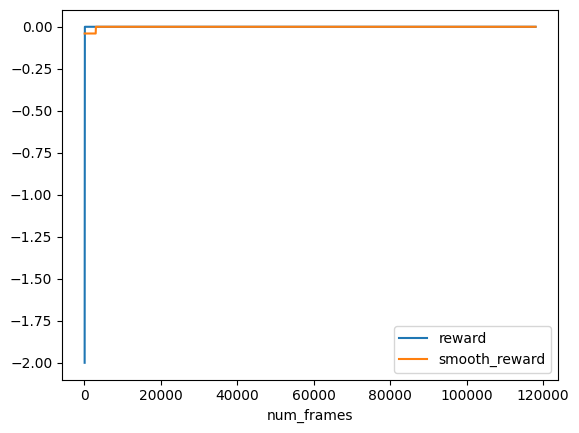

In [ ]:
args = Config()
args.use_discounted_reward=True
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y=['reward', 'smooth_reward'])

## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


 23%|██▎       | 466/2000 [04:00<13:12,  1.94it/s]

Solved!


<Axes: xlabel='num_frames'>

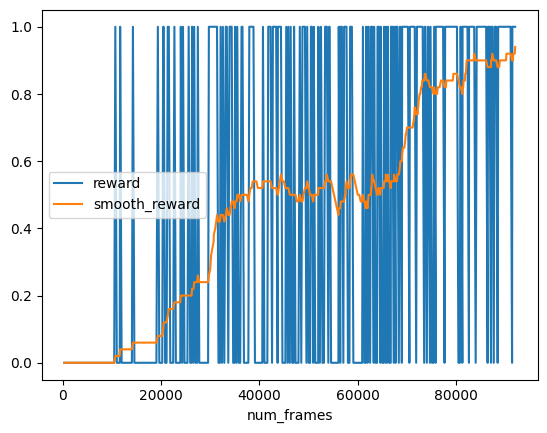

In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results! Fortunately, we can do even better. The paper Generalized Advantage Estimation describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping). Implemented the GAE function we left blank from earlier.

 28%|██▊       | 563/2000 [04:31<11:32,  2.08it/s]

Solved!


<Axes: xlabel='num_frames'>

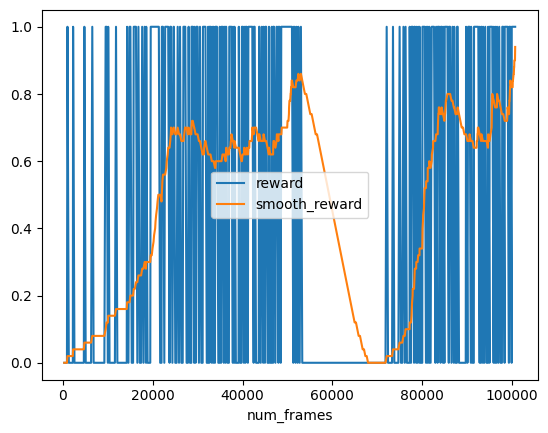

In [ ]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots
If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, and GAE!

**(10 pts)** Now let's visualize every result in one plot.

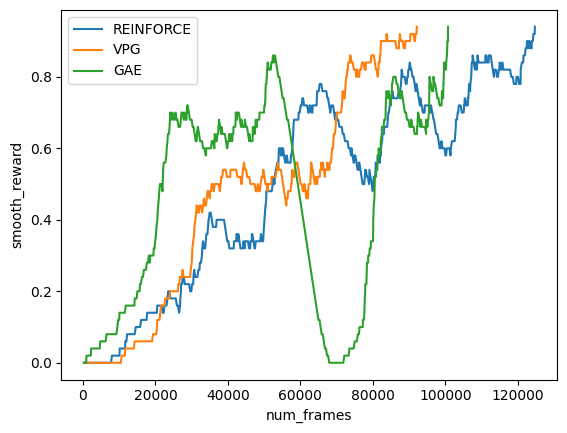

In [ ]:
# TODO Visualize all results into one plot.

# plot(df['num_frames'], df['smooth_reward'])

ax = None
for t, name in ((df, 'REINFORCE'), (df_baseline, 'VPG'), (df_gae, 'GAE')):
  t = t.rename(columns={'smooth_reward': name})
  ax = t.plot(ax=ax, x='num_frames', y=name, ylabel='smooth_reward')